# DATA 601 - PM GROUP 12: COVID-19 Tracking Project 
***

Introduction:
The COVID-19 pandemic is currently a global outbreak of an untreatable strain of coronavirus that was first identified in late 2019 that has impacted both health and the economy. In Canada - 151,671 total cases and 9,261 deaths have been recorded to date while total job losses have reached a peak of 3 million and unemployment of 10.2%

Each province in Canada has imposed province-specific restrictions to tackle the COVID-19 outbreak. This project intends to examine both Canadian COVID-19 data and Government of Canada economic data to evaluate how each province has fared during COVID-19 and if there are any learnings that can better prepare Canada for the next pandemic.
***
### 4 KEY GUIDING QUESTIONS
***
The following guiding questions intend to investigate the COVID19 and economic data to determine the effectiveness of restrictions by each province. Each province will be ranked on health and economic recovery to date to determine the most effective COVID-19 policies. 
Asymptomatic spreading of COVID-19 has been considered as a factor in rising case counts so this will be evaluated to determine if this has been a factor in the data reviewed.

#### 1) Have provinces that have loosened restrictions earlier experienced higher case counts and deaths than provinces that have been more stringent – on total and per capita basis?
<br>

#### 2) Excess deaths are the number of deaths that are elevated over historical averages. Stringent restrictions have been considered as a factor in higher excess death counts. How has COVID-19 impacted overall death tolls across each province?
<br>

#### 3) After the drop in employment rate that Canadians experienced during the first wave of the COVID-19 pandemic in early April, has the employment rate gone back up, and which provinces have seen a higher rate of job recovery?
<br>

#### 4) What is the death rate among asymptomatic individuals and what are the characteristics that make up this group of individuals: occupation, recovery rate, age groups. Are certain age groups more likely to be asymptomatic? (Adaeze)
<br>




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

import matplotlib.dates as mdates
from datetime import datetime

import ipywidgets as widgets
from ipywidgets import interact

import plotly as plotly
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import json
py.init_notebook_mode(connected=True)
#plotly.__version__

## Guiding Question #1
***
#### Have provinces that have loosened restrictions earlier experienced higher case counts and deaths than provinces that have been more stringent – on total and per capita basis?

##### Data Source: Data on COVID-19 in Canada
***
This dataset tracks COVID-19 case data as provided by individual Canadian provincial websites. The data is structured in tabular .csv format and is updated daily (5pm MT). Data columns include no. of tests, cases, recoveries, and deaths by province per day. (Public Health Infobase 2020). Contains information licenced under the open government licence - Canada

- https://open.canada.ca/data/en/dataset/261c32ab-4cfd-4f81-9dea-7b64065690dc

#### Part 1 (DATA WRANGLING)

- Import Data - Data on COVID-19 in Canada
- Drop columns that are not needed for analysis
- Data source uses 'Province ID's to tag Provinces - matched ID's to Province Abbreviations for easier data wrangling (Used Dictionary)
- Data source does not have 'per capita' numbers - created dictionary of Province population counts as per: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901

- Merged Province abbreviation dictionary and removed 'pruid' column ; using Province abbrevitations in data table
- Matched index of 'CAN' and 'REP' (Canada and repatriated travellers) - and dropped these rows - analysis is on Provinces only
- Renamed columns so that each is a better description - important for user analysis of data
- Replaced NaN values of particular columns - important when trying to annotate on charts

In [2]:
#import Public Health Infobase – Data on COVID-19 in Canada 2020, Public Health Agency of Canada, Government of Canada
#this dataset is updated daily
coviddata = pd.read_csv("./covid19.csv")

######CLEAN & WRANGLE DATATABLE######

#Not all columns are needed - consolidate to key columns. Also - we will want to make sure totals data is calculated by province (calculate our own data)

print('Pre-Data Wrangling:')
display(coviddata.head())

coviddata=coviddata.drop(['prname','prnameFR','percentrecover','ratetested','percentoday','ratetotal','ratedeaths','percentdeath','percentactive','rateactive','numtotal_last14','ratetotal_last14','numdeaths_last14','ratedeaths_last14','avgtotal_last7','avgincidence_last7','avgdeaths_last7','avgratedeaths_last7'],axis=1)


#import new column (Province Abbreviation) & Population (for per capital calculation as of Q2 2020)
provincedict = {1:'CAN',10:'NL',11:'PEI',12:'NS',13:'NB',24:'QB',35:'ON',46:'MB',47:'SK',48:'AB',59:'BC',60:'YK',61:'NWT',62:'NUN',99:'REP'}

province = pd.Series(provincedict)
province.index.name='pruid'
province.name='Province'

coviddata = pd.merge(coviddata,province,on='pruid',how='outer')

#rearrange table ; keep new Province Column - discard 'pruid'
coviddata = coviddata[['Province','date','numactive','numtoday','numdeathstoday','numtestedtoday','numrecoveredtoday','numconf','numprob','numdeaths','numtested','numrecover']]

#remove Canada (just want province data)
indexdrop = coviddata[coviddata['Province'] == 'CAN' ].index
coviddata = coviddata.drop(indexdrop,axis=0)

#remove Repatriated Travellers (just want province data)
indexdrop = coviddata[coviddata['Province'] == 'REP' ].index
coviddata = coviddata.drop(indexdrop,axis=0)

#replace NaN values for numactive / numtoday / numdeathstoday / numtestedtoday / numrecoveredtoday
coviddata['numactive'] = coviddata['numactive'].fillna(0)
coviddata['numtoday'] = coviddata['numtoday'].fillna(0)
coviddata['numdeathstoday'] = coviddata['numdeathstoday'].fillna(0)
coviddata['numtestedtoday'] = coviddata['numtestedtoday'].fillna(0)
coviddata['numrecoveredtoday'] = coviddata['numrecoveredtoday'].fillna(0)

#rename columns for better description #will 
coviddata.rename(columns={'numactive':'Active Cases'},inplace=True)
coviddata.rename(columns={'numtoday':'Confirmed Cases'},inplace=True)
coviddata.rename(columns={'numdeathstoday':'Deaths'},inplace=True)
coviddata.rename(columns={'numtestedtoday':'Tests'},inplace=True)
coviddata.rename(columns={'numrecoveredtoday':'Recovered Cases'},inplace=True)
coviddata.rename(columns={'numconf':'Confirmed Cases (Total)'},inplace=True)
coviddata.rename(columns={'numprob':'Probable Cases (Total)'},inplace=True)
coviddata.rename(columns={'numdeaths':'Deaths (Total)'},inplace=True)
coviddata.rename(columns={'numtested':'Tests (Total)'},inplace=True)
coviddata.rename(columns={'numrecover':'Recovered (Total)'},inplace=True)

#replace all NaN values
coviddata['Recovered Cases'] = coviddata['Recovered Cases'].fillna(0)
coviddata['Active Cases'] = coviddata['Active Cases'].fillna(0)

print('Post-Data Wrangling:')
display(coviddata.head())

Pre-Data Wrangling:


pruid            prname              prnameFR        date  numconf  \
0     35           Ontario               Ontario  31-01-2020        3   
1     59  British Columbia  Colombie-Britannique  31-01-2020        1   
2      1            Canada                Canada  31-01-2020        4   
3     35           Ontario               Ontario  08-02-2020        3   
4     59  British Columbia  Colombie-Britannique  08-02-2020        4   

   numprob  numdeaths  numtotal  numtested  numrecover  ...  numactive  \
0        0        0.0         3        NaN         NaN  ...        3.0   
1        0        0.0         1        NaN         NaN  ...        1.0   
2        0        0.0         4        NaN         NaN  ...        4.0   
3        0        0.0         3        NaN         NaN  ...        3.0   
4        0        0.0         4        NaN         NaN  ...        4.0   

   rateactive  numtotal_last14  ratetotal_last14  numdeaths_last14  \
0        0.02              NaN               NaN               NaN   
1        0.02              NaN               NaN               NaN   
2        0.01              NaN               NaN               NaN   
3        0.02              NaN               NaN               NaN   
4        0.08              NaN               NaN               NaN   

   ratedeaths_last14  avgtotal_last7  avgincidence_last7  avgdeaths_last7  \
0                NaN             NaN                 NaN              NaN   
1                NaN             NaN                 NaN              NaN   
2                NaN             NaN                 NaN              NaN   
3                NaN             NaN                 NaN              NaN   
4                NaN             NaN                 NaN              NaN   

   avgratedeaths_last7  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  

[5 rows x 31 columns]

Post-Data Wrangling:


Province        date  Active Cases  Confirmed Cases  Deaths  Tests  \
0       ON  31-01-2020           3.0                3     0.0    0.0   
1       ON  08-02-2020           3.0                0     0.0    0.0   
2       ON  16-02-2020           3.0                0     0.0    0.0   
3       ON  21-02-2020           3.0                0     0.0    0.0   
4       ON  24-02-2020           4.0                1     0.0    0.0   

   Recovered Cases  Confirmed Cases (Total)  Probable Cases (Total)  \
0              0.0                        3                       0   
1              0.0                        3                       0   
2              0.0                        3                       0   
3              0.0                        3                       0   
4              0.0                        4                       0   

   Deaths (Total)  Tests (Total)  Recovered (Total)  
0             0.0            NaN                NaN  
1             0.0            NaN                NaN  
2             0.0            NaN                NaN  
3             0.0            NaN                NaN  
4             0.0            NaN                NaN

##### Part 1 (DATA WRANGLING) - Import Population Data 
***
- Data source does not have 'per capita' numbers - created dictionary of Province population counts as per: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901

- Merged Population data into core data table 'coviddata'

In [3]:
###### FURTHER CLEANUP OF DATATABLE

#The following code was to manually calculate active cases - very close to dataset provided so didn't need ; commented out
#Manually calculated values to check this datasets 'Active Cases' calculation
#The 'Calculated Active Cases' values are close to 'numactive' ; but slightly different. Keeping this code for now
#coviddata['Recovered (Total)'] = coviddata.groupby(['Province'])['Recovered Cases'].cumsum()
#coviddata['Deaths (Total)'] = coviddata.groupby(['Province'])['Deaths'].cumsum()
#coviddata['Calculated Active Cases'] = coviddata['Confirmed Cases (Total)']+coviddata['Probable Cases (Total)']-coviddata['Recovered (Total)']-coviddata['Deaths (Total)']

###### MERGE AND ADD POPULATION DATASET (FOR PER CAPITA CALCULATION)
popdict = {'CAN':37979854,'NL':522997,'PEI':159249,'NS':977043,'NB':781024,'QB':8572054,'ON':14723497,'MB':1378818,'SK':1179618,'AB':4417006,'BC':5142404,'YK':41980,'NWT':45201,'NUN':38966,'REP':1}

population_data = {'Province':[*popdict.keys()],'Population':[*popdict.values()]}
population = pd.DataFrame(population_data)
coviddata = coviddata.merge(population,on='Province',how='left')

display(coviddata.head())

Province        date  Active Cases  Confirmed Cases  Deaths  Tests  \
0       ON  31-01-2020           3.0                3     0.0    0.0   
1       ON  08-02-2020           3.0                0     0.0    0.0   
2       ON  16-02-2020           3.0                0     0.0    0.0   
3       ON  21-02-2020           3.0                0     0.0    0.0   
4       ON  24-02-2020           4.0                1     0.0    0.0   

   Recovered Cases  Confirmed Cases (Total)  Probable Cases (Total)  \
0              0.0                        3                       0   
1              0.0                        3                       0   
2              0.0                        3                       0   
3              0.0                        3                       0   
4              0.0                        4                       0   

   Deaths (Total)  Tests (Total)  Recovered (Total)  Population  
0             0.0            NaN                NaN    14723497  
1             0.0            NaN                NaN    14723497  
2             0.0            NaN                NaN    14723497  
3             0.0            NaN                NaN    14723497  
4             0.0            NaN                NaN    14723497

##### Part 1 (DATA WRANGLING) - Date-Time Formatting
***

In [4]:
###### DATATABLE - DATE COLUMN NEEDS CONVERSION TO DATE-TIME FORMAT ######

print(coviddata['date'].dtypes)
coviddata['date'] = pd.to_datetime(coviddata['date'],dayfirst=True)
print(coviddata['date'].dtypes)

###### SET DATE AS TABLE INDEX ######
coviddata.index = pd.DatetimeIndex(data=coviddata['date'])

display(coviddata.head())


object
datetime64[ns]


Province       date  Active Cases  Confirmed Cases  Deaths  Tests  \
date                                                                           
2020-01-31       ON 2020-01-31           3.0                3     0.0    0.0   
2020-02-08       ON 2020-02-08           3.0                0     0.0    0.0   
2020-02-16       ON 2020-02-16           3.0                0     0.0    0.0   
2020-02-21       ON 2020-02-21           3.0                0     0.0    0.0   
2020-02-24       ON 2020-02-24           4.0                1     0.0    0.0   

            Recovered Cases  Confirmed Cases (Total)  Probable Cases (Total)  \
date                                                                           
2020-01-31              0.0                        3                       0   
2020-02-08              0.0                        3                       0   
2020-02-16              0.0                        3                       0   
2020-02-21              0.0                        3                       0   
2020-02-24              0.0                        4                       0   

            Deaths (Total)  Tests (Total)  Recovered (Total)  Population  
date                                                                      
2020-01-31             0.0            NaN                NaN    14723497  
2020-02-08             0.0            NaN                NaN    14723497  
2020-02-16             0.0            NaN                NaN    14723497  
2020-02-21             0.0            NaN                NaN    14723497  
2020-02-24             0.0            NaN                NaN    14723497

##### Part 2 (PREPARING DATA TO CHART)
***
- to properly plot individual provinces - each province needed to be spliced into it's unique data table

In [5]:
###### CREATE DATAFRAMES BY PROVINCE ######
#this is required to properly plot multiple provinces on a single plot

dfBC = coviddata.loc[(coviddata.Province == 'BC')]
dfAB = coviddata.loc[(coviddata.Province == 'AB')]
dfSK = coviddata.loc[(coviddata.Province == 'SK')]
dfMB = coviddata.loc[(coviddata.Province == 'MB')]
dfON = coviddata.loc[(coviddata.Province == 'ON')]
dfQB = coviddata.loc[(coviddata.Province == 'QB')]
dfNB = coviddata.loc[(coviddata.Province == 'NB')]
dfNS = coviddata.loc[(coviddata.Province == 'NS')]
dfPEI = coviddata.loc[(coviddata.Province == 'PEI')]
dfNL = coviddata.loc[(coviddata.Province == 'NL')]
dfYK = coviddata.loc[(coviddata.Province == 'YK')]
dfNWT = coviddata.loc[(coviddata.Province == 'NWT')]
dfNUN = coviddata.loc[(coviddata.Province == 'NUN')]                                                                                                                         

#### Part 2 (PREPARING DATA TO CHART) - Annotations
***
- The Province Policy below was created by summarizing each province policy changes over time through each 'Re-opening Stage'
- Referenences for policy data for each province can be found at bottom of notebook
- Key Stage Dates - were used to create a dictionary by province - with date and string description of each stage
- Province Re-Opening Policies were classified into two categories: Stringent & Lenient
- Strict Provinces:
    * New Brunswick (NB)
    * Nova Scotia (NS)
    * Prince Edward Is (PEI)
    * Newfoundland & Labrador (NL)
    * Yukon (YK)
    * Northwest Territories (NWT)
    * Nunavut (NUN)
- Lenient Provinces:
    * British Columbia (BC)
    * Alberta (AB)
    * Saskatchewan (SK)
    * Manitoba (MB)
    * Ontario (ON)
    * Quebec (QB)
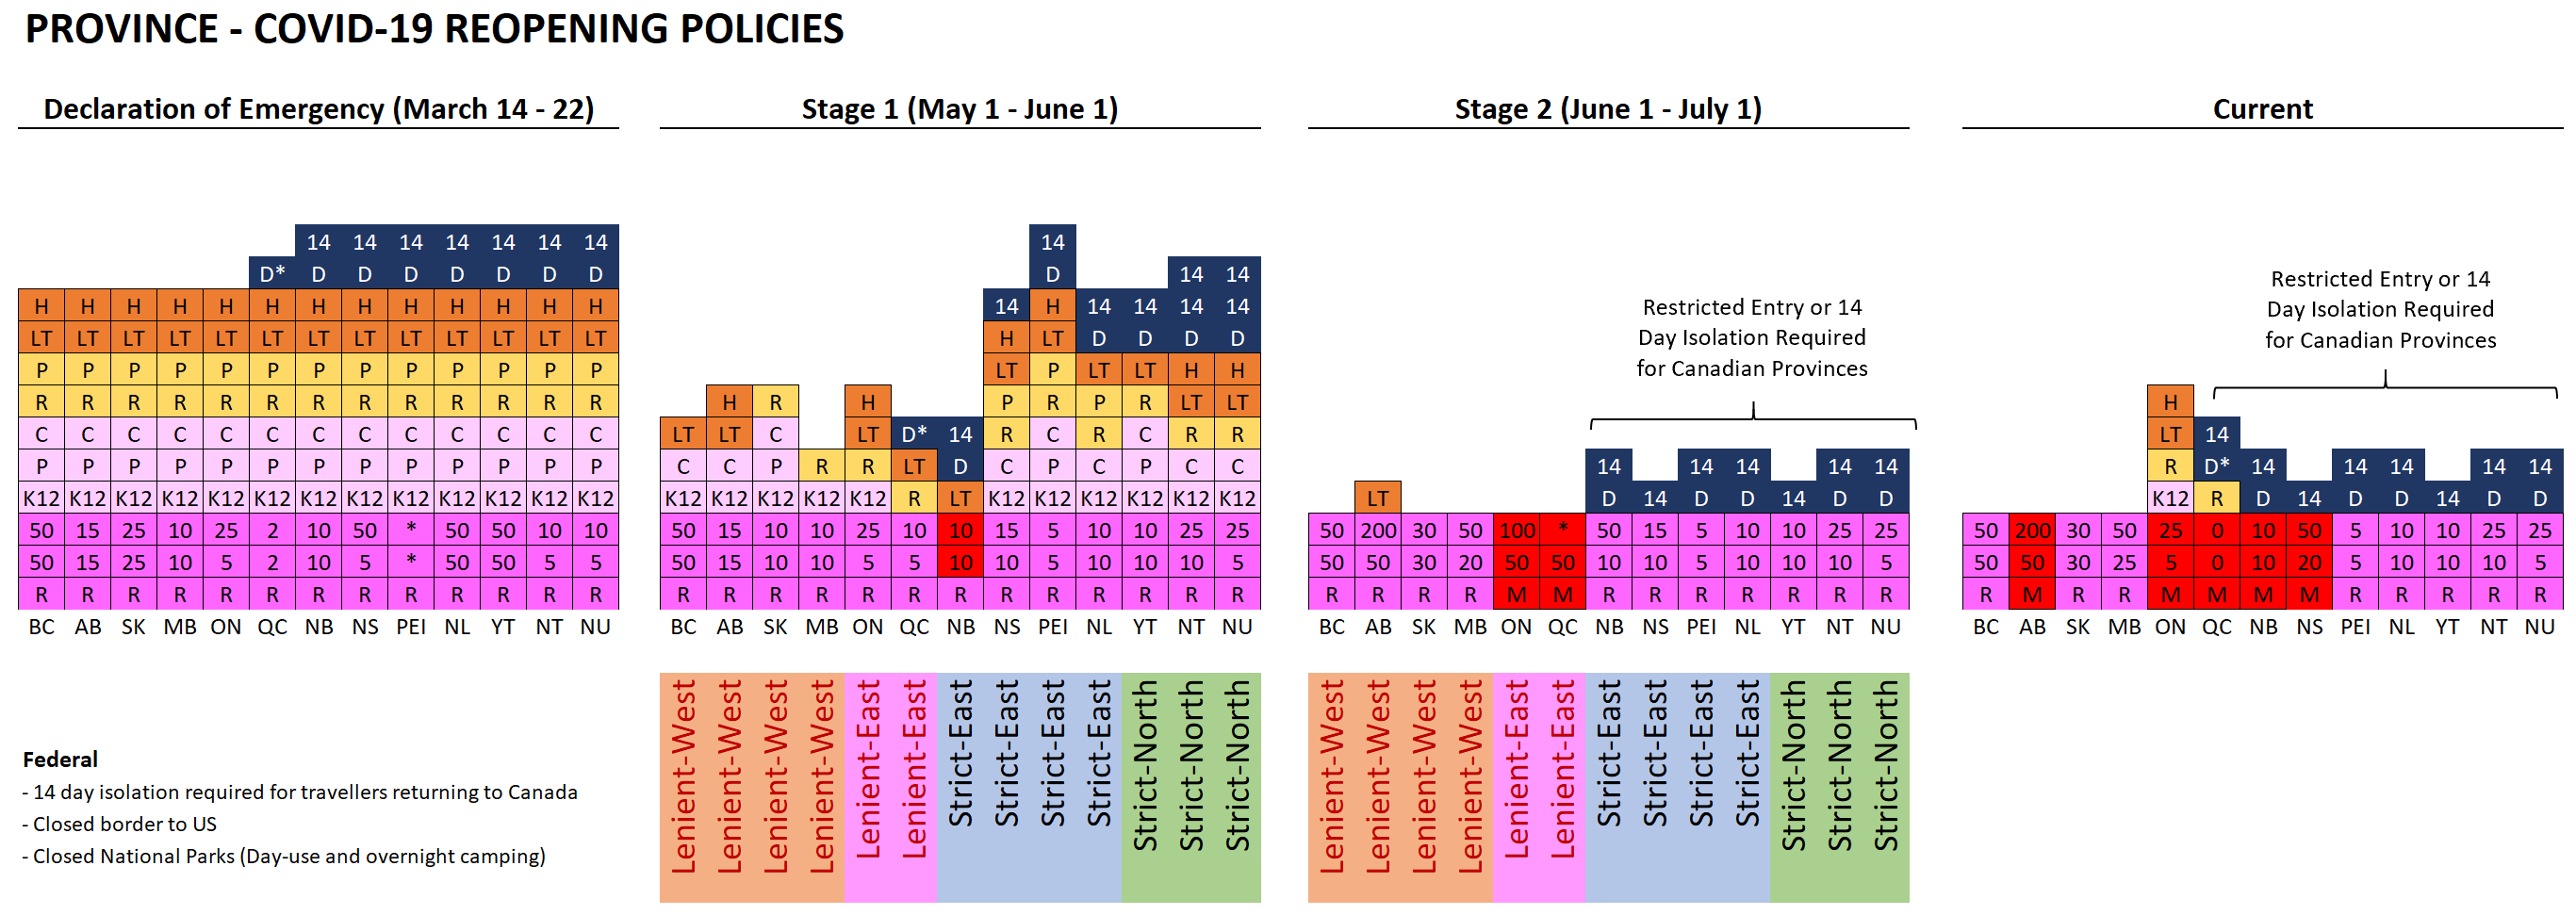
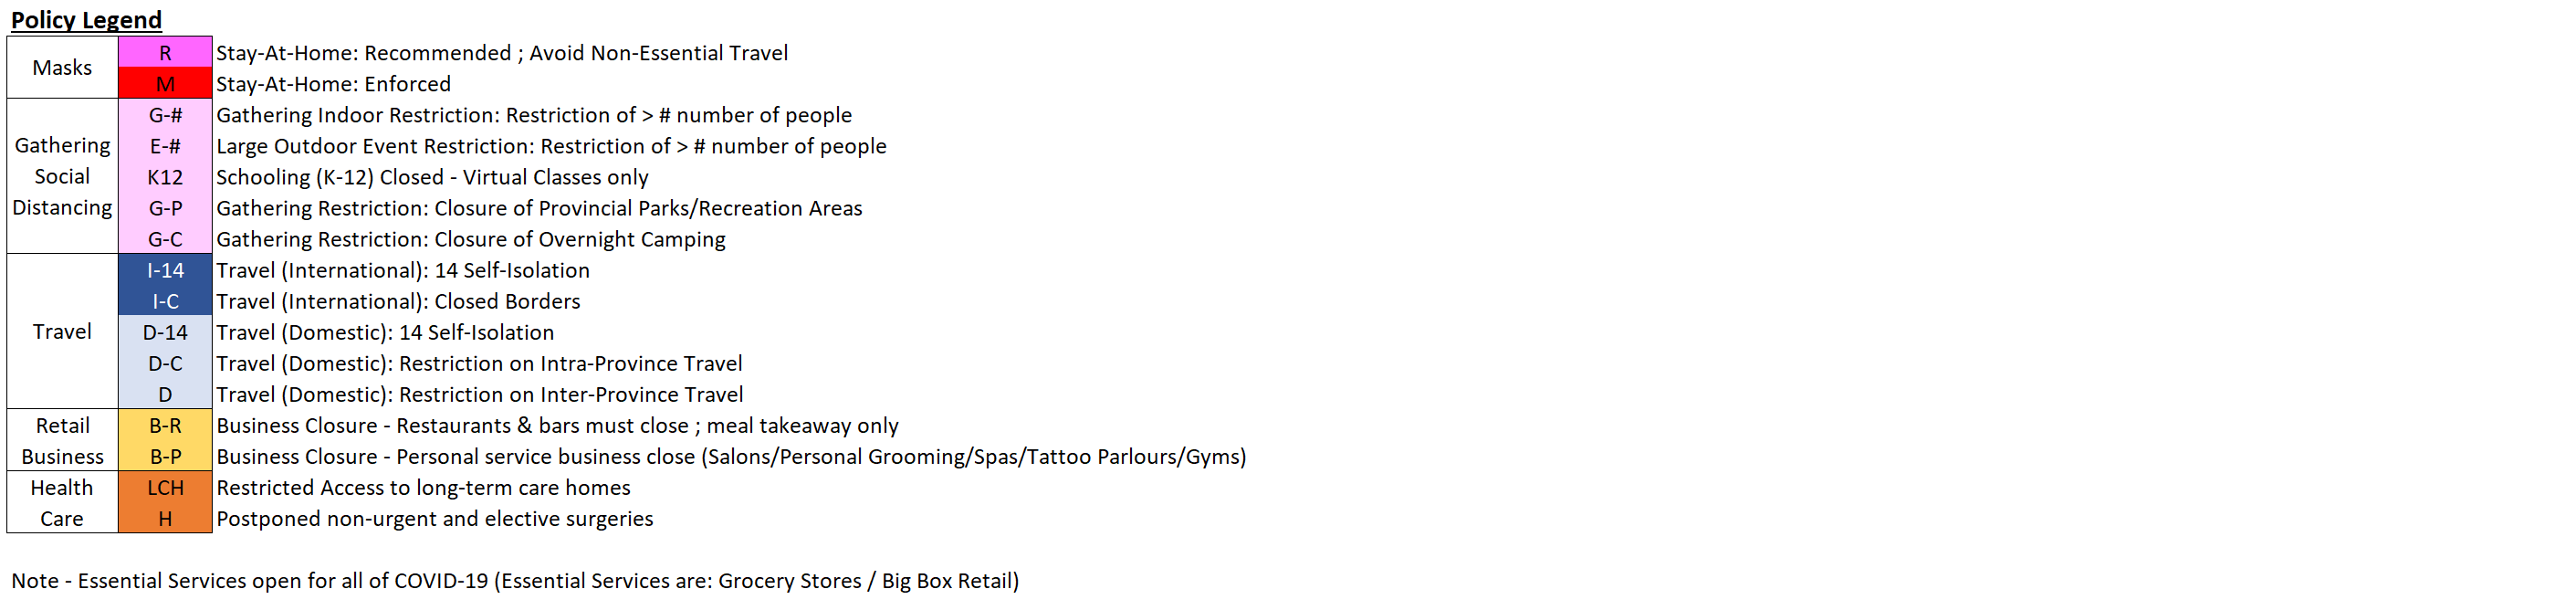


#### Part 2 (PREPARING DATA TO CHART) - Annotations
***
- Key Dates for each province re-opening stages are converted to annotations (date,text) so that cause/effect can be reviewed with respect to key policy changes
- See 'Canada-Provinces COVID-19 Policy Reference Links' for website URLs used to compile Province Policy Summary

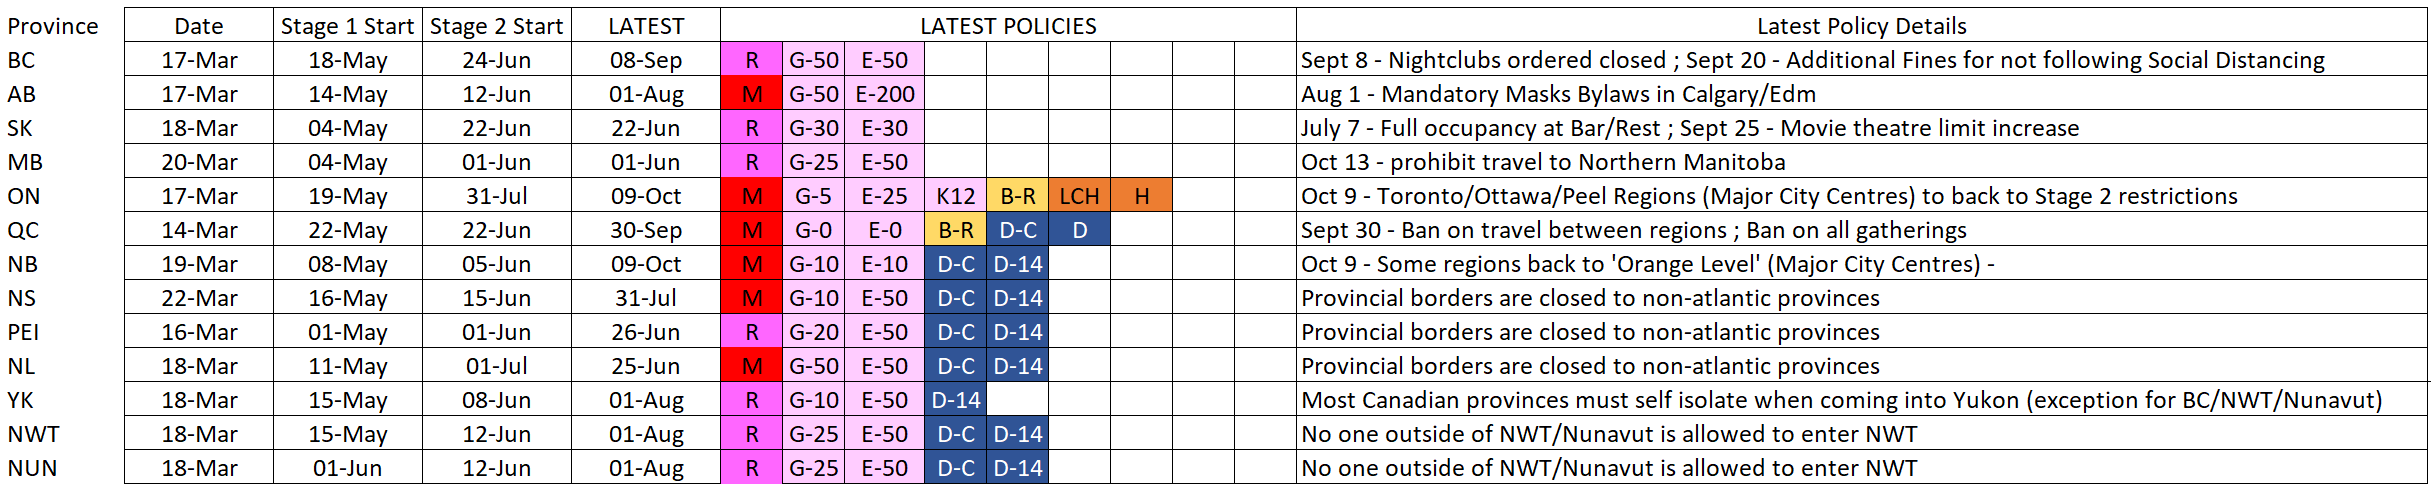

In [6]:
###### ANNOTATIONS ######
#this is a manually created dictionary - by province - that highlights key dates on Covid-19 policy stages

Stages_ALL = [(datetime(2020,3,15),'Declared SOE'),(datetime(2020,5,15),'Stg 1'),(datetime(2020,6,15),'Stg 2')]
Stages_BC = [(datetime(2020,3,17),'Declared SOE'),(datetime(2020,5,18),'Stg 1'),(datetime(2020,6,24),'Stg 2'),(datetime(2020,9,8),'Nightclubs Closed')]
Stages_AB = [(datetime(2020,3,17),'Declared SOE'),(datetime(2020,5,14),'Stg 1'),(datetime(2020,6,12),'Stg 2'),(datetime(2020,8,1),'Mand. Masks - City'),(datetime(2020,10,8),'Mand. Masks - Prov')]
Stages_SK = [(datetime(2020,3,18),'Declared SOE'),(datetime(2020,5,4),'Stg 1'),(datetime(2020,6,22),'Stg 2'),(datetime(2020,9,25),'Incr. Indoor Limits to 150')]
Stages_MB = [(datetime(2020,3,20),'Declared SOE'),(datetime(2020,5,4),'Stg 1'),(datetime(2020,6,1),'Stg 2'),(datetime(2020,10,9),'Nth MB Restricted')]
Stages_ON = [(datetime(2020,3,17),'Declared SOE'),(datetime(2020,5,19),'Stg 1'),(datetime(2020,7,7),'Mand. Masks'),(datetime(2020,7,31),'Stg 2'),(datetime(2020,10,13),'Back to Stg 1')]
Stages_QB = [(datetime(2020,3,14),'Declared SOE'),(datetime(2020,5,22),'Stg 1'),(datetime(2020,6,22),'Stg 2'),(datetime(2020,7,18),'Mand. Masks'),(datetime(2020,9,30),'Back to Stg 1')]
Stages_NB = [(datetime(2020,3,19),'Declared SOE'),(datetime(2020,5,8),'Stg 1'),(datetime(2020,6,5),'Stg 2'),(datetime(2020,10,9),'Back to Stg 1')]
Stages_NS = [(datetime(2020,3,22),'Declared SOE'),(datetime(2020,5,16),'Stg 1'),(datetime(2020,6,15),'Stg 2'),(datetime(2020,7,24),'Mand. Masks'),(datetime(2020,10,10),'Non-Atlantic Self-iso req')]
Stages_PEI = [(datetime(2020,3,16),'Declared SOE'),(datetime(2020,5,1),'Stg 1'),(datetime(2020,6,1),'Stg 2'),(datetime(2020,10,10),'Non-Atlantic Restricted')]
Stages_NL = [(datetime(2020,3,18),'Declared SOE'),(datetime(2020,5,11),'Stg 1'),(datetime(2020,7,1),'Stg 2'),(datetime(2020,8,24),'Mand. Masks'),(datetime(2020,10,10),'Non-Atlantic Restricted')]
Stages_YK = [(datetime(2020,3,18),'Declared SOE'),(datetime(2020,5,15),'Stg 1'),(datetime(2020,6,8),'Stg 2'),(datetime(2020,8,1),'Self-iso req')]
Stages_NWT = [(datetime(2020,3,18),'Declared SOE'),(datetime(2020,5,15),'Stg 1'),(datetime(2020,6,12),'Stg 2'),(datetime(2020,8,1),'Entry Restricted')]
Stages_NUN = [(datetime(2020,3,18),'Declared SOE'),(datetime(2020,6,1),'Stg 1'),(datetime(2020,6,12),'Stg 2'),(datetime(2020,8,1),'Entry Restricted')]

##### Part 3 (VISUALIZATIONS)
***
- 2 KEY CHARTS:
    * INTERACTIVE Line Chart: Active Cases / Deaths / Recovered / Tested vs time - BY PROVINCE
        * User Input on metric to visualize
        * User Input on metric normalization ('per capita')
        * User Input on data selection (by Province or by Strict vs Lenient)
    * INTERACTIVE Bar Chart: Active Cases / Deaths / Recovered / Tested - Totals Ranks - BY PROVINCE
        * User Input on metric to visualize
        * User Input on metric normalization ('per capita')

##### Part 3 (VISUALIZATIONS)
***
#### INTERACTIVE LINE CHART - ALL PROVINCES

In [7]:
###### KEY INTERACTIVE VISUALIZATION ######

line=go.Figure()
fig= go.FigureWidget(data=line)

@interact(Dataset = ['Active Cases','Confirmed Cases','Deaths','Tests','Confirmed Cases (Total)','Probable Cases (Total)','Deaths (Total)','Tests (Total)','Recovered (Total)'],Prov_Select = ['Summary','Strict-North','Strict-East','Lenient-West','Lenient-East','All','BC','AB','SK','MB','ON','QB','NB','NS','PEI','NL','YK','NWT','NUN'],Per_Capita = ['Yes','No'],Per_No =[100000,1000000,10000000],Scale = ['Yes','No'],xMin = (3,12,1),xMax = (3,12,1),yScale=(0,30000,10))
def update_chart(Dataset='Active Cases',Prov_Select='All',Per_Capita = 'No',Per_No = 1000000 ,Scale = 'No',xMin=3,xMax=12,yScale=30000):    
    
    
    fig.data=[]
    fig.layout={}
    fig.layout={'annotations':[]}
    if Per_Capita == 'No':
        #Raw Dataframe table
        figA = go.Figure(data=go.Scatter(x=dfBC.date, y=(dfBC[Dataset]+dfAB[Dataset]+dfSK[Dataset]+dfMB[Dataset])/4,marker=dict(size=4,color='#fe9929'),mode='lines+markers',name='Lenient-West'))
        figB = go.Figure(data=go.Scatter(x=dfON.date, y=(dfON[Dataset]+dfQB[Dataset])/2,marker=dict(size=4,color='#dd1c77'),mode='lines+markers',name='Lenient-East'))
        figC = go.Figure(data=go.Scatter(x=dfNB.date, y=(dfNB[Dataset]+dfNS[Dataset]+dfPEI[Dataset]+dfNL[Dataset])/4,marker=dict(size=4,color='#9ecae1'),mode='lines+markers',name='Strict-East'))
        figD =go.Figure(data=go.Scatter(x=dfYK.date, y=(dfYK[Dataset]+dfNWT[Dataset]+dfNUN[Dataset])/3,marker=dict(size=4,color='#addd8e'),mode='lines+markers',name='Strict-North'))
        fig1 = go.Figure(data=go.Scatter(x=dfBC.date, y=dfBC[Dataset],marker=dict(size=4,color='#993404'),mode='lines+markers',name='BC'))
        fig2 = go.Figure(data=go.Scatter(x=dfAB.date, y=dfAB[Dataset],marker=dict(size=4,color='#d95f0e'),mode='lines+markers',name='AB'))
        fig3 = go.Figure(data=go.Scatter(x=dfSK.date, y=dfSK[Dataset],marker=dict(size=4,color='#fe9929'),mode='lines+markers',name='SK'))
        fig4 = go.Figure(data=go.Scatter(x=dfMB.date, y=dfMB[Dataset],marker=dict(size=4,color='#fee391'),mode='lines+markers',name='MB'))
        fig5 = go.Figure(data=go.Scatter(x=dfON.date, y=dfON[Dataset],marker=dict(size=4,color='#c994c7'),mode='lines+markers',name='ON'))
        fig6 = go.Figure(data=go.Scatter(x=dfQB.date, y=dfQB[Dataset],marker=dict(size=4,color='#dd1c77'),mode='lines+markers',name='QB'))
        fig7 = go.Figure(data=go.Scatter(x=dfNB.date, y=dfNB[Dataset],marker=dict(size=4,color='#9ecae1'),mode='lines+markers',name='NB'))
        fig8 = go.Figure(data=go.Scatter(x=dfNS.date, y=dfNS[Dataset],marker=dict(size=4,color='#6baed6'),mode='lines+markers',name='NS'))
        fig9 = go.Figure(data=go.Scatter(x=dfPEI.date, y=dfPEI[Dataset],marker=dict(size=4,color='#3182bd'),mode='lines+markers',name='PEI'))
        fig10 = go.Figure(data=go.Scatter(x=dfNL.date, y=dfNL[Dataset],marker=dict(size=4,color='#08519c'),mode='lines+markers',name='NL'))
        fig11 = go.Figure(data=go.Scatter(x=dfYK.date, y=dfYK[Dataset],marker=dict(size=4,color='#addd8e'),mode='lines+markers',name='YK'))
        fig12 = go.Figure(data=go.Scatter(x=dfNWT.date, y=dfNWT[Dataset],marker=dict(size=4,color='#78c679'),mode='lines+markers',name='NWT'))
        fig13 = go.Figure(data=go.Scatter(x=dfNUN.date, y=dfNUN[Dataset],marker=dict(size=4,color='#31a354'),mode='lines+markers',name='NUN'))  
    
    else:
        #Wrange data in line traces to illustrate per capita numbers (that can be manually adjusted by user)
        figA = go.Figure(data=go.Scatter(x=dfBC.date, y=(((dfBC[Dataset]+dfAB[Dataset]+dfSK[Dataset]+dfMB[Dataset])/4)/(dfBC['Population']+dfAB['Population']+dfSK['Population']+dfMB['Population'])/4)*Per_No,marker=dict(size=4,color='#fe9929'),mode='lines+markers',name='Lenient-West'))
        figB = go.Figure(data=go.Scatter(x=dfON.date, y=(((dfON[Dataset]+dfQB[Dataset])/2)/(dfON['Population']+dfQB['Population'])/2)*Per_No,marker=dict(size=4,color='#dd1c77'),mode='lines+markers',name='Lenient-East'))
        figC = go.Figure(data=go.Scatter(x=dfNB.date, y=(((dfNB[Dataset]+dfNS[Dataset]+dfPEI[Dataset]+dfNL[Dataset])/4)/(dfNB['Population']+dfNS['Population']+dfPEI['Population']+dfNL['Population'])/4)*Per_No,marker=dict(size=4,color='#9ecae1'),mode='lines+markers',name='Strict-East'))
        figD =go.Figure(data=go.Scatter(x=dfYK.date, y=(((dfYK[Dataset]+dfNWT[Dataset]+dfNUN[Dataset])/3)/(dfYK['Population']+dfNWT['Population']+dfNUN['Population'])/3)*Per_No,marker=dict(size=4,color='#addd8e'),mode='lines+markers',name='Strict-North'))
        fig1 = go.Figure(data=go.Scatter(x=dfBC.date, y=(dfBC[Dataset]/dfBC['Population'])*Per_No,marker=dict(size=4,color='#993404'),mode='lines+markers',name='BC'))
        fig2 = go.Figure(data=go.Scatter(x=dfAB.date, y=(dfAB[Dataset]/dfAB['Population'])*Per_No,marker=dict(size=4,color='#d95f0e'),mode='lines+markers',name='AB'))
        fig3 = go.Figure(data=go.Scatter(x=dfSK.date, y=(dfSK[Dataset]/dfSK['Population'])*Per_No,marker=dict(size=4,color='#fe9929'),mode='lines+markers',name='SK'))
        fig4 = go.Figure(data=go.Scatter(x=dfMB.date, y=(dfMB[Dataset]/dfMB['Population'])*Per_No,marker=dict(size=4,color='#fee391'),mode='lines+markers',name='MB'))
        fig5 = go.Figure(data=go.Scatter(x=dfON.date, y=(dfON[Dataset]/dfON['Population'])*Per_No,marker=dict(size=4,color='#c994c7'),mode='lines+markers',name='ON'))
        fig6 = go.Figure(data=go.Scatter(x=dfQB.date, y=(dfQB[Dataset]/dfQB['Population'])*Per_No,marker=dict(size=4,color='#dd1c77'),mode='lines+markers',name='QB'))
        fig7 = go.Figure(data=go.Scatter(x=dfNB.date, y=(dfNB[Dataset]/dfNB['Population'])*Per_No,marker=dict(size=4,color='#9ecae1'),mode='lines+markers',name='NB'))
        fig8 = go.Figure(data=go.Scatter(x=dfNS.date, y=(dfNS[Dataset]/dfNS['Population'])*Per_No,marker=dict(size=4,color='#6baed6'),mode='lines+markers',name='NS'))
        fig9 = go.Figure(data=go.Scatter(x=dfPEI.date, y=(dfPEI[Dataset]/dfPEI['Population'])*Per_No,marker=dict(size=4,color='#3182bd'),mode='lines+markers',name='PEI'))
        fig10 = go.Figure(data=go.Scatter(x=dfNL.date, y=(dfNL[Dataset]/dfNL['Population'])*Per_No,marker=dict(size=4,color='#08519c'),mode='lines+markers',name='NL'))
        fig11 = go.Figure(data=go.Scatter(x=dfYK.date, y=(dfYK[Dataset]/dfYK['Population'])*Per_No,marker=dict(size=4,color='#addd8e'),mode='lines+markers',name='YK'))
        fig12 = go.Figure(data=go.Scatter(x=dfNWT.date, y=(dfNWT[Dataset]/dfNWT['Population'])*Per_No,marker=dict(size=4,color='#78c679'),mode='lines+markers',name='NWT'))
        fig13 = go.Figure(data=go.Scatter(x=dfNUN.date, y=(dfNUN[Dataset]/dfNUN['Population'])*Per_No,marker=dict(size=4,color='#31a354'),mode='lines+markers',name='NUN'))
  

    if Prov_Select == 'Summary':
        fig.add_trace(figA.data[0])
        fig.add_trace(figB.data[0])
        fig.add_trace(figC.data[0])
        fig.add_trace(figD.data[0])
    elif Prov_Select == 'Strict-East':
        fig.add_trace(fig7.data[0])
        fig.add_trace(fig8.data[0])
        fig.add_trace(fig9.data[0])
        fig.add_trace(fig10.data[0])
    elif Prov_Select == 'Strict-North':
        fig.add_trace(fig11.data[0])
        fig.add_trace(fig12.data[0])
        fig.add_trace(fig13.data[0])
    elif Prov_Select == 'Lenient-East':
        fig.add_trace(fig5.data[0])
        fig.add_trace(fig6.data[0])
    elif Prov_Select == 'Lenient-West':
        fig.add_trace(fig1.data[0])
        fig.add_trace(fig2.data[0])
        fig.add_trace(fig3.data[0])
        fig.add_trace(fig4.data[0])
    elif Prov_Select == 'All':
        fig.add_trace(fig1.data[0])
        fig.add_trace(fig2.data[0])
        fig.add_trace(fig3.data[0])
        fig.add_trace(fig4.data[0])
        fig.add_trace(fig5.data[0])
        fig.add_trace(fig6.data[0])
        fig.add_trace(fig7.data[0])
        fig.add_trace(fig8.data[0])
        fig.add_trace(fig9.data[0])
        fig.add_trace(fig10.data[0])
        fig.add_trace(fig11.data[0])
        fig.add_trace(fig12.data[0])
        fig.add_trace(fig13.data[0])
        for date,label in Stages_ALL:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=0,text=label)
            else:
                fig.add_annotation(x=date,y=0,text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-180,textangle=-90)
    elif Prov_Select == 'BC':
        fig.add_trace(fig1.data[0])
        for date,label in Stages_BC:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfBC[Dataset].asof(date)/dfBC['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfBC[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'AB':
        fig.add_trace(fig2.data[0])
        for date,label in Stages_AB:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfAB[Dataset].asof(date)/dfAB['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfAB[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'SK':
        fig.add_trace(fig3.data[0])
        for date,label in Stages_SK:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfSK[Dataset].asof(date)/dfSK['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfSK[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'MB':
        fig.add_trace(fig4.data[0])
        for date,label in Stages_MB:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfMB[Dataset].asof(date)/dfMB['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfMB[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'ON':
        fig.add_trace(fig5.data[0])
        for date,label in Stages_ON:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfON[Dataset].asof(date)/dfON['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfON[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'QB':
        fig.add_trace(fig6.data[0])
        for date,label in Stages_QB:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfQB[Dataset].asof(date)/dfQB['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfQB[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'NB':
        fig.add_trace(fig7.data[0])
        for date,label in Stages_NB:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfNB[Dataset].asof(date)/dfNB['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfNB[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'NS':
        fig.add_trace(fig8.data[0])
        for date,label in Stages_NS:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfNS[Dataset].asof(date)/dfNS['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfNS[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'PEI':
        fig.add_trace(fig9.data[0])
        for date,label in Stages_PEI:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfPEI[Dataset].asof(date)/dfPEI['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfPEI[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'NL':
        fig.add_trace(fig10.data[0])
        for date,label in Stages_NL:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfNL[Dataset].asof(date)/dfNL['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfNL[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'YK':
        fig.add_trace(fig11.data[0])
        for date,label in Stages_YK:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfYK[Dataset].asof(date)/dfYK['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfYK[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'NWT':
        fig.add_trace(fig12.data[0])
        for date,label in Stages_NWT:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfNWT[Dataset].asof(date)/dfNWT['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfNWT[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
    elif Prov_Select == 'NUN':
        fig.add_trace(fig13.data[0])
        for date,label in Stages_NUN:
            if Per_Capita == 'Yes':
                fig.add_annotation(x=date,y=(dfNUN[Dataset].asof(date)/dfNUN['Population'].asof(date))*Per_No,text=label)
            else:
                fig.add_annotation(x=date,y=dfNUN[Dataset].asof(date),text=label)
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
                
   

    fig.update_layout(title="{1} by Province - Scenario: {0}".format(Prov_Select,Dataset),xaxis_title="Date",yaxis_title=Dataset,legend_title="Prov/Terr")
    
    if Scale == 'Yes':
        fig.update_yaxes(range=[0,yScale])
        fig.update_xaxes(range=[datetime(2020,xMin,1),datetime(2020,xMax,1)])
                        
    
    fig.update_layout(height=750,width=1000)
    #fig.update_annotations()
    fig.show()




interactive(children=(Dropdown(description='Dataset', options=('Active Cases', 'Confirmed Cases', 'Deaths', 'T…

## KEY OBSERVATIONS FROM INTERACTIVE LINE CHART 


### Active Cases by Province
- Set Dataset to 'Active Cases'
- Cycle through Provinces under 'Prov_Select'

- All Provinces had significant active case increases in COVID-19 first wave (Declaration of State of Emergency to Stage 1 re-opening)
- This is highlighted particularly when looking at per Capita metrics (per 1MM people)
- COVID-19 Active cases came down over time after Stage 1 
    * Each Province can be selected and reviewed on its own with unique annotations describing the date for each stage / major policy change
    
- All provinces that loosened restrictions at a particular stage - had significant active case resurgence not too far after these key dates
- Provinces that maintained travel restrictions (Atlantic Provinces and Northern Provinces/Territories) have not had COVID-19 resurgence
    * Key Province Examples:
        * BC (Stage 2)
        * AB (Stage 2)
        * SK (Stage 2)
        * MB - No significant resurgence after major policy loosening
        * ON (Stage 1 & Stage 2)
        * QB (Stage 2)
        * NB (Stage 2)
        * NS - No significant resurgence after major policy loosening
        * PEI - No significant resurgence after major policy loosening
        * NL - No significant resurgence after major policy loosening
        * YK - No significant resurgence after major policy loosening
        * NWT - No significant resurgence after major policy loosening
        * NUN - No significant resurgence after major policy loosening
        
### Conclusion: Maintaining strict inter-country travel restrictions has limited COVID-19 active cases. Provinces that loosened restrictions early saw faster resurgence - particularly after stage 2 (highest policy loosening event)

### Active Cases by Province - Policy Category (Strict vs Lenient)
- Set to Summary under 'Prov_Select
- Key datasets to review are 'Active Case' and 'Deaths (Total)'
- Set data to 'Per Capita' for normalized datasets
- Lenient-East (average of ON/QB)
    * The highest average active cases and deaths - far and above all other provinces
- Lenient-West (average of BC/AB/SK/MB)
    * The second highest average cases and deaths - new data Aug to Oct illustrates a concerning trend
    * To review total deaths
        * Scale is required to be set to 'Yes' - and then set Min/Max to 8 (Aug) and 10 (Oct)
        * YScale is required to be set to 0-20
    * On Linechart - can see that Lenient West average has increasing deaths - concerning trend
- Strict-East (average of NB/NS/PEI/NL)
    * On a per capita (per 1MM) basis - this group had high active cases and deaths in first wave (Mar-May) but have not had any increasing trends thereafter
    * Active cases remain low
    * If filtered to New Brunswick - can start to see increasing Active Case count but this could be related to increasing cases in neighbouring QB
- Strict-North (average of YK/NWT/NUN)
    * On a per capita (per 1MM) basis - this group had some cases in first wave and a brief resurgence in August ; very low cases overall
    * No COVID-19 deaths in this region  
    
### Conclusion: Strict provinces have significantly limited COVID-19 deaths in the second wave. COVID-19 deaths are increasing in lenient provinces (West/East)

NOTE: Quebec had a 23686 active case drop in July 2020 due to an adjustment in how recovered cases are calculated

##### Part 3 (VISUALIZATIONS)
***
#### PROVINCE VS PROVINCE COMPARISON

In [8]:
###### KEY INTERACTIVE VISUALIZATION ######

line=go.Figure()
fig= go.FigureWidget(data=line)

Prov_List={"Blank"}
Anno_List={"Blank"}
Prov_Select = 'Blank'

@interact(Dataset = ['Active Cases','Confirmed Cases','Deaths','Tests','Confirmed Cases (Total)','Probable Cases (Total)','Deaths (Total)','Tests (Total)','Recovered (Total)'],Per_Capita = ['Yes','No'],Per_No =[100000,1000000,10000000],Scale = ['Yes','No'],xMin = (3,12,1),xMax = (3,12,1),yScale=(0,30000,10))
def update_chart(Dataset='Active Cases',Per_Capita = 'No',Per_No = 1000000 ,Scale = 'No',xMin=3,xMax=12,yScale=30000):
  
    fig.data=[]
    #fig.layout={}

    
    @interact(Prov_Select = ['Blank','AB','BC','AB','SK','MB','ON','QB','NB','NS','PEI','NL','YK','NWT','NUN'],Annotations = ['Blank','AB','BC','AB','SK','MB','ON','QB','NB','NS','PEI','NL','YK','NWT','NUN'] )
    def update_chart(Prov_Select ='Blank',Annotations = 'Blank'):
        Prov_List.add(Prov_Select)
        Anno_List.add(Annotations)
        
        fig.data=[]
        fig.layout={}
        
        if Per_Capita == 'No':
            #Raw Dataframe table
            fig1 = go.Figure(data=go.Scatter(x=dfBC.date, y=dfBC[Dataset],marker=dict(size=4,color='#993404'),mode='lines+markers',name='BC'))
            fig2 = go.Figure(data=go.Scatter(x=dfAB.date, y=dfAB[Dataset],marker=dict(size=4,color='#d95f0e'),mode='lines+markers',name='AB'))
            fig3 = go.Figure(data=go.Scatter(x=dfSK.date, y=dfSK[Dataset],marker=dict(size=4,color='#fe9929'),mode='lines+markers',name='SK'))
            fig4 = go.Figure(data=go.Scatter(x=dfMB.date, y=dfMB[Dataset],marker=dict(size=4,color='#fee391'),mode='lines+markers',name='MB'))
            fig5 = go.Figure(data=go.Scatter(x=dfON.date, y=dfON[Dataset],marker=dict(size=4,color='#c994c7'),mode='lines+markers',name='ON'))
            fig6 = go.Figure(data=go.Scatter(x=dfQB.date, y=dfQB[Dataset],marker=dict(size=4,color='#dd1c77'),mode='lines+markers',name='QB'))
            fig7 = go.Figure(data=go.Scatter(x=dfNB.date, y=dfNB[Dataset],marker=dict(size=4,color='#9ecae1'),mode='lines+markers',name='NB'))
            fig8 = go.Figure(data=go.Scatter(x=dfNS.date, y=dfNS[Dataset],marker=dict(size=4,color='#6baed6'),mode='lines+markers',name='NS'))
            fig9 = go.Figure(data=go.Scatter(x=dfPEI.date, y=dfPEI[Dataset],marker=dict(size=4,color='#3182bd'),mode='lines+markers',name='PEI'))
            fig10 = go.Figure(data=go.Scatter(x=dfNL.date, y=dfNL[Dataset],marker=dict(size=4,color='#08519c'),mode='lines+markers',name='NL'))
            fig11 = go.Figure(data=go.Scatter(x=dfYK.date, y=dfYK[Dataset],marker=dict(size=4,color='#addd8e'),mode='lines+markers',name='YK'))
            fig12 = go.Figure(data=go.Scatter(x=dfNWT.date, y=dfNWT[Dataset],marker=dict(size=4,color='#78c679'),mode='lines+markers',name='NWT'))
            fig13 = go.Figure(data=go.Scatter(x=dfNUN.date, y=dfNUN[Dataset],marker=dict(size=4,color='#31a354'),mode='lines+markers',name='NUN'))  
    
        else:
            #Wrange data in line traces to illustrate per capita numbers (that can be manually adjusted by user)
            fig1 = go.Figure(data=go.Scatter(x=dfBC.date, y=(dfBC[Dataset]/dfBC['Population'])*Per_No,marker=dict(size=4,color='#993404'),mode='lines+markers',name='BC'))
            fig2 = go.Figure(data=go.Scatter(x=dfAB.date, y=(dfAB[Dataset]/dfAB['Population'])*Per_No,marker=dict(size=4,color='#d95f0e'),mode='lines+markers',name='AB'))
            fig3 = go.Figure(data=go.Scatter(x=dfSK.date, y=(dfSK[Dataset]/dfSK['Population'])*Per_No,marker=dict(size=4,color='#fe9929'),mode='lines+markers',name='SK'))
            fig4 = go.Figure(data=go.Scatter(x=dfMB.date, y=(dfMB[Dataset]/dfMB['Population'])*Per_No,marker=dict(size=4,color='#fee391'),mode='lines+markers',name='MB'))
            fig5 = go.Figure(data=go.Scatter(x=dfON.date, y=(dfON[Dataset]/dfON['Population'])*Per_No,marker=dict(size=4,color='#c994c7'),mode='lines+markers',name='ON'))
            fig6 = go.Figure(data=go.Scatter(x=dfQB.date, y=(dfQB[Dataset]/dfQB['Population'])*Per_No,marker=dict(size=4,color='#dd1c77'),mode='lines+markers',name='QB'))
            fig7 = go.Figure(data=go.Scatter(x=dfNB.date, y=(dfNB[Dataset]/dfNB['Population'])*Per_No,marker=dict(size=4,color='#9ecae1'),mode='lines+markers',name='NB'))
            fig8 = go.Figure(data=go.Scatter(x=dfNS.date, y=(dfNS[Dataset]/dfNS['Population'])*Per_No,marker=dict(size=4,color='#6baed6'),mode='lines+markers',name='NS'))
            fig9 = go.Figure(data=go.Scatter(x=dfPEI.date, y=(dfPEI[Dataset]/dfPEI['Population'])*Per_No,marker=dict(size=4,color='#3182bd'),mode='lines+markers',name='PEI'))
            fig10 = go.Figure(data=go.Scatter(x=dfNL.date, y=(dfNL[Dataset]/dfNL['Population'])*Per_No,marker=dict(size=4,color='#08519c'),mode='lines+markers',name='NL'))
            fig11 = go.Figure(data=go.Scatter(x=dfYK.date, y=(dfYK[Dataset]/dfYK['Population'])*Per_No,marker=dict(size=4,color='#addd8e'),mode='lines+markers',name='YK'))
            fig12 = go.Figure(data=go.Scatter(x=dfNWT.date, y=(dfNWT[Dataset]/dfNWT['Population'])*Per_No,marker=dict(size=4,color='#78c679'),mode='lines+markers',name='NWT'))
            fig13 = go.Figure(data=go.Scatter(x=dfNUN.date, y=(dfNUN[Dataset]/dfNUN['Population'])*Per_No,marker=dict(size=4,color='#31a354'),mode='lines+markers',name='NUN'))

        if 'BC' in Prov_List:
            fig.add_trace(fig1.data[0])
            if 'BC' in Anno_List:
                for date,label in Stages_BC:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfBC[Dataset].asof(date)/dfBC['Population'].asof(date))*Per_No,text=label,arrowcolor='#993404',font=dict(color='#993404'))
                    else:
                        fig.add_annotation(x=date,y=dfBC[Dataset].asof(date),text=label,arrowcolor='#993404',font=dict(color='#993404'))
                
        if 'AB' in Prov_List:
            fig.add_trace(fig2.data[0])
            if 'AB' in Anno_List:
                for date,label in Stages_AB:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfAB[Dataset].asof(date)/dfAB['Population'].asof(date))*Per_No,text=label,arrowcolor='#d95f0e',font=dict(color='#d95f0e'))
                    else:
                        fig.add_annotation(x=date,y=dfAB[Dataset].asof(date),text=label,arrowcolor='#d95f0e',font=dict(color='#d95f0e'))

        if 'SK' in Prov_List:
            fig.add_trace(fig3.data[0])
            if 'SK' in Anno_List:
                for date,label in Stages_SK:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfSK[Dataset].asof(date)/dfSK['Population'].asof(date))*Per_No,text=label,arrowcolor='#fe9929',font=dict(color='#fe9929'))
                    else:
                        fig.add_annotation(x=date,y=dfSK[Dataset].asof(date),text=label,arrowcolor='#fe9929',font=dict(color='#fe9929'))

        if 'MB' in Prov_List:
            fig.add_trace(fig4.data[0])
            if 'MB' in Anno_List:
                for date,label in Stages_MB:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfMB[Dataset].asof(date)/dfMB['Population'].asof(date))*Per_No,text=label,arrowcolor='#fee391',font=dict(color='#fee391'))
                    else:
                        fig.add_annotation(x=date,y=dfMB[Dataset].asof(date),text=label,arrowcolor='#fee391',font=dict(color='#fee391'))

        if 'ON' in Prov_List:
            fig.add_trace(fig5.data[0])
            if 'ON' in Anno_List:
                for date,label in Stages_ON:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfON[Dataset].asof(date)/dfON['Population'].asof(date))*Per_No,text=label,arrowcolor='#c994c7',font=dict(color='#c994c7'))
                    else:
                        fig.add_annotation(x=date,y=dfON[Dataset].asof(date),text=label,arrowcolor='#c994c7',font=dict(color='#c994c7'))

        if 'QB' in Prov_List:
            fig.add_trace(fig6.data[0])
            if 'QB' in Anno_List:
                for date,label in Stages_QB:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfQB[Dataset].asof(date)/dfQB['Population'].asof(date))*Per_No,text=label,arrowcolor='#dd1c77',font=dict(color='#dd1c77'))
                    else:
                        fig.add_annotation(x=date,y=dfQB[Dataset].asof(date),text=label,arrowcolor='#dd1c77',font=dict(color='#dd1c77'))
                        
        if 'NB' in Prov_List:
            fig.add_trace(fig7.data[0])
            if 'NB' in Anno_List:
                for date,label in Stages_NB:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfNB[Dataset].asof(date)/dfNB['Population'].asof(date))*Per_No,text=label,arrowcolor='#9ecae1',font=dict(color='#9ecae1'))
                    else:
                        fig.add_annotation(x=date,y=dfNB[Dataset].asof(date),text=label,arrowcolor='#9ecae1',font=dict(color='#9ecae1'))

        if 'NS' in Prov_List:
            fig.add_trace(fig8.data[0])
            if 'NS' in Anno_List:
                for date,label in Stages_NS:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfNS[Dataset].asof(date)/dfNS['Population'].asof(date))*Per_No,text=label,arrowcolor='#6baed6',font=dict(color='#6baed6'))
                    else:
                        fig.add_annotation(x=date,y=dfNS[Dataset].asof(date),text=label,arrowcolor='#6baed6',font=dict(color='#6baed6'))

        if 'PEI' in Prov_List:
            fig.add_trace(fig9.data[0])
            if 'PEI' in Anno_List:
                for date,label in Stages_PEI:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfPEI[Dataset].asof(date)/dfPEI['Population'].asof(date))*Per_No,text=label,arrowcolor='#3182bd',font=dict(color='#3182bd'))
                    else:
                        fig.add_annotation(x=date,y=dfPEI[Dataset].asof(date),text=label,arrowcolor='#3182bd',font=dict(color='#3182bd'))

        if 'NL' in Prov_List:
            fig.add_trace(fig10.data[0])
            if 'NL' in Anno_List:
                for date,label in Stages_NL:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfNL[Dataset].asof(date)/dfNL['Population'].asof(date))*Per_No,text=label,arrowcolor='#08519c',font=dict(color='#08519c'))
                    else:
                        fig.add_annotation(x=date,y=dfNL[Dataset].asof(date),text=label,arrowcolor='#08519c',font=dict(color='#08519c'))

        if 'YK' in Prov_List:
            fig.add_trace(fig11.data[0])
            if 'YK' in Anno_List:
                for date,label in Stages_YK:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfYK[Dataset].asof(date)/dfYK['Population'].asof(date))*Per_No,text=label,arrowcolor='#addd8e',font=dict(color='#addd8e'))
                    else:
                        fig.add_annotation(x=date,y=dfYK[Dataset].asof(date),text=label,arrowcolor='#addd8e',font=dict(color='#addd8e'))

        if 'NWT' in Prov_List:
            fig.add_trace(fig12.data[0])
            if 'NWT' in Anno_List:
                for date,label in Stages_NWT:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfNWT[Dataset].asof(date)/dfNWT['Population'].asof(date))*Per_No,text=label,arrowcolor='#78c679',font=dict(color='#78c679'))
                    else:
                        fig.add_annotation(x=date,y=dfNWT[Dataset].asof(date),text=label,arrowcolor='#78c679',font=dict(color='#78c679'))

        if 'NUN' in Prov_List:
            fig.add_trace(fig13.data[0])
            if 'NUN' in Anno_List:
                for date,label in Stages_NUN:
                    if Per_Capita == 'Yes':
                        fig.add_annotation(x=date,y=(dfNUN[Dataset].asof(date)/dfNUN['Population'].asof(date))*Per_No,text=label,arrowcolor='#31a354',font=dict(color='#31a354'))
                    else:
                        fig.add_annotation(x=date,y=dfNUN[Dataset].asof(date),text=label,arrowcolor='#31a354',font=dict(color='#31a354'))
            
        fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-80,textangle=-90)
   
        fig.update_layout(title='Province vs Province - {}'.format(Dataset),height=600,width=1000)
    
        if Scale == 'Yes':
            fig.update_yaxes(range=[0,yScale])
            fig.update_xaxes(range=[datetime(2020,xMin,1),datetime(2020,xMax,1)])
    
        fig.update_layout()
        fig.show()

interactive(children=(Dropdown(description='Dataset', options=('Active Cases', 'Confirmed Cases', 'Deaths', 'T…

## KEY OBSERVATIONS FROM INTERACTIVE LINE CHART - Province vs Province

- This visualization is similar to previous - but now individual provinces can be entered into chart one by one and compared against each other
- Annotations per province can also be entered into chart
- To reset chart - simply select a new dataset

- An interesting example is comparing Alberta to Nova Scotia - Active Cases per Capita (per 1MM)
- Both provinces had similar Active cases per 1MM in Mar-May 
    * Alberta has seen significant resurgence of COVID-19 cases since June 
    * Nova Scotia essentially has no COVID-19 cases during same time period
    
### Conclusion: Provinces that experienced similar COVID-19 metrics in first wave - policy decisions have been significant in limiting COVID-19 in second wave
   

##### Part 3 (VISUALIZATIONS - Summary by Province data prep)
***

In [9]:
###### CREATE MONTHLY TOTALS FROM COVID-19 DATABASE ######

#create further consolidated dataframe from covid-19 data

covidsummary = coviddata.copy()
covidsummary = covidsummary[['Province','date','Active Cases','Confirmed Cases','Deaths','Tests','Population']]

covidsummary['Year'] = pd.DatetimeIndex(covidsummary.loc[:,('date')]).year
covidsummary['Month'] = pd.DatetimeIndex(covidsummary.loc[:,('date')]).month

display(covidsummary.head())

covidsummary.index = range(0,len(covidsummary))

display(covidsummary.head())

Province       date  Active Cases  Confirmed Cases  Deaths  Tests  \
date                                                                           
2020-01-31       ON 2020-01-31           3.0                3     0.0    0.0   
2020-02-08       ON 2020-02-08           3.0                0     0.0    0.0   
2020-02-16       ON 2020-02-16           3.0                0     0.0    0.0   
2020-02-21       ON 2020-02-21           3.0                0     0.0    0.0   
2020-02-24       ON 2020-02-24           4.0                1     0.0    0.0   

            Population  Year  Month  
date                                 
2020-01-31    14723497  2020      1  
2020-02-08    14723497  2020      2  
2020-02-16    14723497  2020      2  
2020-02-21    14723497  2020      2  
2020-02-24    14723497  2020      2

Province       date  Active Cases  Confirmed Cases  Deaths  Tests  \
0       ON 2020-01-31           3.0                3     0.0    0.0   
1       ON 2020-02-08           3.0                0     0.0    0.0   
2       ON 2020-02-16           3.0                0     0.0    0.0   
3       ON 2020-02-21           3.0                0     0.0    0.0   
4       ON 2020-02-24           4.0                1     0.0    0.0   

   Population  Year  Month  
0    14723497  2020      1  
1    14723497  2020      2  
2    14723497  2020      2  
3    14723497  2020      2  
4    14723497  2020      2

In [10]:
###### Create Monthly Totals by Province

ActiveCases = pd.pivot_table(covidsummary,index='Month',columns='Province',values='Active Cases')
ConfirmedCases = pd.pivot_table(covidsummary,index='Month',columns='Province',values='Confirmed Cases',aggfunc=np.sum)
CovidDeaths = pd.pivot_table(covidsummary,index='Month',columns='Province',values='Deaths',aggfunc=np.sum)
CovidTests = pd.pivot_table(covidsummary,index='Month',columns='Province',values='Tests',aggfunc=np.sum)

PopulationData = pd.pivot_table(covidsummary,index='Month',columns='Province',values='Population')

In [11]:
### Summary Bar Charts & Sort to Rank ###

Monthdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

Monthval = pd.Series(Monthdict)
Monthval.index.name='Month'
Monthval.name='Month Name'

ActiveCases = ActiveCases.merge(Monthval,on='Month',how='left')
ConfirmedCases = ConfirmedCases.merge(Monthval,on='Month',how='left')
CovidDeaths = CovidDeaths.merge(Monthval,on='Month',how='left')
CovidTests = CovidTests.merge(Monthval,on='Month',how='left')
PopulationData = PopulationData.merge(Monthval,on='Month',how='left')



In [12]:
display(ActiveCases)
display(PopulationData)

AB           BC           MB         NB          NL  \
Month                                                                 
1              NaN     1.000000          NaN        NaN         NaN   
2              NaN     6.125000          NaN        NaN         NaN   
3       237.826087   240.357143    27.809524  21.952381   41.380952   
4      1825.566667   552.866667   153.433333  62.933333  144.900000   
5      1417.064516   418.322581    25.741935   2.161290    9.903226   
6       444.500000   182.100000    10.400000  19.900000    1.066667   
7       915.645161   217.645161    29.580645   2.419355    1.354839   
8      1153.161290   652.612903   249.967742   7.258065    1.419355   
9      1483.100000  1455.066667   404.200000   3.600000    1.466667   
10     2189.444444  1438.111111  1057.222222  48.555556    6.722222   

               NS  NUN      NWT           ON        PEI            QB  \
Month                                                                   
1             NaN  NaN      NaN     3.000000        NaN           NaN   
2             NaN  NaN      NaN     4.500000        NaN           NaN   
3       42.380952  0.0  0.52381   389.000000   4.714286    722.142857   
4      390.266667  0.0  2.60000  5300.000000  13.933333  13008.800000   
5      122.032258  0.0  0.00000  3893.548387   0.483871  26600.903226   
6        1.900000  0.0  0.00000  2831.333333   0.000000  27336.133333   
7        1.967742  0.0  0.00000  1585.096774   4.000000  13906.677419   
8        3.419355  0.0  0.00000  1055.451613   2.548387   2018.161290   
9        2.033333  0.0  0.00000  2575.266667   3.300000   2823.933333   
10       3.611111  0.0  0.00000  5612.111111   3.055556   8020.777778   

               SK        YK Month Name  
Month                                   
1             NaN       NaN        Jan  
2             NaN       NaN        Feb  
3       55.571429  1.476190        Mar  
4      172.966667  4.766667        Apr  
5      133.580645  0.000000        May  
6       55.300000  0.000000        Jun  
7      143.709677  1.225806        Jul  
8      148.774194  1.032258        Aug  
9       95.900000  0.000000        Sep  
10     198.833333  0.000000        Oct

AB         BC         MB        NB        NL        NS      NUN  \
Month                                                                           
1            NaN  5142404.0        NaN       NaN       NaN       NaN      NaN   
2            NaN  5142404.0        NaN       NaN       NaN       NaN      NaN   
3      4417006.0  5142404.0  1378818.0  781024.0  522997.0  977043.0  38966.0   
4      4417006.0  5142404.0  1378818.0  781024.0  522997.0  977043.0  38966.0   
5      4417006.0  5142404.0  1378818.0  781024.0  522997.0  977043.0  38966.0   
6      4417006.0  5142404.0  1378818.0  781024.0  522997.0  977043.0  38966.0   
7      4417006.0  5142404.0  1378818.0  781024.0  522997.0  977043.0  38966.0   
8      4417006.0  5142404.0  1378818.0  781024.0  522997.0  977043.0  38966.0   
9      4417006.0  5142404.0  1378818.0  781024.0  522997.0  977043.0  38966.0   
10     4417006.0  5142404.0  1378818.0  781024.0  522997.0  977043.0  38966.0   

           NWT          ON       PEI         QB         SK       YK Month Name  
Month                                                                           
1          NaN  14723497.0       NaN        NaN        NaN      NaN        Jan  
2          NaN  14723497.0       NaN        NaN        NaN      NaN        Feb  
3      45201.0  14723497.0  159249.0  8572054.0  1179618.0  41980.0        Mar  
4      45201.0  14723497.0  159249.0  8572054.0  1179618.0  41980.0        Apr  
5      45201.0  14723497.0  159249.0  8572054.0  1179618.0  41980.0        May  
6      45201.0  14723497.0  159249.0  8572054.0  1179618.0  41980.0        Jun  
7      45201.0  14723497.0  159249.0  8572054.0  1179618.0  41980.0        Jul  
8      45201.0  14723497.0  159249.0  8572054.0  1179618.0  41980.0        Aug  
9      45201.0  14723497.0  159249.0  8572054.0  1179618.0  41980.0        Sep  
10     45201.0  14723497.0  159249.0  8572054.0  1179618.0  41980.0        Oct

##### Part 3 (VISUALIZATIONS)
***
#### SUMMARY BAR CHARTS

In [13]:
@interact(Dataset = ['Active Cases','Confirmed Cases','Covid Deaths','Covid Tests'],Per_Capita = ['Yes','No'],Per_No =[100000,1000000,10000000],Min = (3,10), Max=(3,10))
def update_chart(Dataset='Active Cases',Per_Capita = 'No',Per_No = 1000000,Min=3,Max=10):
    
    fig.data=[]
    Prov_Select = ['AB','BC','SK','MB','ON','QB','NB','NS','PEI','NL','YK','NWT','NUN']  
    
     #Splice DataFrames into selected months
    ActiveCasesSelect = ActiveCases.copy()
    ActiveCasesSelect = ActiveCasesSelect.loc[(ActiveCasesSelect.index >= Min)&(ActiveCasesSelect.index <= Max)]
    ConfirmedCasesSelect = ConfirmedCases.copy()
    ConfirmedCasesSelect = ConfirmedCasesSelect.loc[(ConfirmedCasesSelect.index >= Min)&(ConfirmedCasesSelect.index <= Max)]
    CovidDeathsSelect = CovidDeaths.copy()
    CovidDeathsSelect = CovidDeathsSelect.loc[(CovidDeathsSelect.index >= Min)&(CovidDeathsSelect.index <= Max)]
    CovidTestsSelect = CovidTests.copy()
    CovidTestsSelect = CovidTestsSelect.loc[(CovidTestsSelect.index >= Min)&(CovidTestsSelect.index <= Max)]
   
    dfA = pd.Series(ActiveCasesSelect[Prov_Select].mean().sort_values(ascending=False))
    dfA.index.name='Province'
    dfA.name='Avg Active Cases'
    
    dfC = pd.Series(ConfirmedCasesSelect[Prov_Select].sum().sort_values(ascending=False))
    dfC.index.name='Province'
    dfC.name='Avg Confirmed Cases'
    
    dfD = pd.Series(CovidDeathsSelect[Prov_Select].sum().sort_values(ascending=False))
    dfD.index.name='Province'
    dfD.name='Avg Active Cases'
    
    dfT = pd.Series(CovidTestsSelect[Prov_Select].sum().sort_values(ascending=False))
    dfT.index.name='Province'
    dfT.name='Total Covid Tests'
        
    dfANorm = pd.Series(((ActiveCasesSelect[Prov_Select]/PopulationData[Prov_Select])*Per_No).mean().sort_values(ascending=False))
    dfANorm.index.name='Province'
    dfANorm.name='Avg Active Cases'
    
    dfCNorm = pd.Series(((ConfirmedCasesSelect[Prov_Select]/PopulationData[Prov_Select])*Per_No).sum().sort_values(ascending=False))
    dfCNorm.index.name='Province'
    dfCNorm.name='Total Confirmed Cases'
    
    dfDNorm = pd.Series(((CovidDeathsSelect[Prov_Select]/PopulationData[Prov_Select])*Per_No).sum().sort_values(ascending=False))
    dfDNorm.index.name='Province'
    dfDNorm.name='Total Covid Deaths'
    
    dfTNorm = pd.Series(((CovidDeathsSelect[Prov_Select]/PopulationData[Prov_Select])*Per_No).sum().sort_values(ascending=False))
    dfTNorm.index.name='Province'
    dfTNorm.name='Total Covid Tests'
    
    if Per_Capita == 'No':
        fig1 = go.Figure(data=[go.Bar(name='Avg Active Cases',x=dfA.index, y=dfA)])
        fig2 = go.Figure(data=[go.Bar(name='Total Confirmed Cases',x=dfC.index, y=dfC)])
        fig3 = go.Figure(data=[go.Bar(name='Total Covid Deaths',x=dfD.index, y=dfD)])
        fig4 = go.Figure(data=[go.Bar(name='Total Covid Tests',x=dfT.index, y=dfT)])
    if Per_Capita == 'Yes':
        fig1 = go.Figure(data=[go.Bar(name='Avg Active Cases',x=dfANorm.index, y=dfANorm)])
        fig2 = go.Figure(data=[go.Bar(name='Total Confirmed Cases',x=dfCNorm.index, y=dfCNorm)])
        fig3 = go.Figure(data=[go.Bar(name='Total Covid Deaths',x=dfDNorm.index, y=dfDNorm)])
        fig4 = go.Figure(data=[go.Bar(name='Total Covid Tests',x=dfTNorm.index, y=dfTNorm)])
    
    if Dataset == 'Active Cases':
        fig.add_trace(fig1.data[0])
        if Per_Capita =='Yes':
            fig.update_layout(xaxis_tickfont_size=14,yaxis=dict(title='Average Active Cases by Province - Per Capita',titlefont_size=14,tickfont_size=14),showlegend=True)
        else:
            fig.update_layout(xaxis_tickfont_size=14,yaxis=dict(title='Average Active Cases by Province (Actuals)',titlefont_size=14,tickfont_size=14),showlegend=True)
    if Dataset == 'Confirmed Cases':
        fig.add_trace(fig2.data[0])
        if Per_Capita =='Yes':
            fig.update_layout(xaxis_tickfont_size=14,yaxis=dict(title='Total Confirmed Cases by Province - Per Capita',titlefont_size=14,tickfont_size=14),showlegend=True)
        else:
            fig.update_layout(xaxis_tickfont_size=14,yaxis=dict(title='Total Confirmed by Province (Actuals)',titlefont_size=14,tickfont_size=14),showlegend=True)
    if Dataset == 'Covid Deaths':
        fig.add_trace(fig3.data[0])
        if Per_Capita =='Yes':
            fig.update_layout(xaxis_tickfont_size=14,yaxis=dict(title='Total Covid Deaths by Province - Per Capita',titlefont_size=14,tickfont_size=14),showlegend=True)
        else:
            fig.update_layout(xaxis_tickfont_size=14,yaxis=dict(title='Total Covid Deaths by Province (Actuals)',titlefont_size=14,tickfont_size=14),showlegend=True)
    if Dataset == 'Covid Tests':
        fig.add_trace(fig4.data[0])
        if Per_Capita =='Yes':
            fig.update_layout(xaxis_tickfont_size=14,yaxis=dict(title='Total Covid Tests by Province - Per Capita',titlefont_size=14,tickfont_size=14),showlegend=True)
        else:
            fig.update_layout(xaxis_tickfont_size=14,yaxis=dict(title='Total Covid Tests by Province (Actuals)',titlefont_size=14,tickfont_size=14),showlegend=True)
    
    fig.update_layout(title="Multi-Data Select - by Province",height=750,width=750,legend=dict(yanchor="top",y=0.99,xanchor="left",x=0.725))
    fig.show()

interactive(children=(Dropdown(description='Dataset', options=('Active Cases', 'Confirmed Cases', 'Covid Death…

## KEY OBSERVATIONS FROM INTERACTIVE SUMMARY BAR CHART

- This visualization is important to rank each province on COVID-19 metrics
- One dataset of particular interest is the Total Deaths (Dataset = 'Covid Deaths') - but comparing first wave (Mar-May) and second wave (July-Oct)
- Set Per_Capita to 'Yes' 
- To select first wave - Set Min to 3, Max to 5
- To select second wave - Set Min to 7 , Max to 10

- First Wave:
    * QB/ON/NS ranked high on COVID-19 Deaths per 1MM
- Second Wave:
    * QB/AB/ON/MB/BC/SK currently rank high on COVID-19 Deaths per 1MM ; second wave may just be the beginning of this dataset  
    
### Conclusion: % of COVID-19 deaths across Canada in second wave are becoming more evenly distributed between Western Provinces and ON/QB

##### Part 3 (CANADA MAP FOR SUMMARY)
***
#### GEO-PLOT MAP

Canadian Provinces GeoJson File was obtained from: https://thomson.carto.com/tables/canada_provinces/public/map

- The inputs in these visualization are controlled with code below (set - Min/Max , FigType, PerCapita  & Per_No)

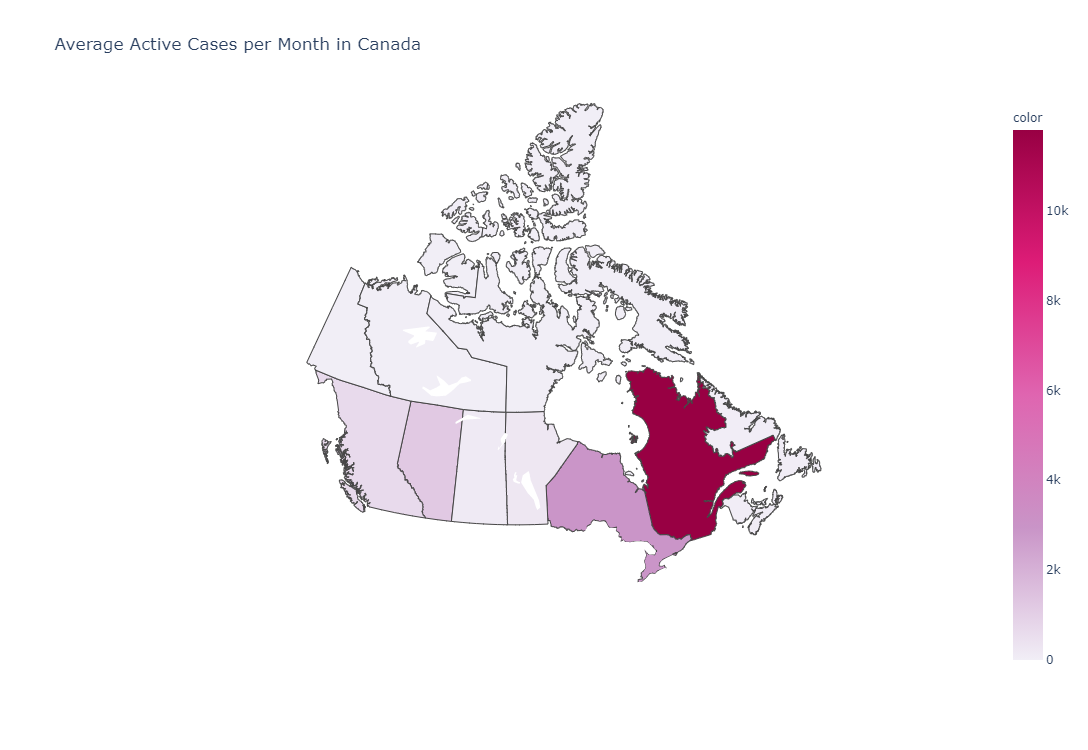

In [14]:
with open("./canada_provinces.geojson", "r") as geo:
    mp = json.load(geo)

#colorlist = ['#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a']


#colorlist =['#f7f4f9','#e7e1ef','#d4b9da','#c994c7','#df65b0','#e7298a','#ce1256','#980043','#67001f']

colorlist =['#f1eef6','#c994c7','#df65b0','#dd1c77','#980043']

#Json file requires Provinces to be in 1-13 format
Prov_Select = [6,4,3,10,11,1,7,2,8,5,9,13,12]

#### USER INTERFACE IN CODE###

#Month Interval
Min=3
Max=10

##Fig Type Options - 'Active Cases' / 'Deaths' / 'Recovered' / 'Tests'
FigType='Active Cases' 
PerCapita='No'
Per_No=1000000

ActiveCasesSelect = ActiveCases.copy()
ActiveCasesSelect.rename(columns={'BC':6,'AB': 4,'SK':3,'MB':10,'ON':11,'QB':1,'NB':7,'NS':2,'PEI':8,'NL':5,'YK':9,'NWT':13,'NUN':12},inplace=True)
ActiveCasesSelect = ActiveCasesSelect.loc[(ActiveCasesSelect.index >= Min)&(ActiveCasesSelect.index <= Max)]
ConfirmedCasesSelect = ConfirmedCases.copy()
ConfirmedCasesSelect.rename(columns={'BC':6,'AB': 4,'SK':3,'MB':10,'ON':11,'QB':1,'NB':7,'NS':2,'PEI':8,'NL':5,'YK':9,'NWT':13,'NUN':12},inplace=True)
ConfirmedCasesSelect = ConfirmedCasesSelect.loc[(ConfirmedCasesSelect.index >= Min)&(ConfirmedCasesSelect.index <= Max)]
CovidDeathsSelect = CovidDeaths.copy()
CovidDeathsSelect.rename(columns={'BC':6,'AB': 4,'SK':3,'MB':10,'ON':11,'QB':1,'NB':7,'NS':2,'PEI':8,'NL':5,'YK':9,'NWT':13,'NUN':12},inplace=True)
CovidDeathsSelect = CovidDeathsSelect.loc[(CovidDeathsSelect.index >= Min)&(CovidDeathsSelect.index <= Max)]
CovidTestsSelect = CovidTests.copy()
CovidTestsSelect.rename(columns={'BC':6,'AB': 4,'SK':3,'MB':10,'ON':11,'QB':1,'NB':7,'NS':2,'PEI':8,'NL':5,'YK':9,'NWT':13,'NUN':12},inplace=True)
CovidTestsSelect = CovidTestsSelect.loc[(CovidTestsSelect.index >= Min)&(CovidTestsSelect.index <= Max)]
PopulationDataSelect = PopulationData.copy()
PopulationDataSelect.rename(columns={'BC':6,'AB': 4,'SK':3,'MB':10,'ON':11,'QB':1,'NB':7,'NS':2,'PEI':8,'NL':5,'YK':9,'NWT':13,'NUN':12},inplace=True)

dfA = pd.Series(ActiveCasesSelect[Prov_Select].mean().sort_values(ascending=False))
dfA.index.name='Province'
dfA.name='Avg Active Cases'

    
dfC = pd.Series(ConfirmedCasesSelect[Prov_Select].sum().sort_values(ascending=False))
dfC.index.name='Province'
dfC.name='Avg Confirmed Cases'
    
dfD = pd.Series(CovidDeathsSelect[Prov_Select].sum().sort_values(ascending=False))
dfD.index.name='Province'
dfD.name='Avg Active Cases'
    
dfT = pd.Series(CovidTestsSelect[Prov_Select].sum().sort_values(ascending=False))
dfT.index.name='Province'
dfT.name='Total Covid Tests'
        
dfANorm = pd.Series(((ActiveCasesSelect[Prov_Select]/PopulationDataSelect[Prov_Select])*Per_No).mean().sort_values(ascending=False))
dfANorm.index.name='Province'
dfANorm.name='Avg Active Cases'
    
dfCNorm = pd.Series(((ConfirmedCasesSelect[Prov_Select]/PopulationDataSelect[Prov_Select])*Per_No).sum().sort_values(ascending=False))
dfCNorm.index.name='Province'
dfCNorm.name='Avg Confirmed Cases'
    
dfDNorm = pd.Series(((CovidDeathsSelect[Prov_Select]/PopulationDataSelect[Prov_Select])*Per_No).sum().sort_values(ascending=False))
dfDNorm.index.name='Province'
dfDNorm.name='Avg Active Cases'
    
dfTNorm = pd.Series(((CovidDeathsSelect[Prov_Select]/PopulationDataSelect[Prov_Select])*Per_No).sum().sort_values(ascending=False))
dfTNorm.index.name='Province'
dfTNorm.name='Total Covid Tests'

if PerCapita =='No':
    if FigType =='Active Cases':
        fig = px.choropleth(dfA,locations=dfA.index,featureidkey="properties.cartodb_id",geojson=mp,color=dfA.values,color_continuous_scale=colorlist,scope='north america',title='Average Active Cases per Month in Canada',locationmode='geojson-id')
    elif FigType =='Confirmed':
        fig = px.choropleth(dfB,locations=dfB.index,featureidkey="properties.cartodb_id",geojson=mp,color=dfB.values,color_continuous_scale=colorlist,scope='north america',title='Total Covid Deaths in Canada',locationmode='geojson-id')
    elif FigType =='Deaths':
        fig = px.choropleth(dfC,locations=dfC.index,featureidkey="properties.cartodb_id",geojson=mp,color=dfC.values,color_continuous_scale=colorlist,scope='north america',title='Total Covid Deaths in Canada',locationmode='geojson-id')
    elif FigType =='Tests':
        fig = px.choropleth(dfD,locations=dfD.index,featureidkey="properties.cartodb_id",geojson=mp,color=dfD.values,color_continuous_scale=colorlist,scope='north america',title='Total Covid Deaths in Canada',locationmode='geojson-id')
if PerCapita =='Yes':
    if FigType =='Active Cases':
        fig = px.choropleth(dfANorm,locations=dfANorm.index,featureidkey="properties.cartodb_id",geojson=mp,color=dfANorm.values,color_continuous_scale=colorlist,scope='north america',title='Average Active Cases per Month in Canada',locationmode='geojson-id')
    elif FigType =='Confirmed':
        fig = px.choropleth(dfBNorm,locations=dfBNorm.index,featureidkey="properties.cartodb_id",geojson=mp,color=dfBNorm.values,color_continuous_scale=colorlist,scope='north america',title='Total Covid Deaths in Canada',locationmode='geojson-id')
    elif FigType =='Deaths':
        fig = px.choropleth(dfCNormlocations=dfCNorm.index,featureidkey="properties.cartodb_id",geojson=mp,color=dfCNorm.values,color_continuous_scale=colorlist,scope='north america',title='Total Covid Deaths in Canada',locationmode='geojson-id')
    elif FigType =='Tests':
        fig = px.choropleth(dfDNorm,locations=dfDNorm.index,featureidkey="properties.cartodb_id",geojson=mp,color=dfDNorm.values,color_continuous_scale=colorlist,scope='north america',title='Total Covid Deaths in Canada',locationmode='geojson-id')

fig.update_layout(height=750,width=1000)
fig.update_geos(showcountries=False, showcoastlines=False,showland=False, fitbounds="locations",subunitcolor='white')
fig.show()

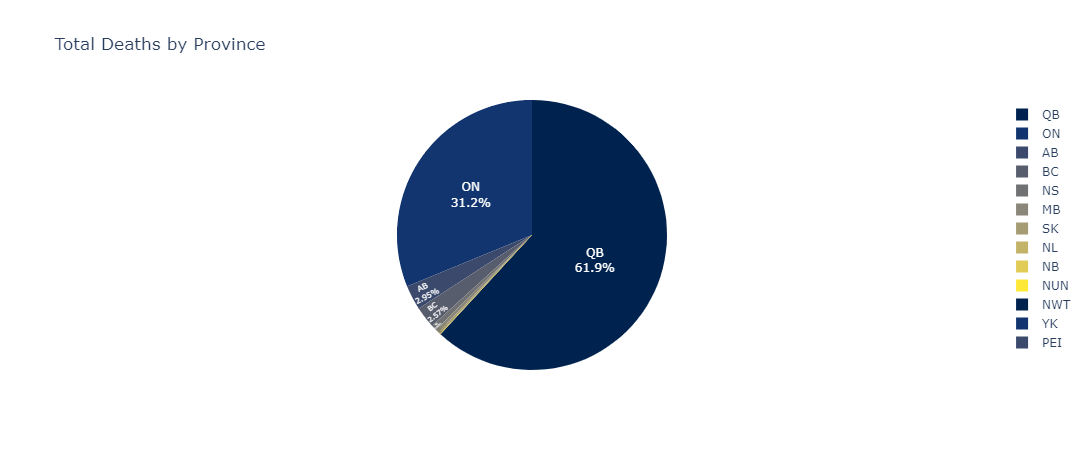

In [15]:
dfD.rename(index={6:'BC',4:'AB',3:'SK',10:'MB',11:'ON',1:'QB',7:'NB',2:'NS',8:'PEI',5:'NL',9:'YK',13:'NWT',12:'NUN'},inplace=True)
fig = px.pie(dfD, values=dfD.values, names=dfD.index, color=dfD.index,title='Total Deaths by Province',color_discrete_sequence=px.colors.sequential.Cividis)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout()
fig.show()

## ADDITIONAL CHARTS - GEO MAP AND PIE CHARTS

- Map chart used to illustrate Average Active Cases (Mar-Oct 2020) by province
    * Quebec has had the highest average active cases per month in Canada
    * Other provinces that have had high active cases counts are ON/AB/BC
- Pie chart used to illustrate COVID-19 Deaths % by province
    * During first wave - QB/ON had over 95% of total COVID-19 deaths in Canada
    * During (currently active) second wave - COVID-19 deaths are now more evenly spreadout in Canada: QB/ON/AB/BC

## CONCLUSION
***

#### The guiding question was to determine if Provinces that had loosened restrictions earlier than other provinces have seen higher active cases and deaths than Provinces that have not loosened restrictions.
***

#### The answer to this question is a resounding YES!
***

- While all provinces experienced significant COVID-19 active cases in first wave (Mar-May 2020) - only the lenient provinces as summarized in COVID-19 policy overview are currently experiencing a resurgence of COVID-19 in the current second wave

- Stage 2 Re-opening was a significant policy change for all provinces - but was a particular 'back to normal' strategy for the lenient West/East categories
- COVID-19 active cases started to increase soon after this policy change

- Over 95% of COVID-19 Deaths were in Ontario & Quebec during first wave - but because of loosening of Policy Restrictions after Stage 2 - the % of COVID-19 deaths is becoming more evenly distributed between the lenient provinces

- Travel Restrictions in Atlantic Canada have been incredibly successful in limiting COVID-19 active cases and virtually stopping all COVID-19 related deaths in the second wave. Nova Scotia is currently the only province in Atlantic Canada that allows other non-Atlantic Canadians to enter but requires 14 day self-isolation. New Brunswick, Prince Edward Island and Newfoundland all limit entry to their provinces

- Follow-up on this analyis should include:
    * Part 1: Demographics
    * Demographics of COVID-19 deaths? COVID-19 deaths have been particularly high for older populations. Did provinces with older populations have higher per capita deaths?
    * Much of the older population resides in long term care homes - how did COVID-19 impact provinces with high numbers of long term care homes? What was rthe active case and death toll in long term care homes? What specific provincial policies helped in limiting long term care home COVID-19 deaths?
    * Part 2: Travel Restriction Effectiveness
    * New Brunswick is part of the Atlantic Bubble - but is currently seeing rising active cases. This is likely tied to its proximity to Quebec. Travel restrictions appear to be a deciding factor in limiting COVID-19 spread and death toll
    * For future pandemics - travel bans or provincial 'bubbles' could be the key to limiting the spread. This dataset should be heavily investigated on its effectiveness
    * The enforcement of travel restrictions and/or 14 day self-isolation would be an interesting area of study. For example - University students are returning to Atanltic Canada are requried to self isolate. How effective has that been? 
    * Part 3: COVID-19 Testing
    * How does the magnitude of COVID-19 tests impact the active case numbers? Are active cases in Atlantic Canada supressed because of lack of testing or persons not wanting to be 'outed' as having COVID-19?
    * The Asymptomatic dataset shed some light here but more data is required to tie to individual provinces and overall testing


## Guiding Question #2
***
#### Excess deaths are the number of deaths that are elevated over historical averages. Stringent restrictions have been considered as a factor in higher excess death counts.
The questions we want to investigate are:
-  How has COVID-19 impacted overall death tolls across each province?
##### Data Source: Weekly death counts, by age group and sex and Data on COVID-19 in Canada

***
Weekly death counts: This dataset provides provisional mortality statistics as provided by individual Canadian provinces to Statistics Canada. The data is structured in tabular csv format and is updated weekly. Data columns include province, age at time of death, gender, number of deaths.Contains information licenced under the open government licence – Canada https://open.canada.ca/en/open-government-licence-canada


##### Part 1 (DATA WRANGLING)
***
- Import Data - Historical Death Data by Province
- Drop columns that are not needed for analysis
- Data source uses 'Province Description ID' to tag Provinces - matched ID's to Province Abbreviations for easier data wrangling (Used Dictionary)

- Merged Province abbreviation dictionary and removed older column ; using Province abbrevitations in data table
- Matched index of 'CAN' (Canada) and dropped these rows - analysis is on Provinces only
- Renamed columns so that each is a better description - important for user analysis of data
- Created 'Year' and 'Month' column so that tables and be pivot'ed to total Deaths by Month
- 3 key datatables:
    * Historical Deaths (2017-2019 average by month)
    * Current Deaths (2020 average by month)
    * Covid Deaths (2020 average by month - from COVID Datatable - Guiding Question 1)

In [16]:
#IMPORT EXCESS DEATH DATATABLE

deathdata = pd.read_csv("./Canadadeaths.csv",dtype = {'REF_Date':str,'GEO':str,'DGUID':str,'Age at time of death':str,'Sex':str,'Characteristics':str,'UOM':str,'UOM_ID':int,'SCALAR_FACTOR':str,'SCALAR_ID':str,'VECTOR':str,'COORDINATE':str,'VALUE':str,'STATUS':str,'SYMBOL':str,'TERMINATED':str,'DECIMALS':str})

#note - had to import values as string - will convert when drop np.NaNs

deathdata = deathdata.drop(['DGUID','Characteristics','UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','VECTOR','COORDINATE','SYMBOL','STATUS','TERMINATED','DECIMALS'],axis=1)

provincedict2 = {'Canada, place of occurrence':'CAN','Newfoundland and Labrador, place of occurrence':'NL','Prince Edward Island, place of occurrence':'PEI','Nova Scotia, place of occurrence':'NS','New Brunswick, place of occurrence':'NB','Quebec':'QB','Ontario, place of occurrence':'ON','Manitoba, place of occurrence':'MB','Saskatchewan, place of occurrence':'SK','Alberta, place of occurrence':'AB','British Columbia, place of occurrence':'BC','Yukon, place of occurrence':'YK','Northwest Territories, place of occurrence':'NWT','Nunavut, place of occurrence':'NUN'}


province2 = pd.Series(provincedict2)
province2.index.name='GEO'
province2.name='Province'

deathdata = pd.merge(deathdata,province2,on='GEO',how='outer')

#rearrange table
deathdata = deathdata[['Province','REF_DATE','Age at time of death','Sex','VALUE']]


#remove Canada (just want province data)
indexdrop2 = deathdata[deathdata['Province'] == 'CAN' ].index
deathdata = deathdata.drop(indexdrop2,axis=0)

#update REF_DATE and VALUES in deathdata dataframe to datetime and int. Also rename REF_DATE to date
deathdata.rename(columns={'REF_DATE':'date'},inplace=True)
deathdata.rename(columns={'VALUE':'Total Deaths'},inplace=True)

#remove Canada (just want province data)
indexdrop3 = deathdata[deathdata['Total Deaths'].isna() ].index
deathdata = deathdata.drop(indexdrop3,axis=0)

deathdata['Total Deaths'] = deathdata['Total Deaths'].fillna(0)
deathdata['Total Deaths'] = pd.to_numeric(deathdata['Total Deaths'])
deathdata['date'] = pd.to_datetime(deathdata['date'],yearfirst=True)

#Create Historical & Current Death Data Set
indexdrop4 = deathdata[((deathdata['date'] > datetime(2020,1,1)))|((deathdata['date'] < datetime(2017,1,1)))].index
indexdrop5 = deathdata[deathdata['date'] < datetime(2020,1,1)].index

deathdatacurrent = deathdata.copy()
deathdatahistorical = deathdata.copy()

deathdatahistorical = deathdatahistorical.drop(indexdrop4,axis=0)
deathdatacurrent = deathdatacurrent.drop(indexdrop5,axis=0)

deathdatahistorical['Year'] = pd.DatetimeIndex(deathdatahistorical.loc[:,('date')]).year
deathdatahistorical['Month'] = pd.DatetimeIndex(deathdatahistorical.loc[:,('date')]).month
deathdatacurrent['Year'] = pd.DatetimeIndex(deathdatacurrent.loc[:,('date')]).year
deathdatacurrent['Month'] = pd.DatetimeIndex(deathdatacurrent.loc[:,('date')]).month

HistoricalDeaths = pd.pivot_table(deathdatahistorical,index='Month',columns='Province',values='Total Deaths',aggfunc=np.sum)
CurrentDeaths = pd.pivot_table(deathdatacurrent,index='Month',columns='Province',values='Total Deaths',aggfunc=np.sum)

#DivideHistoricalDeaths by 3 to get accurate 3 year average
HistoricalDeaths = (HistoricalDeaths/3).astype(int)

print('Historical Deaths')
display(HistoricalDeaths)
print('Current Deaths')
display(CurrentDeaths)
print('Covid Deaths')
display(CovidDeaths)

Historical Deaths


Province     AB     BC    MB    NB    NL    NS  NUN  NWT     ON  PEI    SK
Month                                                                     
1          8953  13686  3826  2646  1800  3393   53   66  37263  453  3393
2          8306  12766  3653  2486  1606  3253   40   66  35886  426  3126
3          9160  14760  4103  2886  2046  3740   46   80  39446  500  3540
4          8580  12826  3740  2626  1860  3323   66   80  34916  453  3073
5          7800  11353  3333  2386  1546  2920   56   86  31306  380  2720
6          8766  12820  3656  2580  1773  3200   33   66  35500  466  3266
7          7980  12133  3380  2306  1533  3013   60   86  32446  373  2906
8          8040  11733  3346  2373  1593  3000   26   73  32440  433  3080
9          8926  12820  3760  2586  1713  3220   40   66  35826  486  3326
10         7946  11753  3553  2320  1546  2786   46   66  31860  380  2973
11         8833  12880  3626  2530  1760  3280   66   73  36333  453  3206
12        10006  14136  4193  2846  1940  3673   46  106  39653  466  3606

Current Deaths


Province     AB     BC    MB    NB    NL    NS  NUN  NWT     ON  PEI    SK
Month                                                                     
1          9120  13260  4110  2440  1740  3200   20   60  36680  420  3420
2         10460  15390  4300  2910  2260  3960  100   80  42320  540  3560
3          8940  13020  3360  2260  1580  3180   40   60  32780  420  3140
4          8760  12920  3460  2290  1600  3180    0  120  36840  360  3000
5         10460  14840  4120  2640  1980  3740   80  100  39060  580  3520
6          8180  11380  3160  1750  1420  2640   40   80  25350  400  2980
7          8260  11700  3020  1640  1460  2380    0   80  20360  340  2740
8          1960   2980   740   340   300   480    0   40   3990  100   520

Covid Deaths


AB    BC    MB   NB   NL    NS  NUN  NWT      ON  PEI      QB   SK  \
Month                                                                         
1       NaN   0.0   NaN  NaN  NaN   NaN  NaN  NaN     0.0  NaN     NaN  NaN   
2       NaN   0.0   NaN  NaN  NaN   NaN  NaN  NaN     0.0  NaN     NaN  NaN   
3       9.0  19.0   1.0  0.0  1.0   0.0  0.0  0.0    33.0  0.0    31.0  2.0   
4      80.0  92.0   5.0  0.0  2.0  28.0  0.0  0.0  1049.0  0.0  1828.0  4.0   
5      54.0  53.0   1.0  0.0  0.0  32.0  0.0  0.0  1184.0  0.0  2782.0  5.0   
6      11.0  10.0   0.0  2.0  0.0   3.0  0.0  0.0   406.0  0.0   862.0  2.0   
7      42.0  21.0   1.0  0.0  0.0   1.0  0.0  0.0   103.0  0.0   171.0  5.0   
8      43.0  13.0   6.0  0.0  0.0   1.0  0.0  0.0    36.0  0.0    86.0  6.0   
9      28.0  26.0   6.0  0.0  0.0   0.0  0.0  0.0    37.0  0.0    74.0  0.0   
10     21.0  17.0  20.0  1.0  1.0   0.0  0.0  0.0   198.0  0.0   204.0  1.0   

        YK Month Name  
Month                  
1      NaN        Jan  
2      NaN        Feb  
3      0.0        Mar  
4      0.0        Apr  
5      0.0        May  
6      0.0        Jun  
7      0.0        Jul  
8      0.0        Aug  
9      0.0        Sep  
10     0.0        Oct

##### Part 2 (PREPARING DATA TO CHART)
***
- To plot individual provinces - each province needed to be spliced into it's unique data table
- $\mathrm{Excess  Deaths  Rate}$ can be calculated using this formula
$$
\mathrm{Excess Deaths} = \mathrm{Current Deaths} - \mathrm{Historical Deaths} + \mathrm{Covid Deaths}
$$
- Excess Deaths Rate then needs to be added to each province's data table


In [17]:
#Create data frames for each province with excess deaths rate
#AB Deaths data
data1= [HistoricalDeaths['AB'], CurrentDeaths['AB'],CovidDeaths['AB'] ]
headers = ["Historical", "Current", "Covid"]
dfAB = pd.concat(data1, axis=1, keys=headers)
dfAB["Excess"]=(dfAB['Current']-dfAB['Historical']+dfAB['Covid'])
#BC Deaths data
data2= [HistoricalDeaths['BC'], CurrentDeaths['BC'],CovidDeaths['BC'] ]
headers = ["Historical", "Current", "Covid"]
dfBC = pd.concat(data2, axis=1, keys=headers)
dfBC["Excess"]=(dfBC['Current']-dfBC['Historical']+dfBC['Covid'])
#MB Deaths data
data3= [HistoricalDeaths['MB'], CurrentDeaths['MB'],CovidDeaths['MB'] ]
headers = ["Historical", "Current", "Covid"]
dfMB = pd.concat(data3, axis=1, keys=headers)
dfMB["Excess"]=(dfMB['Current']-dfMB['Historical']+dfMB['Covid'])
#NB Deaths data
data4= [HistoricalDeaths['NB'], CurrentDeaths['NB'],CovidDeaths['NB'] ]
headers = ["Historical", "Current", "Covid"]
dfNB = pd.concat(data4, axis=1, keys=headers)
dfNB["Excess"]=(dfNB['Current']-dfNB['Historical']+dfNB['Covid'])
#NL Deaths data
data5= [HistoricalDeaths['NL'], CurrentDeaths['NL'],CovidDeaths['NL'] ]
headers = ["Historical", "Current", "Covid"]
dfNL = pd.concat(data5, axis=1, keys=headers)
dfNL["Excess"]=(dfNL['Current']-dfNL['Historical']+dfNL['Covid'])
#NS Deaths data
data6= [HistoricalDeaths['NS'], CurrentDeaths['NS'],CovidDeaths['NS'] ]
headers = ["Historical", "Current", "Covid"]
dfNS = pd.concat(data6, axis=1, keys=headers)
dfNS["Excess"]=(dfNS['Current']-dfNS['Historical']+dfNS['Covid'])
#NUN Deaths data
data7= [HistoricalDeaths['NUN'], CurrentDeaths['NUN'],CovidDeaths['NUN'] ]
headers = ["Historical", "Current", "Covid"]
dfNUN = pd.concat(data7, axis=1, keys=headers)
dfNUN["Excess"]=(dfNUN['Current']-dfNUN['Historical']+dfNUN['Covid'])
#NWT Deaths data
data8= [HistoricalDeaths['NWT'], CurrentDeaths['NWT'],CovidDeaths['NWT'] ]
headers = ["Historical", "Current", "Covid"]
dfNWT = pd.concat(data8, axis=1, keys=headers)
dfNWT["Excess"]=(dfNWT['Current']-dfNWT['Historical']+dfNWT['Covid'])
#ON Deaths data
data9= [HistoricalDeaths['ON'], CurrentDeaths['ON'],CovidDeaths['ON'] ]
headers = ["Historical", "Current", "Covid"]
dfON = pd.concat(data9, axis=1, keys=headers)
dfON["Excess"]=(dfON['Current']-dfON['Historical']+dfON['Covid'])
#PEI Deaths data
data10= [HistoricalDeaths['PEI'], CurrentDeaths['PEI'],CovidDeaths['PEI'] ]
headers = ["Historical", "Current", "Covid"]
dfPEI = pd.concat(data10, axis=1, keys=headers)
dfPEI["Excess"]=(dfPEI['Current']-dfPEI['Historical']+dfPEI['Covid'])
#SK Deaths data
data12= [HistoricalDeaths['SK'], CurrentDeaths['SK'],CovidDeaths['SK'] ]
headers = ["Historical", "Current", "Covid"]
dfSK = pd.concat(data12, axis=1, keys=headers)
dfSK["Excess"]=(dfSK['Current']-dfSK['Historical']+dfSK['Covid'])
#Data sets below contain incomplete data sets and will not be included in the analysis
#QB Deaths data
#data11= [HistoricalDeaths['QB'], CurrentDeaths['QB'],CovidDeaths['QB'] ]
#headers = ["Historical", "Current", "Covid"]
#dfQB = pd.concat(data11, axis=1, keys=headers)
#dfQB["Excess"]=(dfQB['Current']-dfQB['Historical']+dfQB['Covid'])
#YK Deaths data
#data13= [HistoricalDeaths['YK'], CurrentDeaths['YK'],CovidDeaths['YK'] ]
#headers = ["Historical", "Current", "Covid"]
#dfYK = pd.concat(data13, axis=1, keys=headers)
#dfYK["Excess"]=(dfYK['Current']-dfYK['Historical']+dfYK['Covid'])


##### Part 3 (VISUALIZATIONS)
***
  Bar Chart representation of excess deaths, historical and current deaths by province
       

In [18]:
###### KEY INTERACTIVE VISUALIZATION ######

line=go.Figure()
fig= go.FigureWidget(data=line)

@interact(Province = ['BC','AB','SK','MB','ON','NB','NS','PEI','NL','NWT','NUN'])
def update_chart(Province = 'AB'):    
    
    fig.data=[]
    fig.layout={}
    fig1= go.Figure(data=[go.Bar(name='Excess', x=dfAB.index.values, y=dfAB['Excess']), go.Bar(name='Historical', x=dfAB.index.values, y=dfAB['Historical']), go.Bar(name='Covid', x=dfAB.index.values, y=dfAB['Covid']),go.Bar(name='Current', x=dfAB.index.values, y=dfAB['Current'])])
    fig2= go.Figure(data=[go.Bar(name='Excess', x=dfBC.index.values, y=dfBC['Excess']), go.Bar(name='Historical', x=dfBC.index.values, y=dfBC['Historical']), go.Bar(name='Covid', x=dfBC.index.values, y=dfBC['Covid']),go.Bar(name='Current', x=dfBC.index.values, y=dfBC['Current'])])
    fig3= go.Figure(data=[go.Bar(name='Excess', x=dfMB.index.values, y=dfMB['Excess']), go.Bar(name='Historical', x=dfMB.index.values, y=dfMB['Historical']), go.Bar(name='Covid', x=dfMB.index.values, y=dfMB['Covid']),go.Bar(name='Current', x=dfMB.index.values, y=dfMB['Current'])])
    fig4= go.Figure(data=[go.Bar(name='Excess', x=dfSK.index.values, y=dfSK['Excess']), go.Bar(name='Historical', x=dfSK.index.values, y=dfSK['Historical']), go.Bar(name='Covid', x=dfSK.index.values, y=dfSK['Covid']),go.Bar(name='Current', x=dfSK.index.values, y=dfSK['Current'])])
    fig5= go.Figure(data=[go.Bar(name='Excess', x=dfON.index.values, y=dfON['Excess']), go.Bar(name='Historical', x=dfON.index.values, y=dfON['Historical']), go.Bar(name='Covid', x=dfON.index.values, y=dfON['Covid']),go.Bar(name='Current', x=dfON.index.values, y=dfON['Current'])])
    fig6= go.Figure(data=[go.Bar(name='Excess', x=dfNB.index.values, y=dfNB['Excess']), go.Bar(name='Historical', x=dfNB.index.values, y=dfNB['Historical']), go.Bar(name='Covid', x=dfNB.index.values, y=dfNB['Covid']),go.Bar(name='Current', x=dfNB.index.values, y=dfNB['Current'])])
    fig7= go.Figure(data=[go.Bar(name='Excess', x=dfNS.index.values, y=dfNS['Excess']), go.Bar(name='Historical', x=dfNS.index.values, y=dfNS['Historical']), go.Bar(name='Covid', x=dfNS.index.values, y=dfNS['Covid']),go.Bar(name='Current', x=dfNS.index.values, y=dfNS['Current'])])
    fig8= go.Figure(data=[go.Bar(name='Excess', x=dfPEI.index.values, y=dfPEI['Excess']), go.Bar(name='Historical', x=dfPEI.index.values, y=dfPEI['Historical']), go.Bar(name='Covid', x=dfPEI.index.values, y=dfPEI['Covid']),go.Bar(name='Current', x=dfPEI.index.values, y=dfPEI['Current'])])
    fig9= go.Figure(data=[go.Bar(name='Excess', x=dfNL.index.values, y=dfNL['Excess']), go.Bar(name='Historical', x=dfNL.index.values, y=dfNL['Historical']), go.Bar(name='Covid', x=dfNL.index.values, y=dfNL['Covid']),go.Bar(name='Current', x=dfNL.index.values, y=dfNL['Current'])])
    fig10= go.Figure(data=[go.Bar(name='Excess', x=dfNWT.index.values, y=dfNWT['Excess']), go.Bar(name='Historical', x=dfNWT.index.values, y=dfNWT['Historical']), go.Bar(name='Covid', x=dfNWT.index.values, y=dfNWT['Covid']),go.Bar(name='Current', x=dfNWT.index.values, y=dfNWT['Current'])])
    fig11= go.Figure(data=[go.Bar(name='Excess', x=dfNUN.index.values, y=dfNUN['Excess']), go.Bar(name='Historical', x=dfNUN.index.values, y=dfNUN['Historical']), go.Bar(name='Covid', x=dfNUN.index.values, y=dfNUN['Covid']),go.Bar(name='Current', x=dfNUN.index.values, y=dfNUN['Current'])])

    if Province== 'AB':
        fig.add_trace(fig1.data[0])
        fig.add_trace(fig1.data[1])
        fig.add_trace(fig1.data[2])
        fig.add_trace(fig1.data[3])
        fig.update_layout(barmode='stack')
    elif Province== 'BC':
        fig.add_trace(fig2.data[0])
        fig.add_trace(fig2.data[1])
        fig.add_trace(fig2.data[2])
        fig.add_trace(fig2.data[3])
        fig.update_layout(barmode='stack')
    elif Province== 'MB':
        fig.add_trace(fig3.data[0])
        fig.add_trace(fig3.data[1])
        fig.add_trace(fig3.data[2])
        fig.add_trace(fig3.data[3])
        fig.update_layout(barmode='stack')
    elif Province== 'SK':
        fig.add_trace(fig4.data[0])
        fig.add_trace(fig4.data[1])
        fig.add_trace(fig4.data[2])
        fig.add_trace(fig4.data[3])
        fig.update_layout(barmode='stack')
    elif Province== 'ON':
        fig.add_trace(fig5.data[0])
        fig.add_trace(fig5.data[1])
        fig.add_trace(fig5.data[2])
        fig.add_trace(fig5.data[3])
        fig.update_layout(barmode='stack')
    elif Province== 'NB':
        fig.add_trace(fig6.data[0])
        fig.add_trace(fig6.data[1])
        fig.add_trace(fig6.data[2])
        fig.add_trace(fig6.data[3])
        fig.update_layout(barmode='stack')
    elif Province== 'NS':
        fig.add_trace(fig7.data[0])
        fig.add_trace(fig7.data[1])
        fig.add_trace(fig7.data[2])
        fig.add_trace(fig7.data[3])
        fig.update_layout(barmode='stack')
    elif Province== 'PEI':
        fig.add_trace(fig8.data[0])
        fig.add_trace(fig8.data[1])
        fig.add_trace(fig8.data[2])
        fig.add_trace(fig8.data[3])
        fig.update_layout(barmode='stack')
    elif Province== 'NL':
        fig.add_trace(fig9.data[0])
        fig.add_trace(fig9.data[1])
        fig.add_trace(fig9.data[2])
        fig.add_trace(fig9.data[3])
        fig.update_layout(barmode='stack')
    elif Province== 'NWT':
        fig.add_trace(fig10.data[0])
        fig.add_trace(fig10.data[1])
        fig.add_trace(fig10.data[2])
        fig.add_trace(fig10.data[3])
        fig.update_layout(barmode='stack')
    elif Province== 'NUN':
        fig.add_trace(fig11.data[0])
        fig.add_trace(fig11.data[1])
        fig.add_trace(fig11.data[2])
        fig.add_trace(fig11.data[3])
        fig.update_layout(barmode='stack')

    fig.update_layout(title="2020 Deaths data for {0}".format(Province))
    fig.update_layout(barmode='stack')
    fig.show()
    


interactive(children=(Dropdown(description='Province', index=1, options=('BC', 'AB', 'SK', 'MB', 'ON', 'NB', '…

## KEY OBSERVATIONS FROM INTERACTIVE BAR CHART

Excess death rates have not been affected by COVID-19 in the different provinces. Most provinces in 2020 saw negative excess death rates showing that COVID-19 did not increase death rate. COVID deaths are very low and barely visible in all the charts, showing COVID numbers are low  compared to current and historical deaths

##### Part 3- (PREPARING DATA TO CHART)
To better visualize how each province did we decided to take a look at total death rate in 2020 by province, so we reorganized the data to be able to do this. To do this we need to
- Put provincial data sets together to get one data frame
- Calculate sum of overall death rate per province

In [19]:
# Create a data frame with Excess deaths rate for all provinces to visualize which province had the highest excess death rate
dataex= [dfAB['Excess'], dfBC['Excess'],dfMB['Excess'], dfSK['Excess'], dfON['Excess'], dfNB['Excess'], dfNS['Excess'], dfPEI['Excess'], dfNL['Excess'], dfNWT['Excess'], dfNUN['Excess']]
headers = ['AB','BC','MB', 'SK','ON','NB','NS','PEI','NL','NWT','NUN']
excess = pd.concat(dataex, axis=1, keys=headers)
ex2=excess.transpose()
ex2['Totalexcessdeaths']=ex2.sum(axis=1)
ex2=ex2.drop(ex2.columns.to_series()[0:12], axis=1)
ex2.index.name="Province"
ex2

Month     Totalexcessdeaths
Province                   
AB                  -3527.0
BC                  -6379.0
MB                  -3684.0
SK                  -2661.0
ON                 -39012.0
NB                  -4235.0
NS                  -3531.0
PEI                  -405.0
NL                  -2008.0
NWT                     9.0
NUN                  -127.0

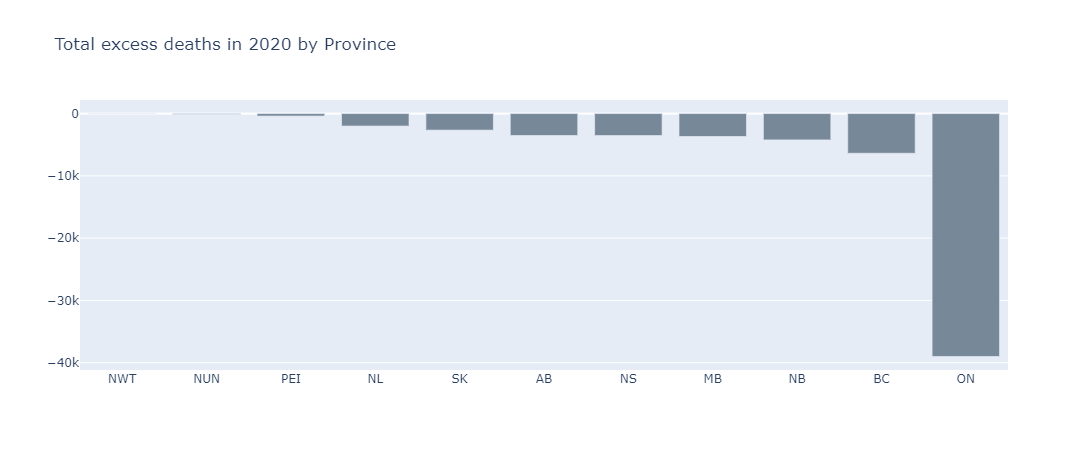

In [20]:
#Plot the findings
colors = ['lightslategray',] * 11
colors[9] = 'crimson'

fig = go.Figure(data=[go.Bar(
    x=ex2.index.values,
    y=ex2['Totalexcessdeaths'],
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(title_text='Total excess deaths in 2020 by Province')
fig.update_layout(xaxis={'categoryorder':'total descending'})

Let's take a closer look!

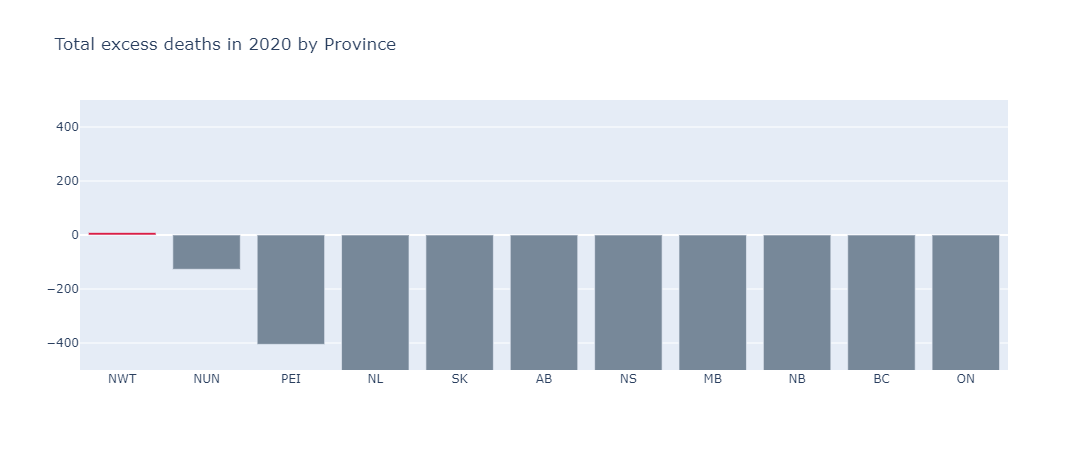

In [21]:
#Plot the findings with a differnt scale to better visualize most affected provinces
colors = ['lightslategray',] * 11
colors[9] = 'crimson'

fig = go.Figure(data=[go.Bar(
    x=ex2.index.values,
    y=ex2['Totalexcessdeaths'],
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(title_text='Total excess deaths in 2020 by Province')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.update_yaxes(range=(-500, 500),constrain='domain')

## KEY OBSERVATIONS FROM SUMMARY BAR CHART

Excess death rates have not been affected by COVID-19 in the different provinces. Most provinces in 2020 saw negative excess death rates showing that COVID-19 did not increase death rate. The NWT is the only province where we see a positive excess death rate but the number is very low and not very significant. Number of cases in NWT and testing was low so these findings are interesting.

## CONCLUSION
***

#### The guiding question was to determine  COVID-19 has impacted overall death tolls across each province
#### Fortunately the Canadian provinces have not seen a great impact on the overall death tolls since the pandemic
***

- While all provinces experienced significant COVID-19 active cases in first wave only the overall death tolls have not been affected. The only province that showed a slight rise in death tolls since the pandemic is NWT which is intereseting considering the number of cases in this province was low.
- Provinces regardless of their restricitons stringent or lenient all saw no excess death rates due to COVID-19 showing that all the provinces approaches helped and contributed to protecting lives of the population
- Taking measures such as emtying hospital beds, discharging patients, moving health care to virtual except for when essential and cancellation of elective surgeries overall still did not impact death rates in the provinces and did not have a negative impact on life expectations for the Canadian provinces. These measures probably contributed positively to slowing down the spread and keeping death toll due to COVID-19 low.
- Excess death rates in the provinces are all negative showing that in general compared to hsitorical deaths the current deaths are lower in most provinces especially in provinces such as Ontario. Although the decrease in death rates in general is not COVID-19 related it may be intersting to analyze why current death rates are higher than current death rates

- Follow-up on this analyis should include:
    * A month to month analysis of death rates in 2020 compared to monthly death rates in the last 5 years may be intersting and may show a differnce in excess death rates due to COVID-19 Province by Province
    * Analysis of monthly excess death rates per provinince in 2020 compared to monthly death rates in the last 5 years for population in the age group 60-90. We may say an increased death rate here due to COVID if we focus on population that was most affected by COVID deaths
    * Closer look into NWT death rates while keeping in mind number of COVID cases and COVID tests in the province may shed some light on the very small increase in death rates

## Guiding Question #3
***
#### After the drop in employment rate that Canadians experienced during the first wave of the COVID-19 pandemic in early April. 
The question we want to investigate is
- Has the employment rate gone back up, and which provinces have seen a higher rate of job recovery?
##### Data Source: Labour force characteristics by province, monthly, seasonally adjusted.


***
This dataset is in tabular CSV format. Data columns include: sex, age group, geographical location and the month.

##### Part 1 (DATA WRANGLING)
***
- Import Data 
- Drop columns that are not needed for analysis
- Data source uses 'Province Description ID' to tag Provinces - matched ID's to Province Abbreviations for easier data wrangling (Used Dictionary)
- Replacing all x values and .. with 0
- Renaming columns and converting columns to the right data types

In [22]:
employmentstatistics = pd.read_csv('employmentstatistics.csv')

# We dont need all the columns and rows. Droping the rows we dont need using their indexes
employmentstatistics = employmentstatistics.drop(employmentstatistics.index[99:128])
employmentstatistics = employmentstatistics.drop(employmentstatistics.index[0])

#dropping aggregation columns
employmentstatistics = employmentstatistics.drop(['Goods producing industries 8','Industrial aggregate including unclassified businesses 6 7','Industrial aggregate excluding unclassified businesses 6 7'], axis = 1)
#employmentstatistics

In [23]:
#We are using the data for all the provinces so we have to drop the totals  
dropcan = employmentstatistics[employmentstatistics['Geography'] == 'CAN' ].index
employmentstatistics = employmentstatistics.drop(dropcan,axis=0)

In [24]:
#replacing all x values and .. with 0
employmentstatistics = employmentstatistics.replace({'..': 0, 'x': 0,'F':0})

#Renaming the Geography and Reference period to Province and Months
employmentstatistics = employmentstatistics.rename(columns = {'Geography':'Province', 'Reference period':'Date'})
empcolumns = ['Forestry, logging and support 9', 'Mining, quarrying, and oil and gas extraction', 'Utilities', 'Construction', 'Manufacturing', 'Service producing industries 10', 'Trade 11', 'Transportation and warehousing', 'Information and cultural industries', 'Finance and insurance', 'Real estate and rental and leasing', 'Professional, scientific and technical services', 'Management of companies and enterprises', 'Administrative and support, waste management and remediation services', 'Educational services', 'Health care and social assistance', 'Arts, entertainment and recreation', 'Accommodation and food services', 'Other services (except public administration)', 'Public administration', 'Unclassified businesses 7']

#Convert the Columns to numeric values
employmentstatistics = employmentstatistics.replace(',','', regex=True)
employmentstatistics [empcolumns] = employmentstatistics[empcolumns].apply(pd.to_numeric)

#convert date from Object to datetime
employmentstatistics['Date'].replace({'Jan-20': '2020-01', 'Feb-20': '2020-02','Mar-20':'2020-03','Apr-20': '2020-04', 'May-20': '2020-05','Jun-20':'2020-06','Jul-20': '2020-07'},inplace=True)
employmentstatistics['Date'] = pd.to_datetime(employmentstatistics['Date'])
employmentstatistics['Date'] = pd.to_datetime(employmentstatistics['Date']).dt.strftime('%Y-%m')


#create new column with the total employed for each month
employmentstatistics["Total"] = employmentstatistics.sum(axis=1)
employmentstatistics


Province     Date  Forestry, logging and support 9  \
8       NFL  2020-01                                0   
9       NFL  2020-02                                0   
10      NFL  2020-03                                0   
11      NFL  2020-04                                0   
12      NFL  2020-05                                0   
..      ...      ...                              ...   
94      NNT  2020-03                                0   
95      NNT  2020-04                                0   
96      NNT  2020-05                                0   
97      NNT  2020-06                                0   
98      NNT  2020-07                                0   

    Mining, quarrying, and oil and gas extraction  Utilities  Construction  \
8                                               0          0         12574   
9                                               0          0         13025   
10                                              0          0         12275   
11                                              0          0          9545   
12                                              0          0         10436   
..                                            ...        ...           ...   
94                                              0          0           642   
95                                              0          0           524   
96                                              0          0           507   
97                                              0          0           744   
98                                              0          0          1030   

    Manufacturing  Service producing industries 10  Trade 11  \
8            6220                           171826     36542   
9            6270                           171159     35950   
10           5950                           163351     33588   
11           4912                           146010     29612   
12              0                           145385     31371   
..            ...                              ...       ...   
94              0                            14974      1805   
95              0                            13882      1665   
96              0                            13509      1771   
97              0                            13796      1687   
98              0                            14029      1796   

    Transportation and warehousing  ...  \
8                             9497  ...   
9                             9175  ...   
10                            8741  ...   
11                            8461  ...   
12                            8644  ...   
..                             ...  ...   
94                             920  ...   
95                             841  ...   
96                             785  ...   
97                             823  ...   
98                             736  ...   

    Management of companies and enterprises  \
8                                       804   
9                                       859   
10                                      772   
11                                      727   
12                                      639   
..                                      ...   
94                                        0   
95                                        0   
96                                        0   
97                                        0   
98                                        0   

    Administrative and support, waste management and remediation services  \
8                                                5525                       
9                                                5602                       
10                                               5333                       
11                                               4979                       
12                                               4944                       
..                                                ...               

##### Part 2 (PREPARING DATA FOR VISUALIZATION)

In [25]:
import matplotlib.dates as mdates
from datetime import datetime


empNFL = employmentstatistics.loc[(employmentstatistics.Province == 'NFL')]
empPEI = employmentstatistics.loc[(employmentstatistics.Province == 'PEI')]
empNVS = employmentstatistics.loc[(employmentstatistics.Province == 'NVS')]
empNBS = employmentstatistics.loc[(employmentstatistics.Province == 'NBS')]
empQBC = employmentstatistics.loc[(employmentstatistics.Province == 'QBC')]
empONT = employmentstatistics.loc[(employmentstatistics.Province == 'ONT')]
empMTB = employmentstatistics.loc[(employmentstatistics.Province == 'MTB')]
empSASK = employmentstatistics.loc[(employmentstatistics.Province == 'SASK')]
empAB = employmentstatistics.loc[(employmentstatistics.Province == 'AB')]
empBC = employmentstatistics.loc[(employmentstatistics.Province == 'BC')]
empYK = employmentstatistics.loc[(employmentstatistics.Province == 'YK')]
empNWT = employmentstatistics.loc[(employmentstatistics.Province == 'NWT')]
empNNT = employmentstatistics.loc[(employmentstatistics.Province == 'NNT')]
#emptotal = employmentstatistics.loc[(employmentstatistics.Province == 'NNT')]


#display(empAB.dtypes)


##### Part 3 (DATA VISUALIZATION)

**The graph will show the rise of emploment and unemployment accross the various industries 

In [27]:

line=go.Figure()
fig= go.FigureWidget(data=line)


@interact(Country_total = ['Yes', 'No'],Industry = empcolumns, Provinces = ['ALL','NFL','PEI','NVS','NBS','QBC','ONT','MTB','SASK','AB','BC','YK','NWT','NNT'],AutoScale = ['Yes','No'],yScale=(0,100,50))

def plot_graph(Country_total = 'No',Industry ='Total', Provinces='ALL', AutoScale = 'Yes', yscale=100):
    
    fig.data=[]
    fig.layout={}
    
    if Country_total == 'No':
        fig1 = go.Figure(data=go.Scatter(x=empNFL.Date, y=((empNFL[Industry]/empNFL['Total'])*100).round(1),marker=dict(size=4,color='#ff0000'),mode="markers+lines",name='NFL'))
        fig2 = go.Figure(data=go.Scatter(x=empPEI.Date, y=((empPEI[Industry]/empPEI['Total'])*100).round(1),marker=dict(size=4,color='#ffa500'),mode="markers+lines",name='PEI'))
        fig3 = go.Figure(data=go.Scatter(x=empNVS.Date, y=((empNVS[Industry]/empNVS['Total'])*100).round(1),marker=dict(size=4,color='#ffff00'),mode="markers+lines",name='NVS'))
        fig4 = go.Figure(data=go.Scatter(x=empNBS.Date, y=((empNBS[Industry]/empNBS['Total'])*100).round(1),marker=dict(size=4,color='#008000'),mode="markers+lines",name='NBS'))
        fig5 = go.Figure(data=go.Scatter(x=empQBC.Date, y=((empQBC[Industry]/empQBC['Total'])*100).round(1),marker=dict(size=4,color='#0000ff'),mode="markers+lines",name='QBC'))
        fig6 = go.Figure(data=go.Scatter(x=empONT.Date, y=((empONT[Industry]/empONT['Total'])*100).round(1),marker=dict(size=4,color='#dd1c77'),mode="markers+lines",name='ONT'))
        fig7 = go.Figure(data=go.Scatter(x=empMTB.Date, y=((empMTB[Industry]/empMTB['Total'])*100).round(1),marker=dict(size=4,color='#4b0082'),mode="markers+lines",name='MTB'))
        fig8 = go.Figure(data=go.Scatter(x=empSASK.Date, y=((empSASK[Industry]/empSASK['Total'])*100).round(1),marker=dict(size=4,color='#ee82ee'),mode="markers+lines",name='SASK'))
        fig9 = go.Figure(data=go.Scatter(x=empAB.Date, y=((empAB[Industry]/empAB['Total'])*100).round(1),marker=dict(size=4,color='#40dab7'),mode="markers+lines",name='AB'))
        fig10 = go.Figure(data=go.Scatter(x=empBC.Date, y=((empBC[Industry]/empBC['Total'])*100).round(1),marker=dict(size=4,color='#04163b'),mode="markers+lines",name='BC'))
        fig11 = go.Figure(data=go.Scatter(x=empYK.Date, y=((empYK[Industry]/empYK['Total'])*100).round(1),marker=dict(size=4,color='#914959'),mode="markers+lines",name='BC'))
        fig12 = go.Figure(data=go.Scatter(x=empNWT.Date, y=((empNWT[Industry]/empNWT['Total'])*100).round(1),marker=dict(size=4,color='#18a3ea'),mode="markers+lines",name='NWT'))
        fig13 = go.Figure(data=go.Scatter(x=empNNT.Date, y=((empNNT[Industry]/empNNT['Total'])*100).round(1),marker=dict(size=4,color='#e383b2'),mode="markers+lines",name='NNT'))  
    
    else:
        fig1 = go.Figure(data=go.Scatter(x=empNFL.Date, y=(empNFL[Industry]),marker=dict(size=4,color='#ff0000'),mode="markers+lines",name='NFL'))
        fig2 = go.Figure(data=go.Scatter(x=empPEI.Date, y=(empPEI[Industry]),marker=dict(size=4,color='#ffa500'),mode="markers+lines",name='PEI'))
        fig3 = go.Figure(data=go.Scatter(x=empNVS.Date, y=(empNVS[Industry]),marker=dict(size=4,color='#ffff00'),mode="markers+lines",name='NVS'))
        fig4 = go.Figure(data=go.Scatter(x=empNBS.Date, y=(empNBS[Industry]),marker=dict(size=4,color='#008000'),mode="markers+lines",name='NBS'))
        fig5 = go.Figure(data=go.Scatter(x=empQBC.Date, y=(empQBC[Industry]),marker=dict(size=4,color='#0000ff'),mode="markers+lines",name='QBC'))
        fig6 = go.Figure(data=go.Scatter(x=empONT.Date, y=(empONT[Industry]),marker=dict(size=4,color='#dd1c77'),mode="markers+lines",name='ONT'))
        fig7 = go.Figure(data=go.Scatter(x=empMTB.Date, y=(empMTB[Industry]),marker=dict(size=4,color='#4b0082'),mode="markers+lines",name='MTB'))
        fig8 = go.Figure(data=go.Scatter(x=empSASK.Date, y=(empSASK[Industry]),marker=dict(size=4,color='#ee82ee'),mode="markers+lines",name='SASK'))
        fig9 = go.Figure(data=go.Scatter(x=empAB.Date, y=(empAB[Industry]),marker=dict(size=4,color='#40dab7'),mode="markers+lines",name='AB'))
        fig10 = go.Figure(data=go.Scatter(x=empBC.Date, y=(empBC[Industry]),marker=dict(size=4,color='#04163b'),mode="markers+lines",name='BC'))
        fig11 = go.Figure(data=go.Scatter(x=empYK.Date, y=(empYK[Industry]),marker=dict(size=4,color='#914959'),mode="markers+lines",name='YK'))
        fig12 = go.Figure(data=go.Scatter(x=empNWT.Date, y=(empNWT[Industry]),marker=dict(size=4,color='#18a3ea'),mode="markers+lines",name='NWT'))
        fig13 = go.Figure(data=go.Scatter(x=empNNT.Date, y=(empNNT[Industry]),marker=dict(size=4,color='#e383b2'),mode="markers+lines",name='NNT'))
  

    if Provinces == 'ALL':
        fig.add_trace(fig1.data[0])
        fig.add_trace(fig2.data[0])
        fig.add_trace(fig3.data[0])
        fig.add_trace(fig4.data[0])
        fig.add_trace(fig5.data[0])
        fig.add_trace(fig6.data[0])
        fig.add_trace(fig7.data[0])
        fig.add_trace(fig8.data[0])
        fig.add_trace(fig9.data[0])
        fig.add_trace(fig10.data[0])
        fig.add_trace(fig11.data[0])
        fig.add_trace(fig12.data[0])
        fig.add_trace(fig13.data[0])
        
    elif Provinces == 'NFL':
        fig.add_trace(fig1.data[0])
    
    elif Provinces == 'PEI':
        fig.add_trace(fig2.data[0])
        
    elif Provinces == 'NVS':
        fig.add_trace(fig3.data[0])
    
    elif Provinces == 'NBS':
        fig.add_trace(fig4.data[0])
        
    elif Provinces == 'QBC':
        fig.add_trace(fig5.data[0])
        
    elif Provinces == 'ONT':
        fig.add_trace(fig6.data[0])
        
    elif Provinces == 'MTB':
        fig.add_trace(fig7.data[0])
        
    elif Provinces == 'SASK':
        fig.add_trace(fig8.data[0])
    
    elif Provinces == 'AB':
        fig.add_trace(fig9.data[0])
    
    elif Provinces == 'BC':
        fig.add_trace(fig10.data[0])
    
    elif Provinces == 'YK':
        fig.add_trace(fig11.data[0])
    
    elif Provinces == 'NWT':
        fig.add_trace(fig12.data[0])
        
    elif Provinces == 'NNT':
        fig.add_trace(fig13.data[0])
        
    if AutoScale == 'No':
        fig.update_yaxes(range=[0,yScale])
                          
    fig.update_annotations(xref="x",yref="y",showarrow=True,arrowhead=4,ax=0,ay=-50)
    
    fig.update_layout()
    fig.show()


interactive(children=(Dropdown(description='Country_total', index=1, options=('Yes', 'No'), value='No'), Dropd…

#### Relationship Between the dataset. 
Dataset is grouped in two two main types
 - Goods producing industries
 - Service producing industries
 

In [29]:
#Data with employment grouped by industries
employmentIndustries = pd.read_csv('gpindustries.csv')
employmentIndustries
employmentIndustries = employmentIndustries.drop(columns=['Type of employee'],axis=1)

# We dont need all the columns and rows. Droping the rows we dont need using their indexes
employmentIndustries = employmentIndustries.drop(employmentIndustries.index[92:113])
employmentIndustries = employmentIndustries.drop(employmentIndustries.index[0])

#Renamoing columns
employmentIndustries = employmentIndustries.rename(columns = {'Geography':'Province', 'Reference period':'Date'})

employmentIndustries = employmentIndustries.replace(',','', regex=True)

employmentIndustries[['Goods producing industries 5','Service producing industries 6']] = employmentIndustries[['Goods producing industries 5','Service producing industries 6']].apply(pd.to_numeric)

#convert date from Object to datetime
employmentIndustries['Date'].replace({'Jan-20': '2020-01', 'Feb-20': '2020-02','Mar-20':'2020-03','Apr-20': '2020-04', 'May-20': '2020-05','Jun-20':'2020-06','Jul-20': '2020-07'},inplace=True)
employmentIndustries['Date'] = pd.to_datetime(employmentIndustries.Date)
employmentIndustries['Date'] = pd.to_datetime(employmentIndustries['Date']).dt.strftime('%Y-%m')

employmentIndustries["Total"] = employmentIndustries.sum(axis=1)

# Converting Values to percentages for easy ploting
employmentIndustries['Percentage for GPI'] = (employmentIndustries['Goods producing industries 5']/employmentIndustries['Total'])*100
employmentIndustries['Percentage for SPI'] = (employmentIndustries['Service producing industries 6']/employmentIndustries['Total'])*100
employmentIndustries.round(1)

#Calculating percentage change and creating a new column for it

employmentIndustries['GPIC'] = employmentIndustries['Goods producing industries 5'].pct_change()*100
employmentIndustries['SPIC'] = employmentIndustries['Service producing industries 6'].pct_change()*100
employmentIndustries = employmentIndustries.fillna(0)
employmentIndustries = employmentIndustries.round(2)

In [30]:
#Excluding January from the percentage change Data
eNFL = employmentIndustries.loc[(employmentIndustries.Province == 'NFL')]
eNFL = eNFL.loc[(eNFL.Date != '2020-01')]
ePEI = employmentIndustries.loc[(employmentIndustries.Province == 'PEI')]
ePEI = ePEI.loc[(ePEI.Date != '2020-01')]
eNVS = employmentIndustries.loc[(employmentIndustries.Province == 'NVS')]
eNVS = eNVS.loc[(eNVS.Date != '2020-01')]
eNBS = employmentIndustries.loc[(employmentIndustries.Province == 'NBS')]
eNBS = eNBS.loc[(eNBS.Date != '2020-01')]
eQBC = employmentIndustries.loc[(employmentIndustries.Province == 'QBC')]
eQBC = eQBC.loc[(eQBC.Date != '2020-01')]
eONT = employmentIndustries.loc[(employmentIndustries.Province == 'ONT')]
eONT = eONT.loc[(eONT.Date != '2020-01')]
eMTB = employmentIndustries.loc[(employmentIndustries.Province == 'MTB')]
eMTB = eMTB.loc[(eMTB.Date != '2020-01')]
eSASK = employmentIndustries.loc[(employmentIndustries.Province == 'SASK')]
eSASK = eSASK.loc[(eSASK.Date != '2020-01')]
eAB = employmentIndustries.loc[(employmentIndustries.Province == 'AB')]
eAB = eAB.loc[(eAB.Date != '2020-01')]
eBC = employmentIndustries.loc[(employmentIndustries.Province == 'BC')]
eBC = eBC.loc[(eBC.Date != '2020-01')]
eYK = employmentIndustries.loc[(employmentIndustries.Province == 'YK')]
eYK = eYK.loc[(eYK.Date != '2020-01')]
eNWT = employmentIndustries.loc[(employmentIndustries.Province == 'NWT')]
eNWT = eNWT.loc[(eNWT.Date != '2020-01')]
eNNT = employmentIndustries.loc[(employmentIndustries.Province == 'NNT')]
eNNT = eNNT.loc[(eNNT.Date != '2020-01')]


**The Bar Charts below will show the Percentage change in Employment between both industries among all provinces

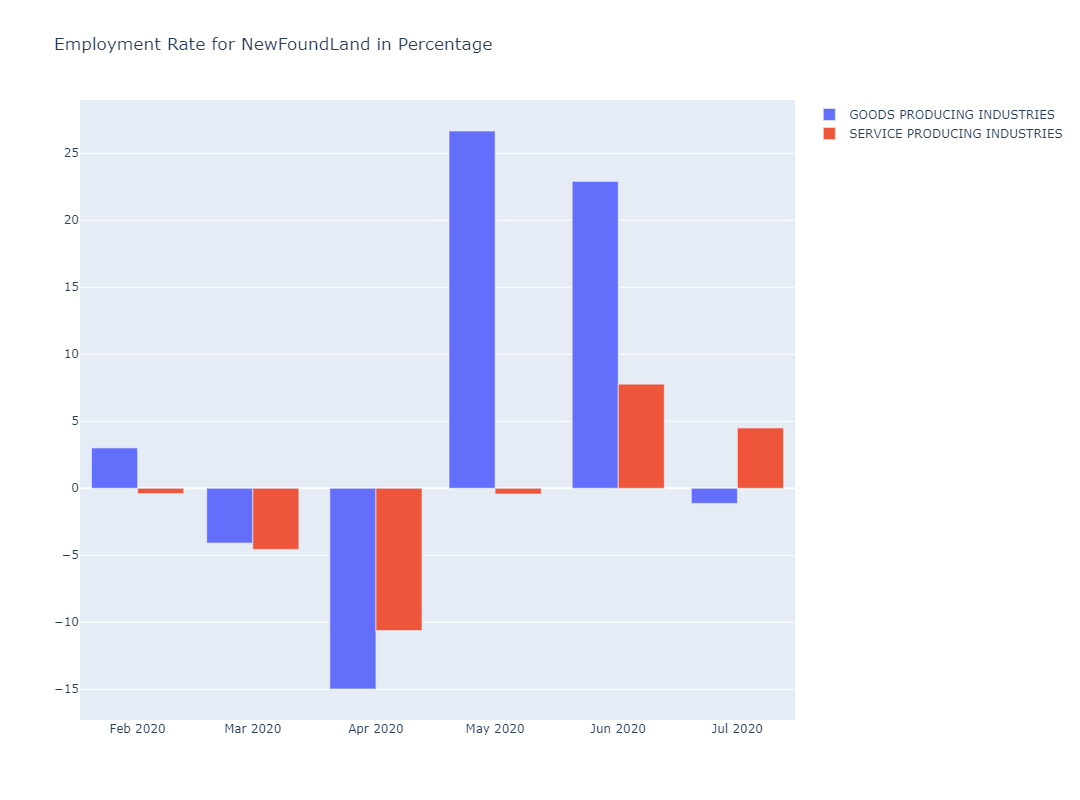

In [31]:

fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eNFL['Date'], y=eNFL['GPIC'],text=eNFL.GPIC),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eNFL['Date'], y=eNFL['SPIC'],text=eNFL['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for NewFoundLand in Percentage'
)
fig.show()

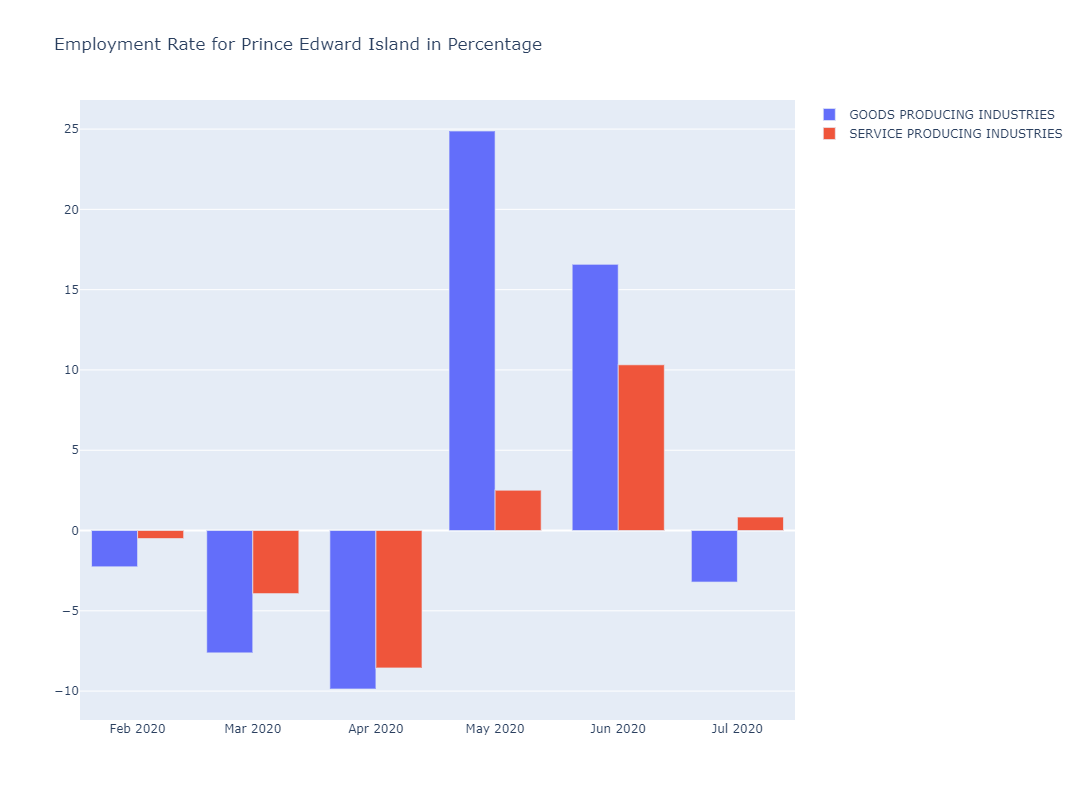

In [32]:
#Plotting Data for prince edward Island
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=ePEI['Date'], y=ePEI['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=ePEI['Date'], y=ePEI['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for Prince Edward Island in Percentage'
)
fig.show()

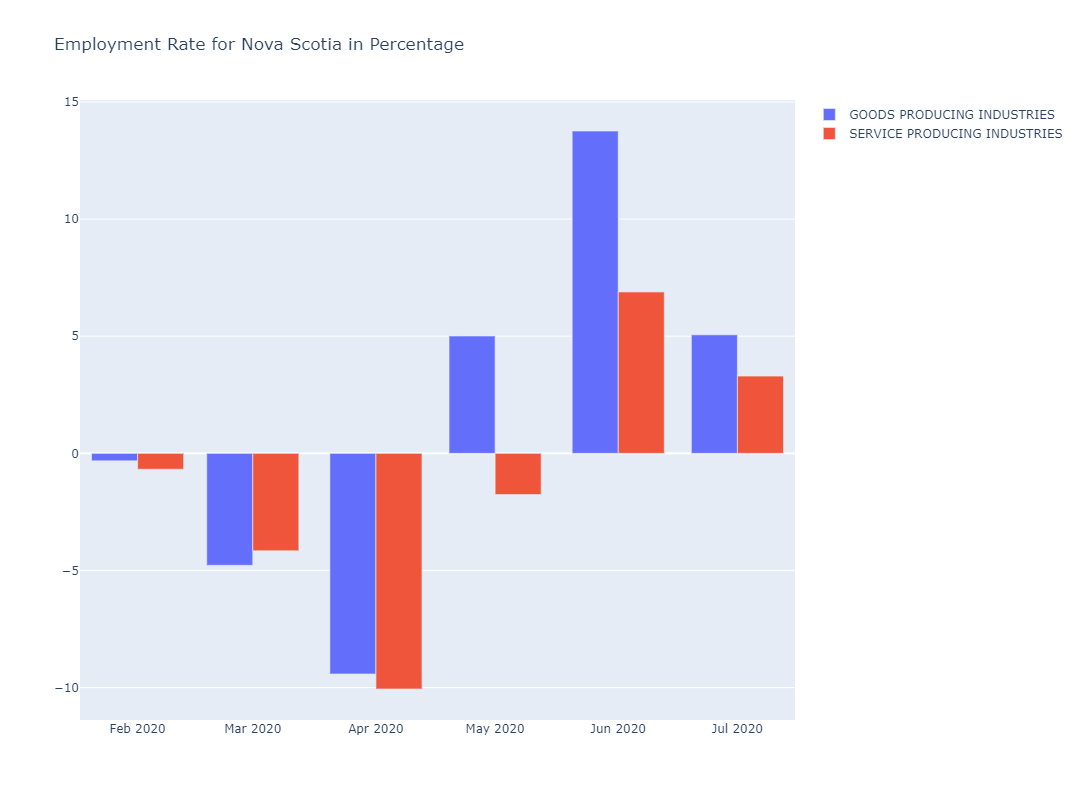

In [33]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eNVS['Date'], y=eNVS['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eNVS['Date'], y=eNVS['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for Nova Scotia in Percentage'
)

fig.show()

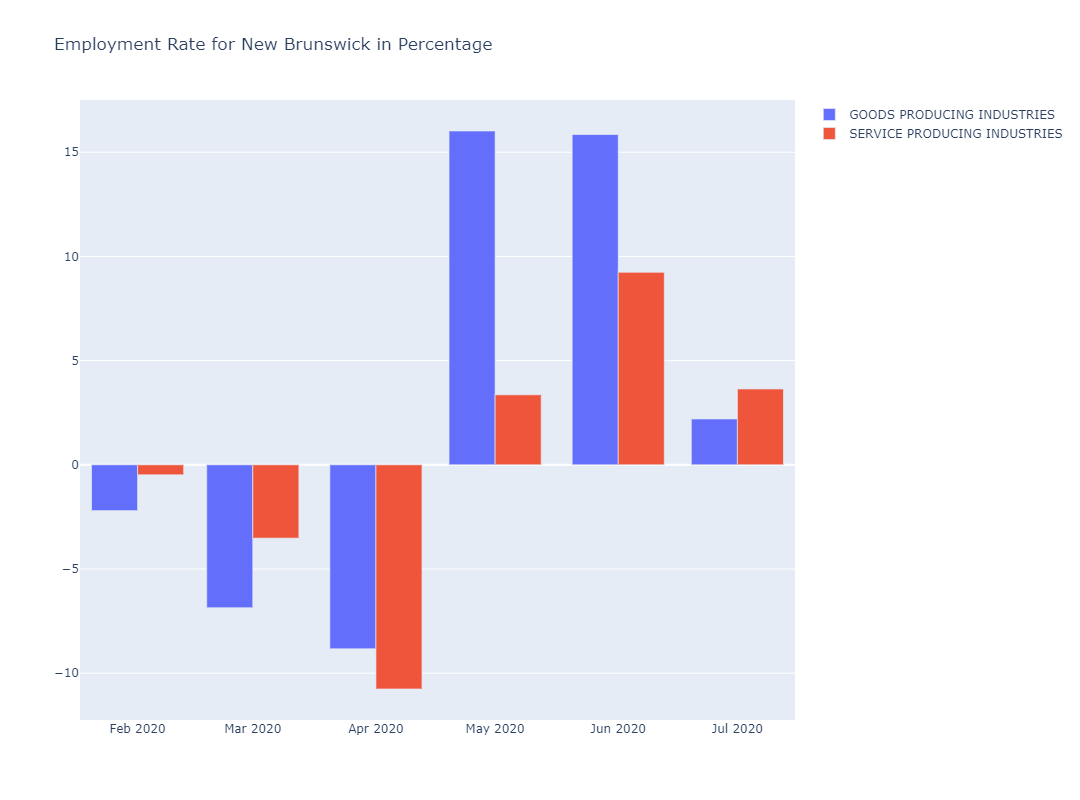

In [34]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eNBS['Date'], y=eNBS['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eNBS['Date'], y=eNBS['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for New Brunswick in Percentage'
)

fig.show()

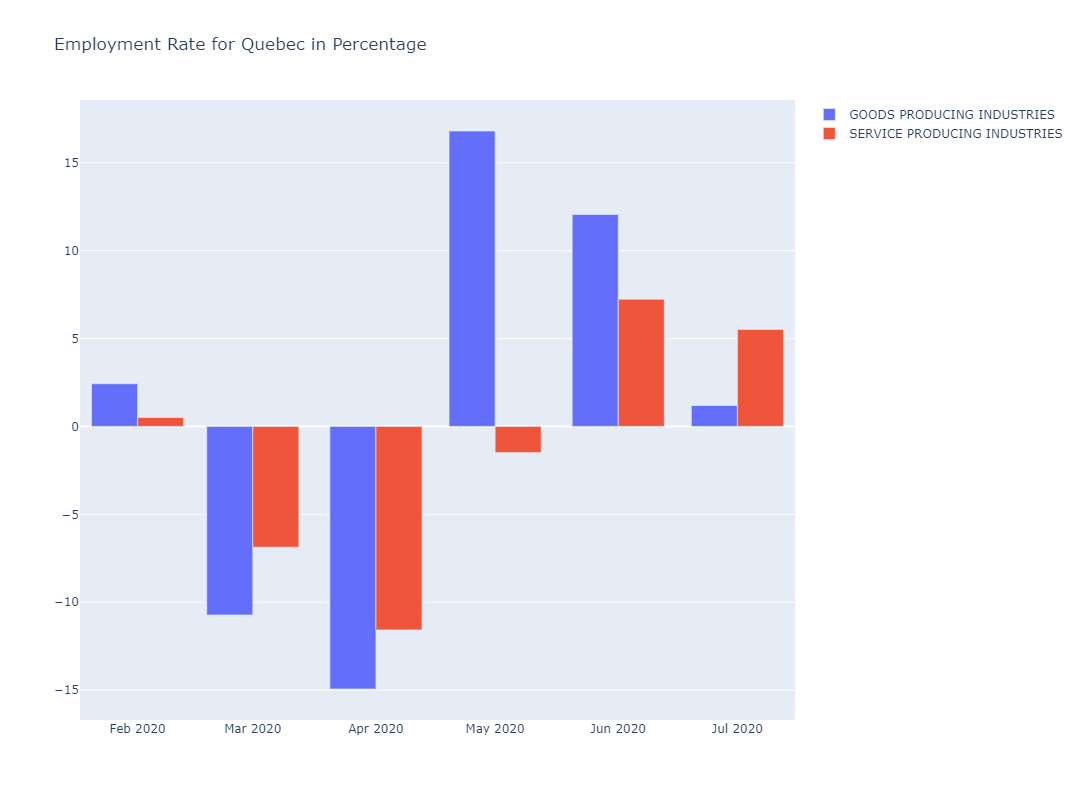

In [35]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eQBC['Date'], y=eQBC['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eQBC['Date'], y=eQBC['SPIC'])
])

fig.update_layout(
    height=800,
    title_text='Employment Rate for Quebec in Percentage'
)

fig.show()

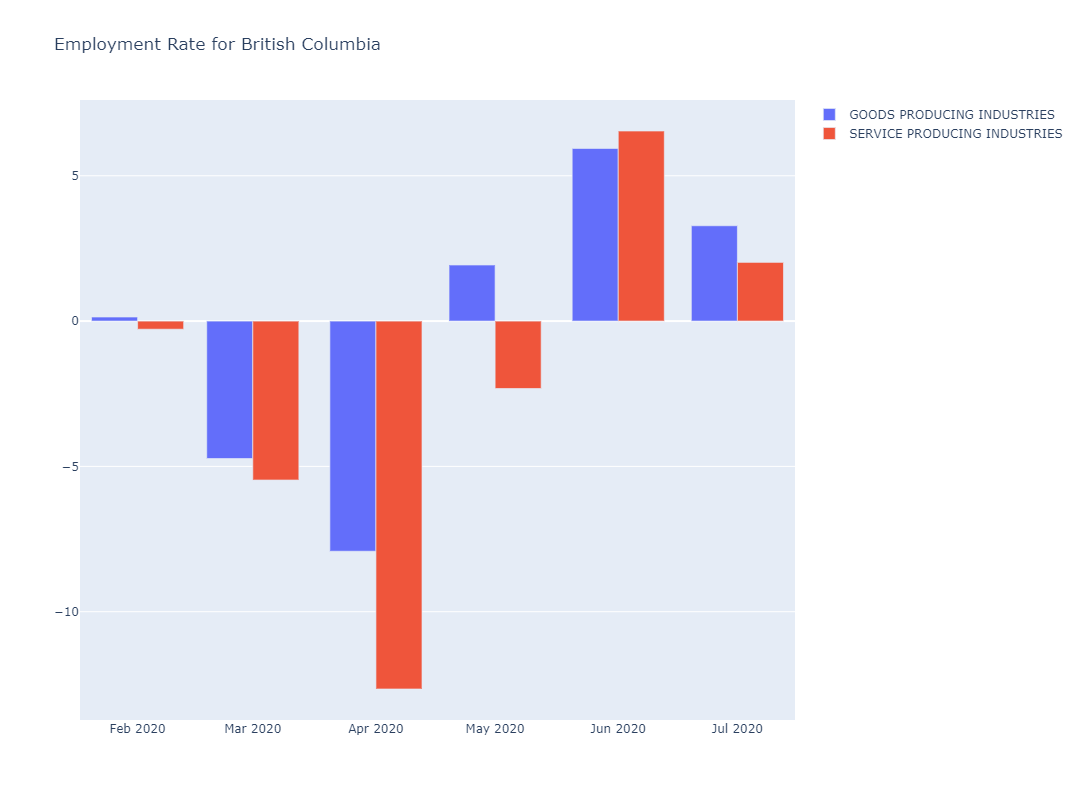

In [36]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eBC['Date'], y=eBC['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eBC['Date'], y=eBC['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for British Columbia'
)

fig.show()

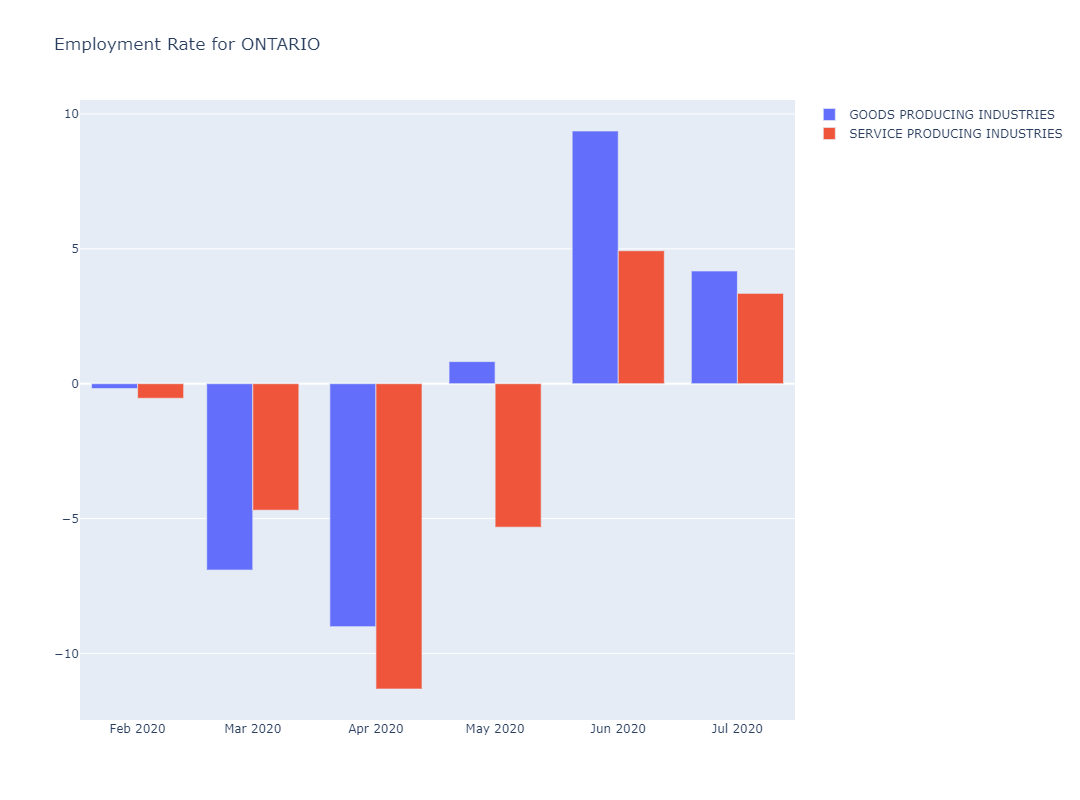

In [37]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eONT['Date'], y=eONT['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eONT['Date'], y=eONT['SPIC'])
])

fig.update_layout(
    height=800,
    title_text='Employment Rate for ONTARIO'
)
fig.show()

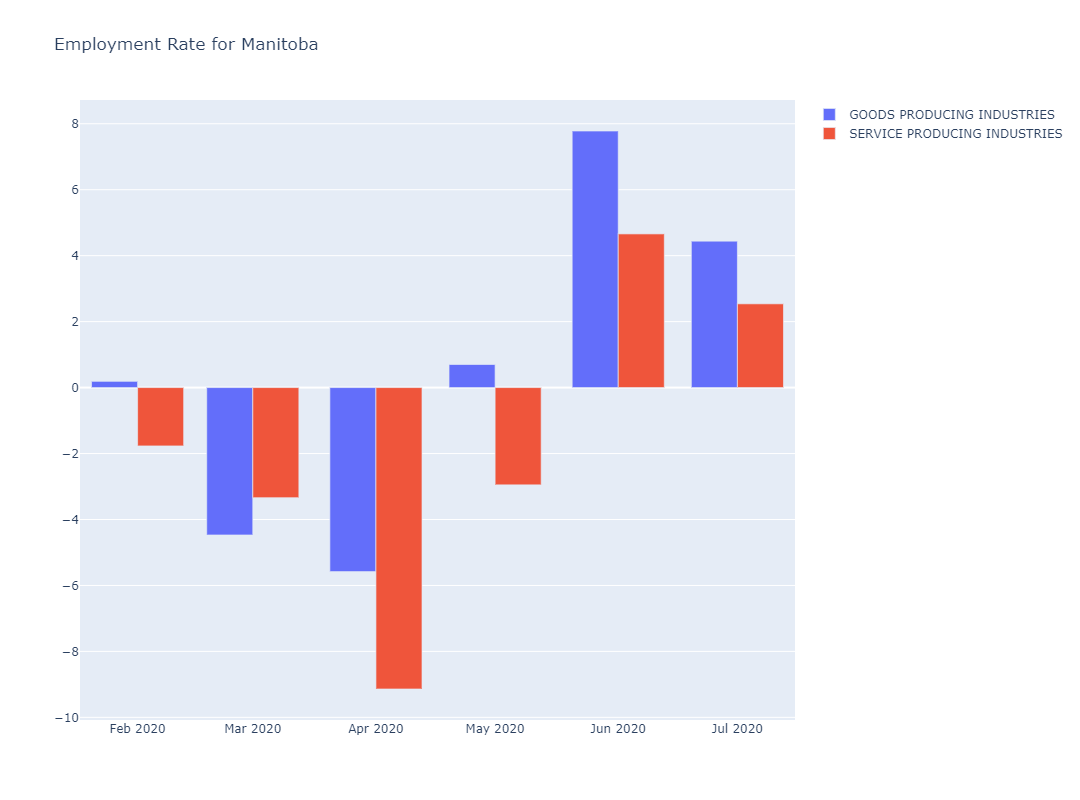

In [38]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eMTB['Date'], y=eMTB['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eMTB['Date'], y=eMTB['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for Manitoba'
)
fig.show()

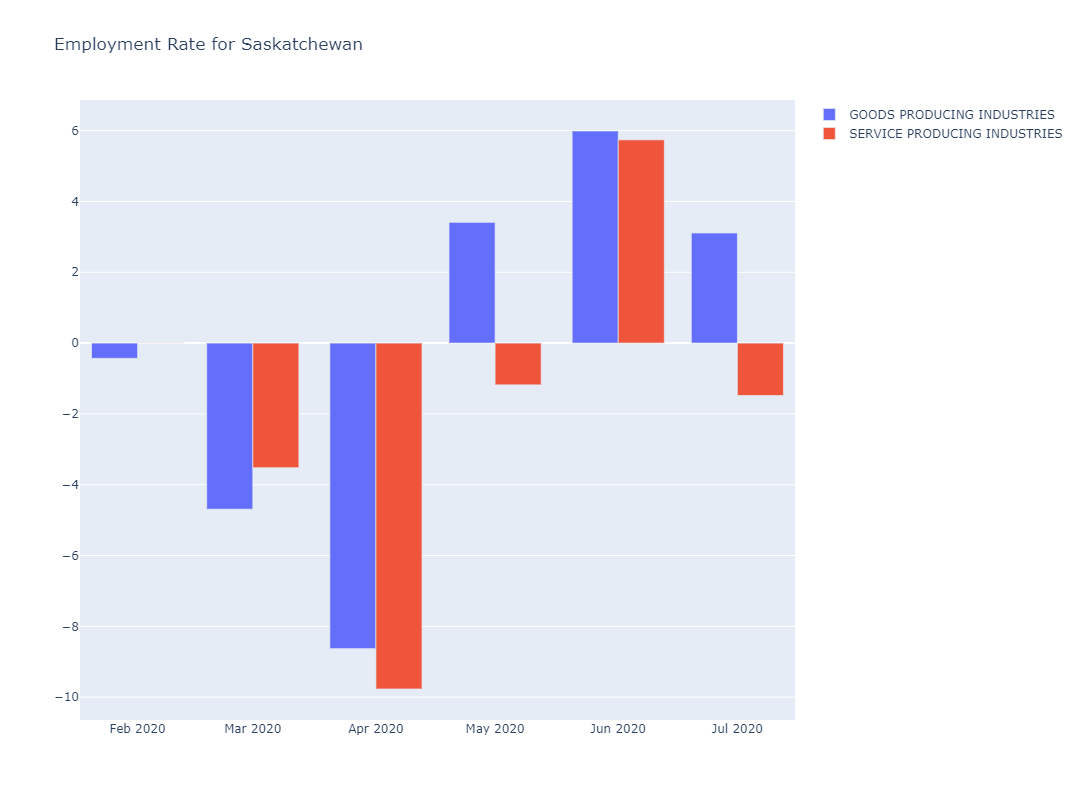

In [39]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eSASK['Date'], y=eSASK['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eSASK['Date'], y=eSASK['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for Saskatchewan'
)
fig.show()

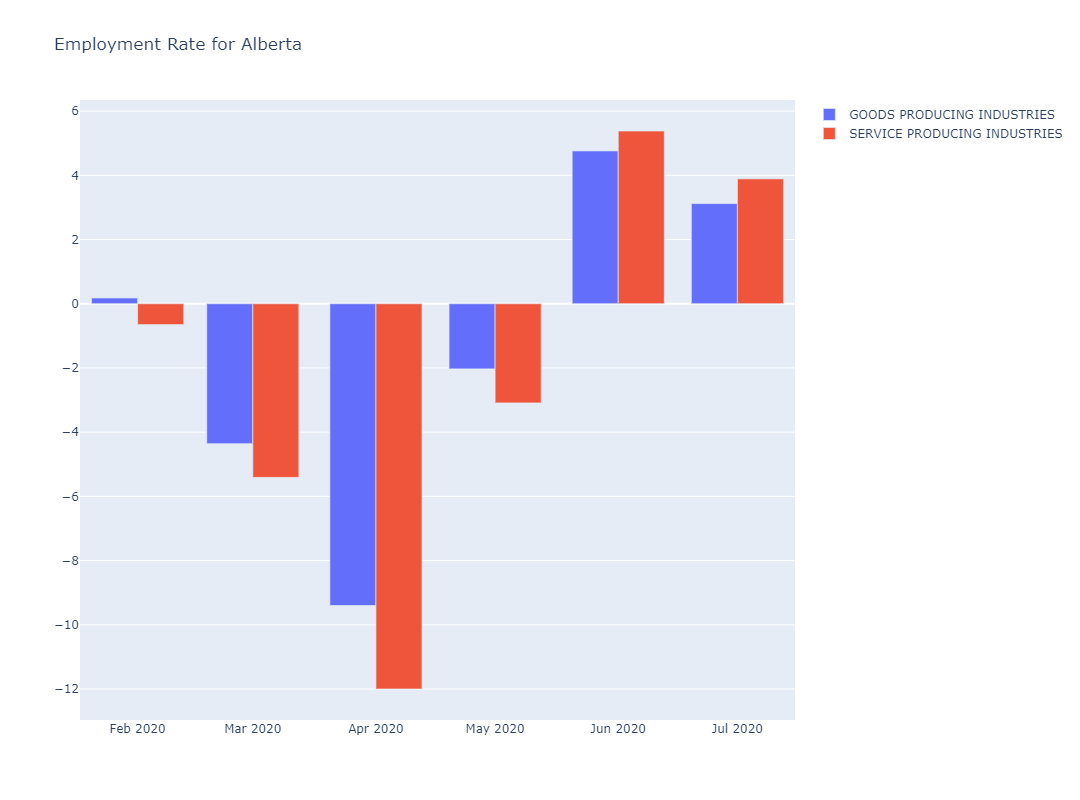

In [40]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eAB['Date'], y=eAB['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eAB['Date'], y=eAB['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for Alberta'
)
fig.show()

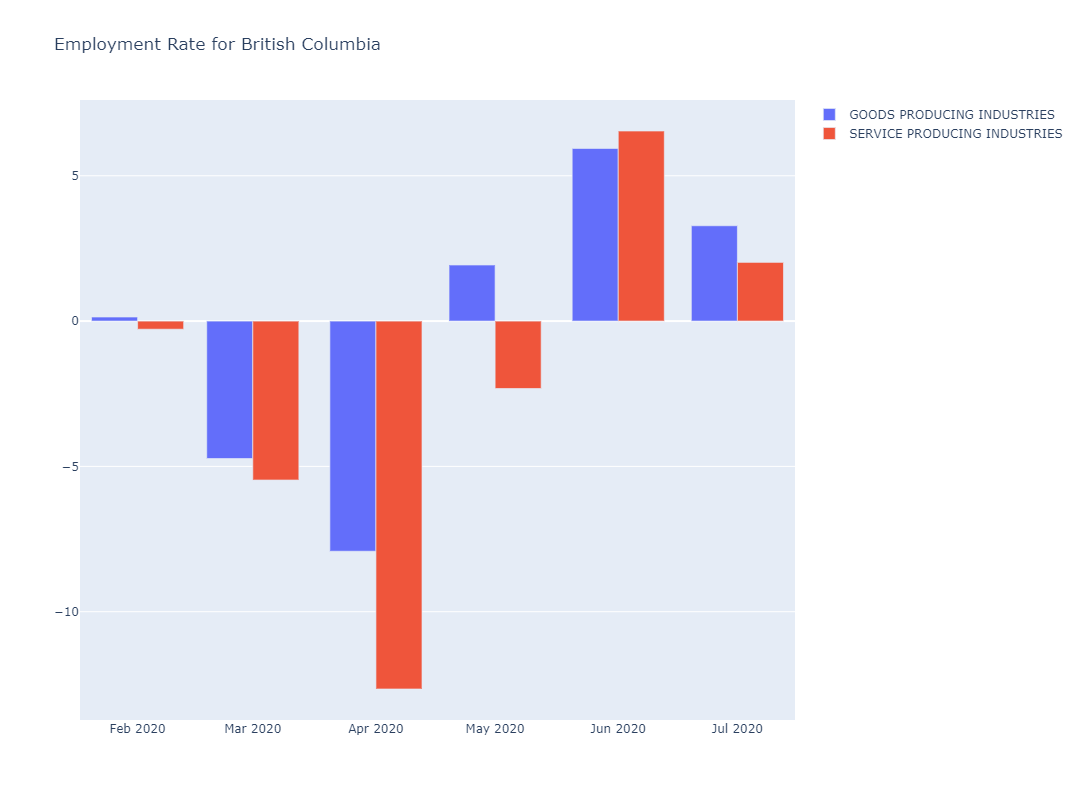

In [41]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eBC['Date'], y=eBC['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eBC['Date'], y=eBC['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for British Columbia'
)
fig.show()

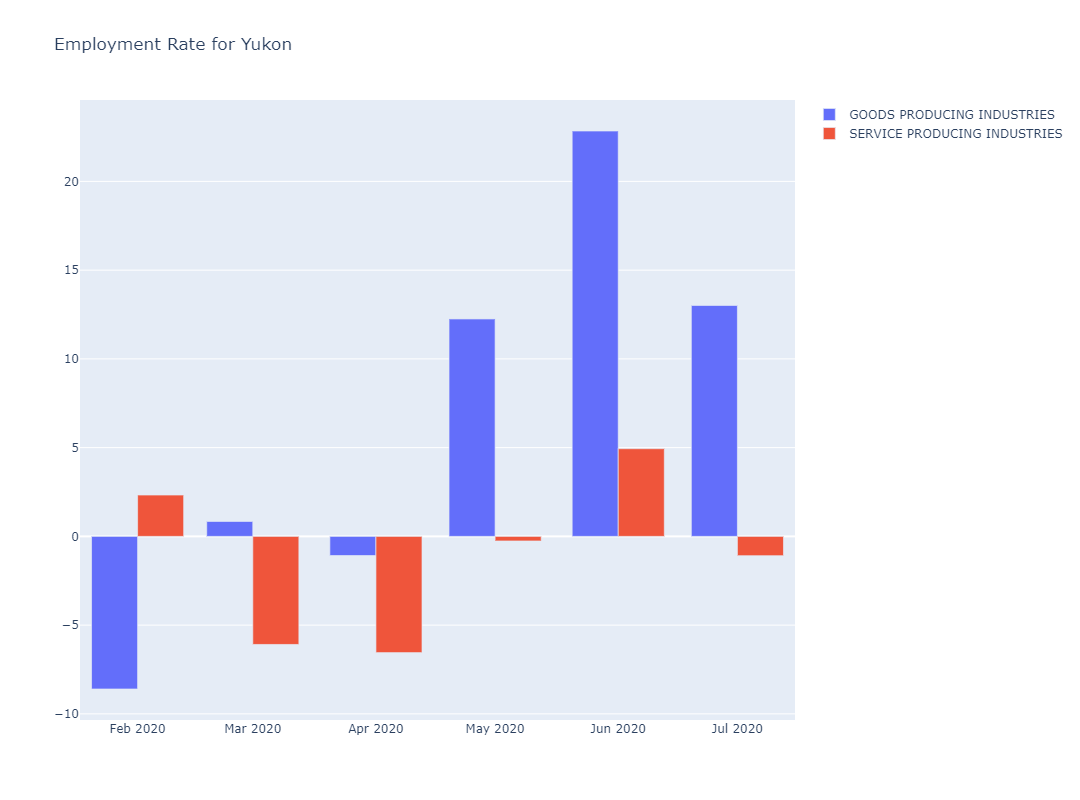

In [42]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eYK['Date'], y=eYK['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eYK['Date'], y=eYK['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for Yukon'
)
fig.show()

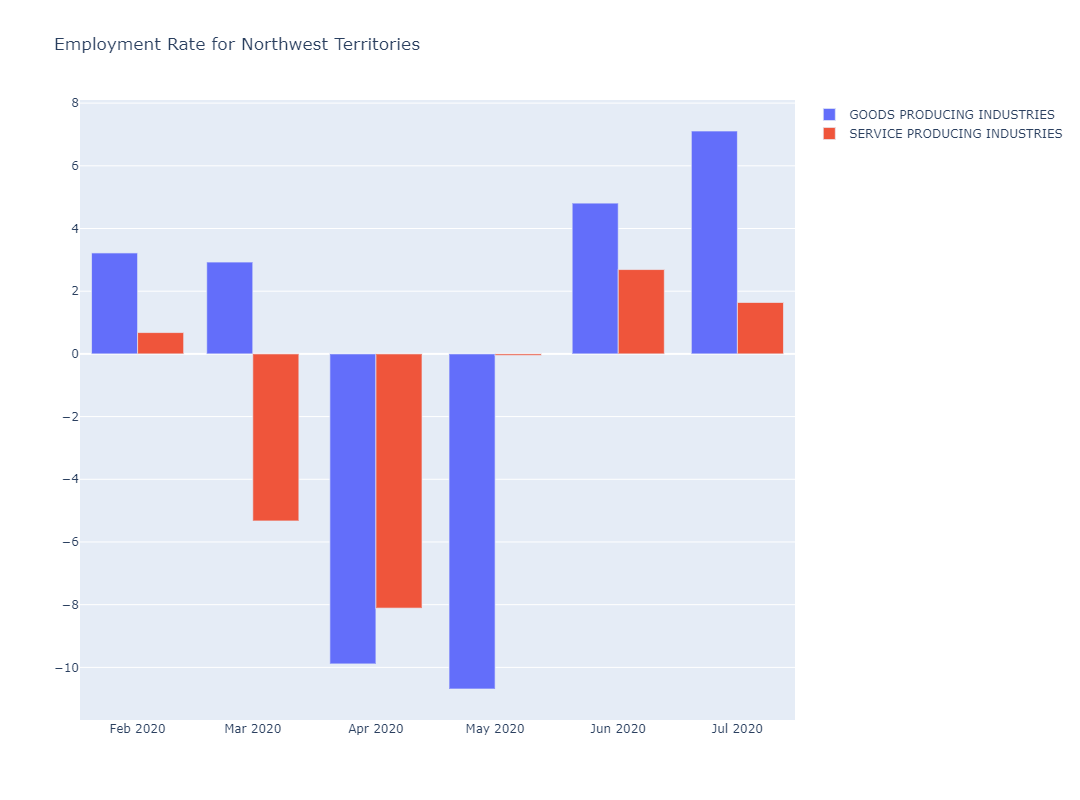

In [43]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eNWT['Date'], y=eNWT['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eNWT['Date'], y=eNWT['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for Northwest Territories'
)
fig.show()

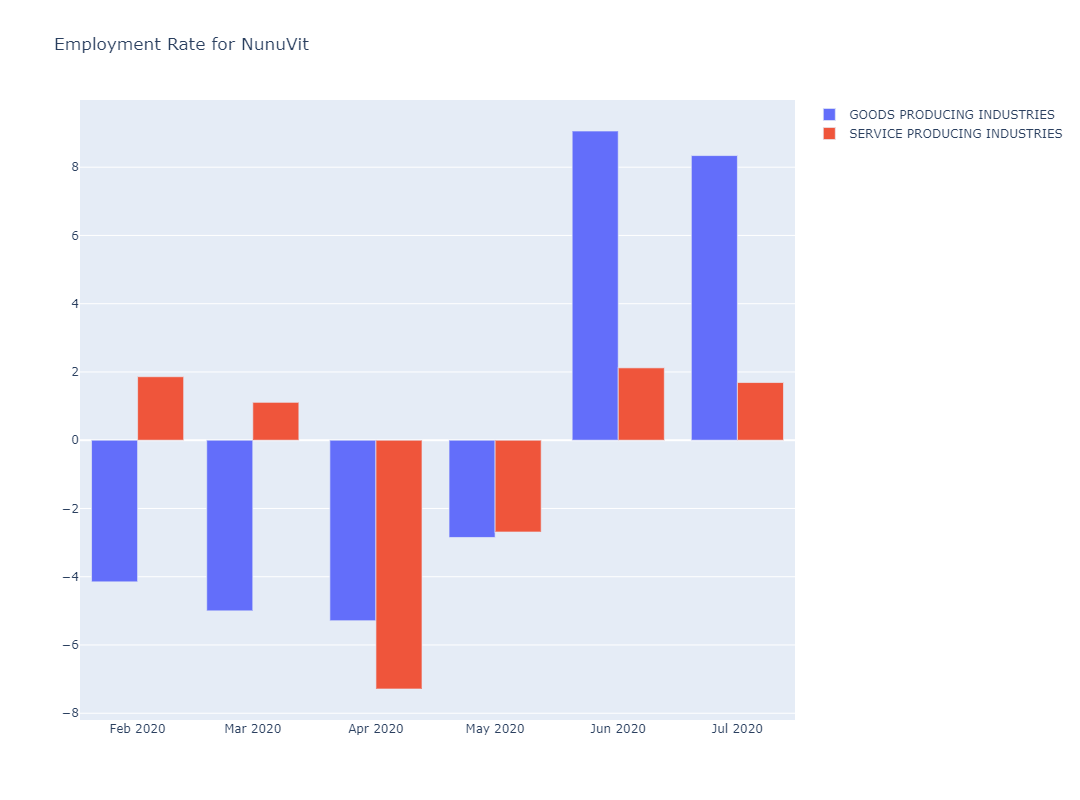

In [44]:
fig = go.Figure(data=[
    go.Bar(name='GOODS PRODUCING INDUSTRIES', x=eNNT['Date'], y=eNNT['GPIC']),
    go.Bar(name='SERVICE PRODUCING INDUSTRIES', x=eNNT['Date'], y=eNNT['SPIC'])
])
fig.update_layout(
    height=800,
    title_text='Employment Rate for NunuVit'
)
fig.show()

### Relationship between the two Industries
Both the Serice and Good producing industries complement each other
- During the pandemic, Good Producing Inductries (GPI) saw a significant increase in labor force. This is because majority of the GPI labour force are under the 'essential work' category where as the Service Producing Industries (SPI) so a significant loss of labour force


**Showing the Relationship between the employment rate of the Goods Producing Industries

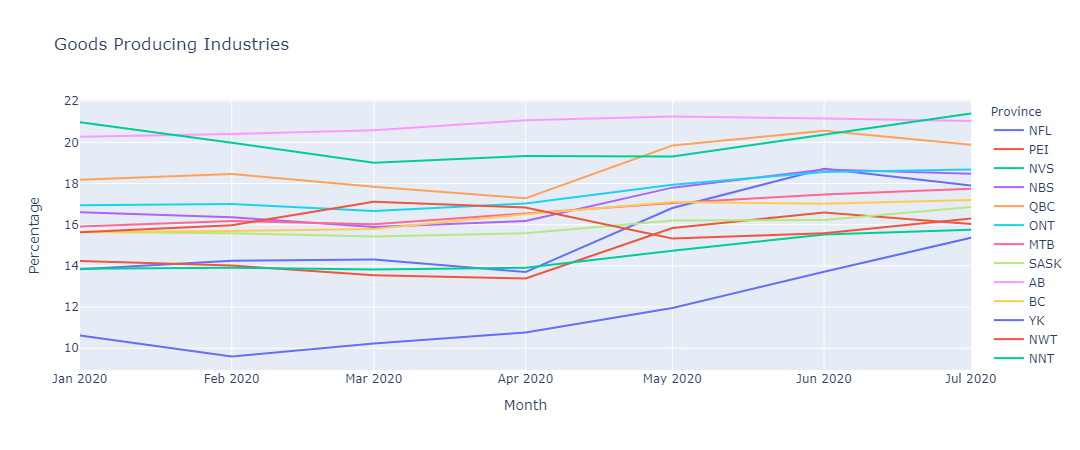

In [45]:
fig = px.line(employmentIndustries, x='Date', y=['Percentage for GPI'], color=employmentIndustries['Province'], title="Goods Producing Industries")

fig.update_layout(title='Goods Producing Industries',
                   xaxis_title='Month',
                   yaxis_title='Percentage')

fig.show()

**Showing the Relationship between the employment rate of the Service Producing Industries

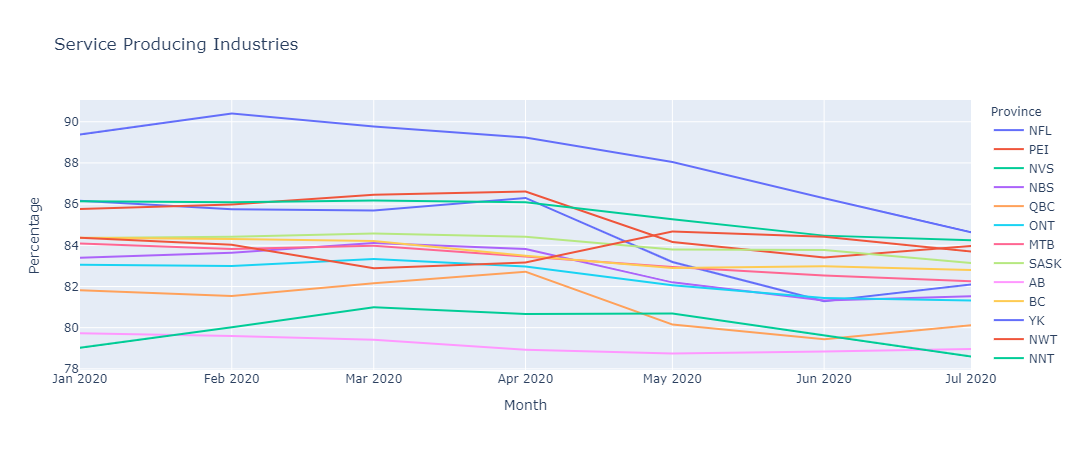

In [46]:
fig = px.line(employmentIndustries, x='Date', y=['Percentage for SPI'], color=employmentIndustries['Province'], title="Goods Producing Industries")

fig.update_layout(title='Service Producing Industries',
                   xaxis_title='Month',
                   yaxis_title='Percentage')

fig.show()

In [47]:
#Province that has the higher rate

In [48]:
egNFL = eNFL['GPIC'].sum()
egPEI = ePEI['GPIC'].sum()
egNVS = eNVS['GPIC'].sum()
egNBS = eNBS['GPIC'].sum()
egQBC = eQBC['GPIC'].sum()
egONT = eONT['GPIC'].sum()
egMTB = eMTB['GPIC'].sum()
egSASK = eSASK['GPIC'].sum()
egAB = eBC['GPIC'].sum()
egBC = eBC['GPIC'].sum()
egYK = eYK['GPIC'].sum()
egNWT = eNWT['GPIC'].sum()
egNNT = eNNT['GPIC'].sum()

esNFL = eNFL['SPIC'].sum()
esPEI = ePEI['SPIC'].sum()
esNVS = eNVS['SPIC'].sum()
esNBS = eNBS['SPIC'].sum()
esQBC = eQBC['SPIC'].sum()
esONT = eONT['SPIC'].sum()
esMTB = eMTB['SPIC'].sum()
esSASK = eSASK['SPIC'].sum()
esAB = eAB['SPIC'].sum()
esBC = eBC['SPIC'].sum()
esYK = eYK['SPIC'].sum()
esNWT = eNWT['SPIC'].sum()
esNNT = eNNT['SPIC'].sum()


percentagechange = {'GPI': [egNFL, egPEI,egNVS, egNBS,egQBC, egONT,egMTB, egSASK,egAB, egBC,egYK,egNWT,egNNT],
     'SPI': [esNFL, esPEI,esNVS, esNBS,esQBC, esONT,esMTB, esSASK,esAB, esBC,esYK,esNWT,esNNT], 
     'Province':['NFL','PEI','NVS','NBS','QBC','ONT','MTB','SASK','AB','BC','YK','NWT','NNT'] }


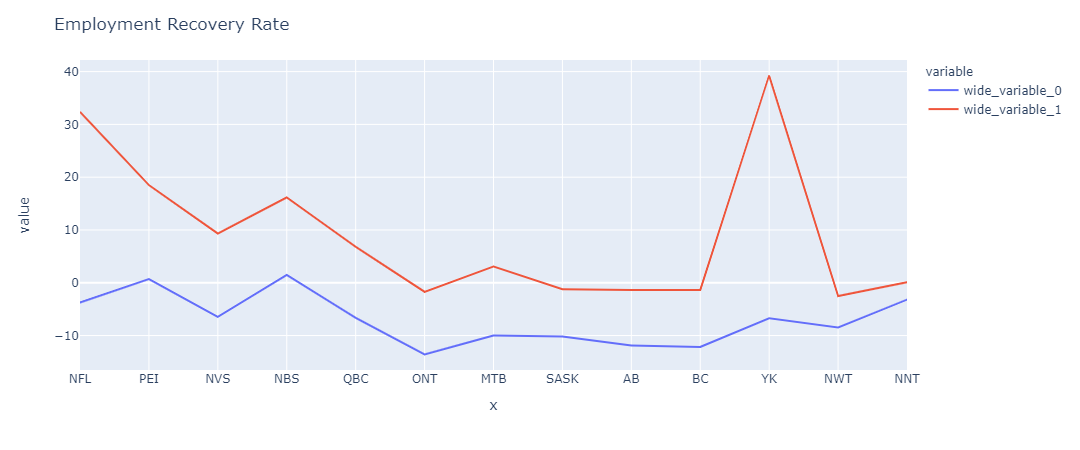

In [49]:
series1 = percentagechange['SPI']
series2 = percentagechange['GPI']
fig = px.line(x=percentagechange['Province'], y=[series1, series2])

fig.update_layout(
    title_text='Employment Recovery Rate')
    

fig.show()

**Yukon has recorded a recorvery rate of over 40%

## CONCLUSION
***

#### The questions we wanted to investigate are:
- After the drop in employment rate that Canadians experienced during the first wave of the COVID-19 pandemic in early April, has the employment rate gone back up, and which provinces have seen a higher rate of job recovery?
***

#### The answer to this question is:
***
- The two main industries affected by the ongoing pandemic are:
    * the Goods Producing Industry (GPI) - mainly includes industries providing essential services excluding health
    * the Service Producing Industry(SPI)
From the findings, most citizens changed jobs from the SPI to the GPI. During the high stage of the pandemic precisely between March and May 2020, there was a rise in the employment rate in the SPI as well as a low employment rate in the GPI. As of July 2020, the GPI was the industry with the high employment rate. There Has been a study in an increase in the employment rate among the provinces. The provinces with the best employment rate are New Brunswick, Prince Edward Island, and Yukon.
However, the provinces with a high unemployment rate are Ontario, British Columbia, and Alberta.

- Follow-up on this analyis should include:
    * Further analysis on the impact that the policies put in place had on the employment rate.
    * Further analysis into effective solutions to ensure that an increase in the GPI industry doesn't translate ina  drop in the SPI industry

## Guiding Question #4
***
#### Asymptomatic spreading considered as factor in COVID-19 case counts. With our project we intend to take a deeper dive into this group of cases and compare these cases with symptomatic cases.
The questions we want to investigate are:
- What are the characteristics that make up this group of individuals? (occupation, recovery rate, age groups, hospital status, gender Region
- Are these individuals more likely to survive COVID than asymptomatic individual?
##### Data Source: Detailed Dataset of Canada COVID 19 Cases with Age Group,Hospitalization Status
***
The dataset is tabular in a csv format. Columns include: case identifier number, age, transmission, asymptomatic, gender, occupation, death, hospital status, recovered and region. The dataset was access through Kaggle and is open source under the License Attribution 4.0 International (CC BY 4.0)

#### Part 1 (DATA WRANGLING)
- Import Data
- Drop columns that are not needed for analysis
- Split data into 3 data sets- Asymptomatic, symptomatic and all
- Data tables for various columns of the data set need to created
    * Age group distribution
    * Hospital status
    * Occupation
    * Recovery status
    * Region distribution
    * Gender

In [50]:
covid = pd.read_csv("./covid-asymptomatic-vs-symptomatic.csv")
display(covid.head())
display(covid.tail())

Case identifier number Asymptomatic Age_group Death  Gender  \
0                       1           No     50-59    No  Female   
1                       2           No     60-69    No  Female   
2                       3           No     20-29    No  Female   
3                       4           No     20-29    No  Female   
4                       5           No       80+    No  Female   

    Hospital_status             Occupation   Recovered    Region  \
0  Not Hospitalized                  Other  Not Stated  Prairies   
1  Not Hospitalized     Health Care worker         Yes   Ontario   
2  Not Hospitalized                  Other  Not Stated   Ontario   
3  Not Hospitalized                  Other         Yes   Ontario   
4  Not Hospitalized  Long Term Care worker  Not Stated  Prairies   

       Transmission  
0  Community Spread  
1  Community Spread  
2  Community Spread  
3    Travel History  
4  Community Spread

Case identifier number Asymptomatic Age_group Death  Gender  \
1983                    1995           No     50-59    No  Female   
1984                    1996           No       80+   Yes  Female   
1985                    1997           No     70-79   Yes    Male   
1986                    1998           No     20-29    No  Female   
1987                    1999           No     60-69   Yes  Female   

                  Hospital_status          Occupation   Recovered   Region  \
1983             Not Hospitalized               Other         Yes  Ontario   
1984             Not Hospitalized               Other  Not Stated  Ontario   
1985  Hospitalized but not in ICU               Other  Not Stated  Ontario   
1986             Not Hospitalized  Health Care worker         Yes  Ontario   
1987      Hospitalized and in ICU               Other  Not Stated  Ontario   

          Transmission  
1983  Community Spread  
1984  Community Spread  
1985  Community Spread  
1986  Community Spread  
1987  Community Spread

In [51]:
#Rename columns for ease of use
covid.rename(columns={'Case identifier number':'Case_number'}, inplace=True)
#Create 2 more data frames one for asymptomatic individuals and one for symptomatic individuals
acovid=(covid[covid['Asymptomatic'] == "Yes"]) #asymptomatic individuals data frame
scovid=(covid[covid['Asymptomatic'] == "No"]) # syptomatic individuals
display(acovid.head())
display(scovid.head())

Case_number Asymptomatic Age_group Death  Gender  \
14            15          Yes       80+    No  Female   
51            52          Yes     30-39    No    Male   
55            56          Yes     60-69    No    Male   
189          190          Yes       80+    No    Male   
190          191          Yes     30-39    No    Male   

                 Hospital_status Occupation   Recovered    Region  \
14              Not Hospitalized      Other         Yes  Atlantic   
51              Not Hospitalized      Other  Not Stated  Prairies   
55              Not Hospitalized      Other         Yes  Prairies   
189  Hospitalized but not in ICU      Other  Not Stated   Ontario   
190             Not Hospitalized      Other  Not Stated  Prairies   

         Transmission  
14   Community Spread  
51   Community Spread  
55   Community Spread  
189  Community Spread  
190  Community Spread

Case_number Asymptomatic Age_group Death  Gender   Hospital_status  \
0            1           No     50-59    No  Female  Not Hospitalized   
1            2           No     60-69    No  Female  Not Hospitalized   
2            3           No     20-29    No  Female  Not Hospitalized   
3            4           No     20-29    No  Female  Not Hospitalized   
4            5           No       80+    No  Female  Not Hospitalized   

              Occupation   Recovered    Region      Transmission  
0                  Other  Not Stated  Prairies  Community Spread  
1     Health Care worker         Yes   Ontario  Community Spread  
2                  Other  Not Stated   Ontario  Community Spread  
3                  Other         Yes   Ontario    Travel History  
4  Long Term Care worker  Not Stated  Prairies  Community Spread

### COVID-19 cases age distribution

The goal is to calaculate the percentage of cases that fall in each age distribution and then compare the differnce between asymptomatic case, asymptomatic cases and the full data set. The data first needs to be organized to allow for visualization. The following tasks have to be completed.
- Calculate percentage of cases that fall in each age distribution.
- Create data frames with age distribution information for the 3 data sets (Symptomatic cases, asymptomatic cases, all cases).
- Plot the finidings with an appropriate chart. 

In [52]:
# Create a data frame with calculate percentage of individuals in each age group for the 3 data sets
# Data frame with calculated percetage of individuals in each age group for whole data set
age_count=covid.groupby('Age_group').count()
age_sum=sum(age_count.Case_number)
age_count["Fulldata"] = age_count.Case_number * 100 / age_sum #add percentage column to data frame
age_count = age_count.drop(age_count.columns.to_series()[0:9], axis=1)# drop unecessary columns only keep percentage and the age group index
age_count["age_group"] = age_count.index # copy index column into a new column
age_count.reset_index(drop=True)
# Data frame with calculated percetage of individuals in each age group for asymptomatic data set
aage_count=acovid.groupby('Age_group').count()
aage_sum=sum(aage_count.Case_number)
aage_count["Asymptomatic"] = aage_count.Case_number * 100 / aage_sum #add percentage column to data frame
aage_count = aage_count.drop(aage_count.columns.to_series()[2:10], axis=1)# drop unecessary columns only keep percentage and the age group index
aage_count = aage_count.drop(aage_count.columns[0], axis=1)
aage_count["age_group"] = aage_count.index # copy index column into a new column
aage_count.reset_index(drop=True)
# Data frame with calculated percetage of individuals in each age group for symptomatic data set
sage_count=scovid.groupby('Age_group').count()
sage_sum=sum(sage_count.Case_number)
sage_count["Symptomatic"] = sage_count.Case_number * 100 / sage_sum #add percentage column to data frame
sage_count = sage_count.drop(sage_count.columns.to_series()[0:9], axis=1)# drop unecessary columns only keep percentage and the age group index
sage_count["age_group"] = sage_count.index # copy index column into a new column
sage_count.reset_index(drop=True)

Symptomatic age_group
0     3.429204      0-19
1    10.951327     20-29
2    14.601770     30-39
3    15.265487     40-49
4    15.707965     50-59
5    13.384956     60-69
6     8.296460     70-79
7    18.362832       80+

#### Part 3 (PREPARING DATA TO CHART)
Data needs to be organized in one table to allow for visualization

In [53]:
#Create one table with age distribution data for symptomatic, asyptomatic and all COVID cases
age=sage_count.merge(aage_count,on='age_group', how='left')
age=age.merge(age_count,on='age_group', how='left').set_index('age_group')
age

Symptomatic  Asymptomatic   Fulldata
age_group                                      
0-19          3.429204      6.180812   4.929577
20-29        10.951327     12.546125  11.820926
30-39        14.601770     14.391144  14.486922
40-49        15.265487     15.498155  15.392354
50-59        15.707965     15.959410  15.845070
60-69        13.384956     11.439114  12.323944
70-79         8.296460      7.011070   7.595573
80+          18.362832     16.974170  17.605634

In [54]:
#Plot the findings
def f(dataset):
    fig = px.bar(age.T.loc[str(dataset)],
              labels={'value':'percentage of individuals {}'.format(str(dataset))},
              title= 'COVID cases age group distribution')
    fig.update_yaxes(range=[0, 50])
    
    fig.show()
    
interact(f, dataset=list(age.T.index) )

interactive(children=(Dropdown(description='dataset', options=('Symptomatic', 'Asymptomatic', 'Fulldata'), val…

<function __main__.f(dataset)>

**Observations**

There is no visible difference in age distribution between symptomatic, asymptomatic and all COVID cases.
We see a similar age distribution amongst all three data sets. Although we see a slightly higher percentage of asymptomatic indviduals in the 0-19 age group there aren't enough differnces to state that younger individuals who are affected by COVID are more likely to be asymptomatic than older individals.

### COVID-19 cases hospital status ditribution

The goal is to analyze cases that fall in each hospital status category and then compare the differnce between asymptomatic case, asymptomatic cases and the full data set. The data first needs to be organized to allow for visualization. The following tasks have to be completed.
- Calculate percentage of cases that fall in each hospital status category.
- Create data frames with hospital status data for the 3 data sets (Symptomatic cases, asymptomatic cases, all cases).
- Plot the finidings with an appropriate chart. 

In [55]:
# Create a data frame with calculate percentage of individuals hospital status for the 3 data sets
# Data frame with calculated percetage of individuals in each age group for whole data set
hosp_count=covid.groupby('Hospital_status').count()
hosp_sum=sum(hosp_count.Case_number)
hosp_count["Fulldata"] = hosp_count.Case_number * 100 / hosp_sum #add percentage column to data frame
hosp_count = hosp_count.drop(hosp_count.columns.to_series()[0:9], axis=1)# drop unecessary columns 
hosp_count["hospital_status"] = hosp_count.index # copy index column into a new column
hosp_count.reset_index(drop=True)
# Data frame with calculated percetage of individuals and hospital status for asymptomatic data set
ahosp_count=acovid.groupby('Hospital_status').count()
ahosp_sum=sum(ahosp_count.Case_number)
ahosp_count["Asymptomatic"] = ahosp_count.Case_number * 100 / ahosp_sum #add percentage column to data frame
ahosp_count = ahosp_count.drop(ahosp_count.columns.to_series()[2:10], axis=1)# drop unecessary columns only keep percentage and the index
ahosp_count = ahosp_count.drop(ahosp_count.columns[0], axis=1)
ahosp_count["hospital_status"] = ahosp_count.index # copy index column into a new column
ahosp_count.reset_index(drop=True)
# Data frame with calculated percetage of individuals and hospital status for symptomatic data set
shosp_count=scovid.groupby('Hospital_status').count()
shosp_sum=sum(shosp_count.Case_number)
shosp_count["Symptomatic"] = shosp_count.Case_number * 100 / shosp_sum #add percentage column to data frame
shosp_count = shosp_count.drop(shosp_count.columns.to_series()[0:9], axis=1)# drop unecessary columns only keep percentage andindex
shosp_count["hospital_status"] = shosp_count.index # copy index column into a new column
shosp_count.reset_index(drop=True)

Symptomatic              hospital_status
0    12.057522      Hospitalized and in ICU
1    15.376106  Hospitalized but not in ICU
2    72.566372             Not Hospitalized

#### Part 3 (PREPARING DATA TO CHART)
Data needs to be organized in one table to allow for visualization

In [56]:
#Create one table hospital status data for symptomatic, asyptomatic and all COVID cases
hosp=shosp_count.merge(ahosp_count,on='hospital_status', how='left')
hosp=hosp.merge(hosp_count,on='hospital_status', how='left').set_index('hospital_status')
hosp

Symptomatic  Asymptomatic   Fulldata
hospital_status                                                  
Hospitalized and in ICU        12.057522      2.398524   6.790744
Hospitalized but not in ICU    15.376106     24.630996  20.422535
Not Hospitalized               72.566372     72.970480  72.786720

In [57]:
#Plot the findings
def f(dataset):
    fig = px.bar(hosp.T.loc[str(dataset)],
              labels={'value':'percentage of individuals {}'.format(str(dataset))},
              title= 'COVID cases hospital status distribution')
    fig.update_yaxes(range=[0, 100])
    fig.show()
    
interact(f, dataset=list(hosp.T.index) )


interactive(children=(Dropdown(description='dataset', options=('Symptomatic', 'Asymptomatic', 'Fulldata'), val…

<function __main__.f(dataset)>

**Observations**

interestingly asymptomatic patients seem to be hospitalized more frequently than asymptomatic patients, this may be because even though they are asymptomatic at the time of testing their condition may get progressively worst with time

### COVID-19 cases gender distribution

The goal is to analyze gender distribution among COVID cases then compare the differnce between asymptomatic case, asymptomatic cases and the full data set. The data first needs to be organized to allow for visualization. The following tasks have to be completed.
- Calculate percentage of cases that fall in each gender.
- Create data frames with gender data for the 3 data sets (Symptomatic cases, asymptomatic cases, all cases).
- Plot the finidings with an appropriate chart. 

In [58]:
# Create a data frame with calculate percentage of individuals gender for the 3 data sets
# Data frame with calculated percetage of individuals in each age group for whole data set
gen_count=covid.groupby('Gender').count()
gen_sum=sum(gen_count.Case_number)
gen_count["Fulldata"] = gen_count.Case_number * 100 / gen_sum #add percentage column to data frame
gen_count = gen_count.drop(gen_count.columns.to_series()[0:9], axis=1)# drop unecessary columns
gen_count["gender"] = gen_count.index # copy index column into a new column
gen_count.reset_index(drop=True)
# Data frame with calculated percetage of individuals in each age group for asymptomatic data set
agen_count=acovid.groupby('Gender').count()
agen_sum=sum(agen_count.Case_number)
agen_count["Asymptomatic"] = agen_count.Case_number * 100 / agen_sum #add percentage column to data frame
agen_count = agen_count.drop(agen_count.columns.to_series()[2:10], axis=1)# drop unecessary columns 
agen_count = agen_count.drop(agen_count.columns[0], axis=1)
agen_count["gender"] = agen_count.index # copy index column into a new column
agen_count.reset_index(drop=True)
# Data frame with calculated percetage of individuals in each age group for symptomatic data set
sgen_count=scovid.groupby('Gender').count()
sgen_sum=sum(sgen_count.Case_number)
sgen_count["Symptomatic"] = sgen_count.Case_number * 100 / sgen_sum #add percentage column to data frame
sgen_count = sgen_count.drop(sgen_count.columns.to_series()[0:9], axis=1)# drop unecessary columns
sgen_count["gender"] = sgen_count.index # copy index column into a new column
sgen_count.reset_index(drop=True)

Symptomatic  gender
0    54.646018  Female
1    45.353982    Male

#### Part 3 (PREPARING DATA TO CHART)
Data needs to be organized in one table to allow for visualization

In [59]:
#Create one table with gender data for symptomatic, asyptomatic and all COVID cases
gen=sgen_count.merge(agen_count,on='gender', how='left')
gen=gen.merge(gen_count,on='gender', how='left').set_index('gender')
gen

Symptomatic  Asymptomatic   Fulldata
gender                                      
Female    54.646018     56.549815  55.684105
Male      45.353982     43.450185  44.315895

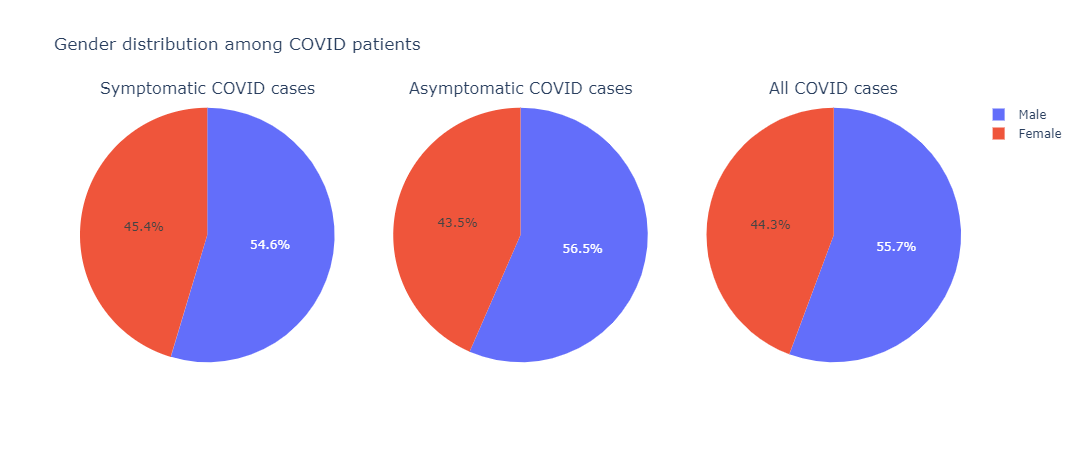

In [60]:
#Graph the outcome using a pie chart with subplots
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ["Male", "Female"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'} ]],
                    subplot_titles=['Symptomatic COVID cases', 'Asymptomatic COVID cases', 'All COVID cases'])
fig.add_trace(go.Pie(labels=labels, values=gen['Symptomatic'], name="Symptomatic COVID cases"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=gen['Asymptomatic'], name="Asymptomatic COVID cases"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=gen['Fulldata'], name="All COVID cases"),
              1, 3)

fig.update_layout(title_text="Gender distribution among COVID patients")
fig.show()

**Observations**

There is no visible difference in gender distribution between symptomatic, asymptomatic and all COVID cases.
We see a similar distribution amongst all three data sets suggesting that male and females are equally as likely to be asymptomatic or symptomatic when infected by COVID

### COVID-19 cases occupation

The goal is to calaculate the percentage of cases that fall in each occupation group and then compare the difference between asymptomatic case, asymptomatic cases and the full data set. The data first needs to be organized to allow for visualization. The following tasks have to be completed.
- Calculate percentage of cases that fall in each occupation.
- Create data frames with occupation information for the 3 data sets (Symptomatic cases, asymptomatic cases, all cases).
- Plot the finidings with an appropriate chart. 

In [61]:
# Create a data frame with calculate percentage of individuals in each occupation for the 3 data sets
# Data frame with calculated percetage of individuals in each age group for whole data set
occ_count=covid.groupby('Occupation').count()
occ_sum=sum(occ_count.Case_number)
occ_count["Fulldata"] = occ_count.Case_number * 100 / occ_sum #add percentage column to data frame
occ_count = occ_count.drop(occ_count.columns.to_series()[0:9], axis=1)# drop unecessary columns
occ_count['occupation'] = occ_count.index # copy index column into a new column
occ_count.reset_index(drop=True)
# Data frame with calculated percetage of individuals in each age group for asymptomatic data set
aocc_count=acovid.groupby('Occupation').count()
aocc_sum=sum(aocc_count.Case_number)
aocc_count["Asymptomatic"] = aocc_count.Case_number * 100 / aocc_sum #add percentage column to data frame
aocc_count = aocc_count.drop(aocc_count.columns.to_series()[2:10], axis=1)# drop unecessary columns 
aocc_count = aocc_count.drop(aocc_count.columns[0], axis=1)
aocc_count["occupation"] = aocc_count.index # copy index column into a new column
aocc_count.reset_index(drop=True)
# Data frame with calculated percetage of individuals in each age group for symptomatic data set
socc_count=scovid.groupby('Occupation').count()
socc_sum=sum(socc_count.Case_number)
socc_count["Symptomatic"] = socc_count.Case_number * 100 / socc_sum #add percentage column to data frame
socc_count = socc_count.drop(socc_count.columns.to_series()[0:9], axis=1)# drop unecessary columns
socc_count["occupation"] = socc_count.index # copy index column into a new column
socc_count.reset_index(drop=True)

Symptomatic             occupation
0     0.442478        Day Care worker
1    17.035398     Health Care worker
2     2.876106  Long Term Care worker
3    79.646018                  Other

#### Part 3 (PREPARING DATA TO CHART)
Data needs to be organized in one table to allow for visualization

In [62]:
#Create one table with occupation data for symptomatic, asyptomatic and all COVID cases
occ=socc_count.merge(aocc_count,on='occupation', how='left')
occ=occ.merge(occ_count,on='occupation', how='left').set_index('occupation')
occ

Symptomatic  Asymptomatic   Fulldata
occupation                                                 
Day Care worker           0.442478      0.276753   0.352113
Health Care worker       17.035398     16.328413  16.649899
Long Term Care worker     2.876106      1.476015   2.112676
Other                    79.646018     81.918819  80.885312

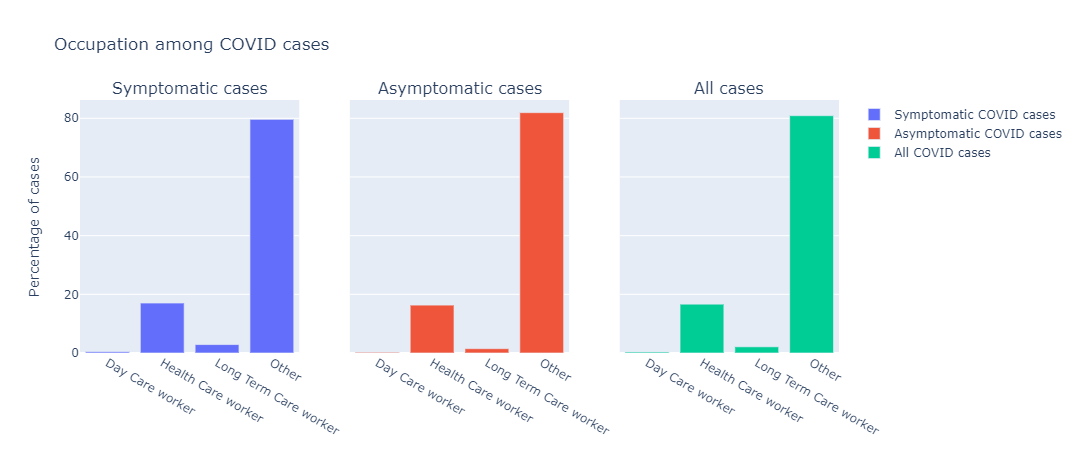

In [63]:
#Plot the findings
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=3, shared_yaxes=True,subplot_titles=['Symptomatic cases', 'Asymptomatic cases', 'All cases'])

fig.add_trace(go.Bar(x=occ.index, y=occ['Symptomatic'],name="Symptomatic COVID cases"),1, 1)
fig.add_trace(go.Bar(x=occ.index, y=occ['Asymptomatic'],name="Asymptomatic COVID cases"),1, 2)
fig.add_trace(go.Bar(x=occ.index, y=occ['Fulldata'],name="All COVID cases"),1, 3)

fig.update_layout(title_text="Occupation among COVID cases", yaxis_title="Percentage of cases")
fig.show()



**Observations**

There is no visible difference in occupation distribution between symptomatic, asymptomatic and all COVID cases.
We see a similar profession distribution amongst all three data sets.


### COVID-19 cases recovery

The goal is to calaculate the percentage of cases that recover from COVID and then compare the differnce between asymptomatic case, asymptomatic cases and the full data set. The data first needs to be organized to allow for visualization. The following tasks have to be completed.
- Calculate percentage of cases that fall in each recovery category.
- Create data frames with recovery information for the 3 data sets (Symptomatic cases, asymptomatic cases, all cases).
- Plot the finidings with an appropriate chart. 

In [64]:
# Create a data frame with calculate percentage of individuals recovery status for the 3 data sets
# Data frame with calculated percetage of individuals in each age group for whole data set
rec_count=covid.groupby('Recovered').count()
rec_sum=sum(rec_count.Case_number)
rec_count["Fulldata"] = rec_count.Case_number * 100 / rec_sum #add percentage column to data frame
rec_count = rec_count.drop(rec_count.columns.to_series()[0:9], axis=1)# drop unecessary columns
rec_count['recovery'] = rec_count.index # copy index column into a new column
rec_count.reset_index(drop=True)
# Data frame with calculated percetage of individuals in each recovery status for asymptomatic data set
arec_count=acovid.groupby('Recovered').count()
arec_sum=sum(arec_count.Case_number)
arec_count["Asymptomatic"] = arec_count.Case_number * 100 / arec_sum #add percentage column to data frame
arec_count = arec_count.drop(arec_count.columns.to_series()[2:10], axis=1)# drop unecessary columns 
arec_count = arec_count.drop(arec_count.columns[0], axis=1)
arec_count['recovery'] = arec_count.index # copy index column into a new column
arec_count.reset_index(drop=True)
# Data frame with calculated percetage of individuals in each recovery status for symptomatic data set
srec_count=scovid.groupby('Recovered').count()
srec_sum=sum(srec_count.Case_number)
srec_count["Symptomatic"] = srec_count.Case_number * 100 / srec_sum #add percentage column to data frame
srec_count = srec_count.drop(srec_count.columns.to_series()[0:9], axis=1)# drop unecessary columns
srec_count['recovery'] = srec_count.index # copy index column into a new column
srec_count.reset_index(drop=True)

Symptomatic    recovery
0     5.862832          No
1    59.181416  Not Stated
2    34.955752         Yes

#### Part 3 (PREPARING DATA TO CHART)
Data needs to be organized in one table to allow for visualization

In [65]:
#Create one table with recovery status data for symptomatic, asyptomatic and all COVID cases
rec=rec_count.merge(arec_count,on='recovery', how='left')
rec=rec.merge(srec_count,on='recovery', how='left').set_index('recovery')
rec

Fulldata  Asymptomatic  Symptomatic
recovery                                        
No           6.237425      6.549815     5.862832
Not Stated  62.273642     64.852399    59.181416
Yes         31.488934     28.597786    34.955752

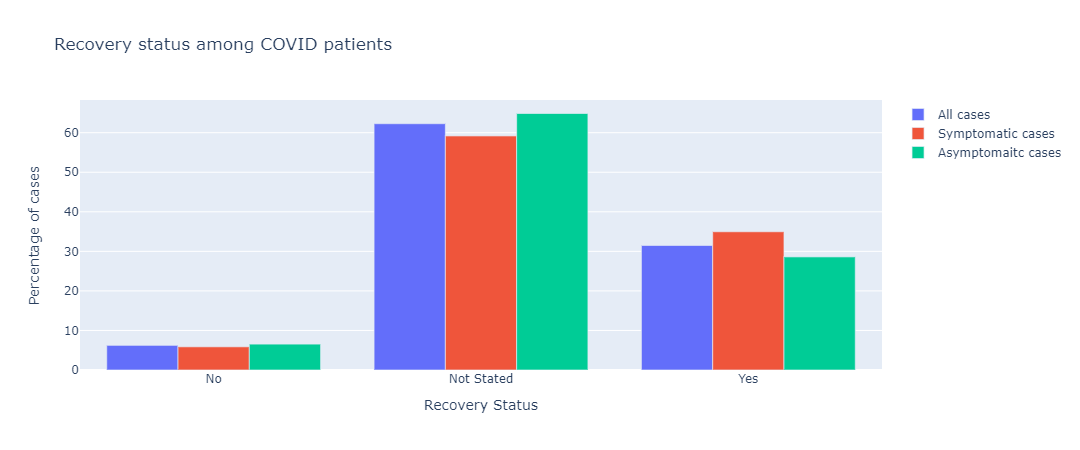

In [66]:
fig = go.Figure(data=[
    go.Bar(name='All cases', x=rec.index, y=rec['Fulldata']),
    go.Bar(name='Symptomatic cases', x=rec.index, y=rec['Symptomatic']),
    go.Bar(name='Asymptomaitc cases', x=rec.index, y=rec['Asymptomatic'])])
fig.update_layout(title_text="Recovery status among COVID patients", xaxis_title="Recovery Status",
    yaxis_title="Percentage of cases",barmode='group')
fig.show()

**Observations**

There is no visible difference in recovery status distribution between symptomatic, asymptomatic and all COVID cases.
We see a similar distribution amongst all three data sets. This suggest that symptomatic or symptomatic patients have similar chances of recovery.

### COVID-19 cases region distribution

The goal is to analyze the region distribution for cases then compare the difference between asymptomatic case, asymptomatic cases and the full data set. The data first needs to be organized to allow for visualization. The following tasks have to be completed.
- Calculate percentage of cases in each region.
- Create data frames with region information for the 3 data sets (Symptomatic cases, asymptomatic cases, all cases).
- Plot the finidings with an appropriate chart. 

In [67]:
# Create a data frame with calculate percentage of individuals in each region for the 3 data sets
# Data frame with calculated percentage of individuals in each region for whole data set
loc_count=covid.groupby('Region').count()
loc_sum=sum(loc_count.Case_number)
loc_count["Fulldata"] = loc_count.Case_number * 100 / loc_sum #add percentage column to data frame
loc_count = loc_count.drop(loc_count.columns.to_series()[0:9], axis=1)# drop unecessary columns
loc_count['region'] = loc_count.index # copy index column into a new column
loc_count.reset_index(drop=True)
# Data frame with calculated percentage of individuals in each region for asymptomatic data set
aloc_count=acovid.groupby('Region').count()
aloc_sum=sum(aloc_count.Case_number)
aloc_count["Asymptomatic"] = aloc_count.Case_number * 100 / aloc_sum #add percentage column to data frame
aloc_count = aloc_count.drop(aloc_count.columns.to_series()[2:10], axis=1)# drop unecessary columns 
aloc_count = aloc_count.drop(aloc_count.columns[0], axis=1)
aloc_count['region'] = aloc_count.index # copy index column into a new column
aloc_count.reset_index(drop=True)
# Data frame with calculated percentage of individuals in each region for symptomatic data set
sloc_count=scovid.groupby('Region').count()
sloc_sum=sum(sloc_count.Case_number)
sloc_count["Symptomatic"] = sloc_count.Case_number * 100 / sloc_sum #add percentage column to data frame
sloc_count = sloc_count.drop(sloc_count.columns.to_series()[0:9], axis=1)# drop unecessary columns
sloc_count['region'] = sloc_count.index # copy index column into a new column
sloc_count.reset_index(drop=True)

Symptomatic    region
0     9.070796  Atlantic
1    11.172566        BC
2    61.946903   Ontario
3    17.809735  Prairies

#### Part 3 (PREPARING DATA TO CHART)
Data needs to be organized in one table to allow for visualization

In [68]:
#Create one table with region data for symptomatic, asyptomatic and all COVID cases
loc=loc_count.merge(aloc_count,on='region', how='left')
loc=loc.merge(sloc_count,on='region', how='left').set_index('region')
loc

Fulldata  Asymptomatic  Symptomatic
region                                        
Atlantic   4.728370      1.107011     9.070796
BC         6.438632      2.490775    11.172566
Ontario   69.064386     75.000000    61.946903
Prairies  19.768612     21.402214    17.809735

In [69]:
#Plot the findings
def f(dataset):
    fig = px.bar(loc.T.loc[str(dataset)],
              labels={'value':'percentage of individuals {}'.format(str(dataset))},
              title= 'COVID cases hospital region distribution')
    fig.update_yaxes(range=[0, 100])
    fig.show()
    
interact(f, dataset=list(loc.T.index) )

interactive(children=(Dropdown(description='dataset', options=('Fulldata', 'Asymptomatic', 'Symptomatic'), val…

<function __main__.f(dataset)>

**Observations**

We see a similar distribution amongst all three data sets. Asymptomatic patients percentage seems to be a bit lower in the Atlantic and BC region. This suggest that symptomatic or symptomatic patients are pressent in most provinces with similar distributions

### COVID-19 cases death

The goal is to analyze the death rate for cases then compare the difference between asymptomatic case, asymptomatic cases and the full data set. The data first needs to be organized to allow for visualization. The following tasks have to be completed.
- Calculate percentage of cases in each region.
- Create data frames with death rate information for the 3 data sets (Symptomatic cases, asymptomatic cases, all cases).
- Plot the finidings with an appropriate chart. 

In [70]:
# Create a data frame with calculate death percentage for the 3 data sets
# Data frame with calculated death percentage for whole data set
dea_count=covid.groupby('Death').count()
dea_sum=sum(dea_count.Case_number)
dea_count["Fulldata"] = dea_count.Case_number * 100 / dea_sum #add percentage column to data frame
dea_count = dea_count.drop(dea_count.columns.to_series()[0:9], axis=1)# drop unecessary columns
dea_count['death'] = dea_count.index # copy index column into a new column
dea_count.reset_index(drop=True)
# Data frame with calculated death percentage for asymptomatic data set
adea_count=acovid.groupby('Death').count()
adea_sum=sum(adea_count.Case_number)
adea_count["Asymptomatic"] = adea_count.Case_number * 100 / adea_sum #add percentage column to data frame
adea_count = adea_count.drop(adea_count.columns.to_series()[2:10], axis=1)# drop unecessary columns 
adea_count = adea_count.drop(adea_count.columns[0], axis=1)
adea_count['death'] = adea_count.index # copy index column into a new column
adea_count.reset_index(drop=True)
# Data frame with calculated death percentage for symptomatic data set
sdea_count=scovid.groupby('Death').count()
sdea_sum=sum(sdea_count.Case_number)
sdea_count["Symptomatic"] = sdea_count.Case_number * 100 / sdea_sum #add percentage column to data frame
sdea_count = sdea_count.drop(sdea_count.columns.to_series()[0:9], axis=1)# drop unecessary columns
sdea_count['death'] = sdea_count.index # copy index column into a new column
sdea_count.reset_index(drop=True)

Symptomatic death
0    76.106195    No
1    23.893805   Yes

In [71]:
#Create one table with death percetage for symptomatic, asyptomatic and all COVID cases
dea=dea_count.merge(adea_count,on='death', how='left')
dea=dea.merge(sdea_count,on='death', how='left').set_index('death')
dea

Fulldata  Asymptomatic  Symptomatic
death                                      
No     84.909457     92.250923    76.106195
Yes    15.090543      7.749077    23.893805

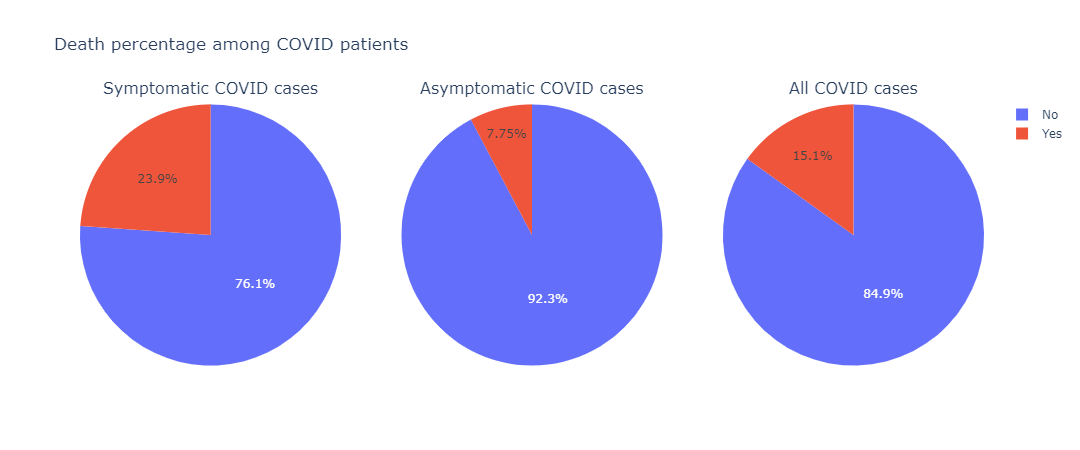

In [72]:
#Graph the outcome using a pie chart with subplots
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ["No", "Yes"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'} ]],
                    subplot_titles=['Symptomatic COVID cases', 'Asymptomatic COVID cases', 'All COVID cases'])
fig.add_trace(go.Pie(labels=labels, values=dea['Symptomatic'], name="Symptomatic COVID cases"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=dea['Asymptomatic'], name="Asymptomatic COVID cases"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=dea['Fulldata'], name="All COVID cases"),
              1, 3)

fig.update_layout(title_text="Death percentage among COVID patients")
fig.show()

**Observations**

As expected data shows that asymptomatic COVID patients are less likely to die due to COVID

## CONCLUSION
***

#### The questions we want to investigate are:
- What are the characteristics that make up the asymptomatic group of individuals? (occupation, recovery rate, age groups, hospital status, gender Region
- Are these individuals more likely to survive COVID than asymptomatic individual?
***

#### The answer to this question is:
***
- Asymptomatic individuals have a tendency to be a little bit younger than symptomatic indviduals. We see increased number of cases in the 0-19 age group in the asymptomatic sample compared to the symptomatic. This makes sense as other data has shown that younger individuals have a tendency to recover better from the virus and not be hit as hard by it. This means that younger asymptomatic individuals may be contributing to the spread as they are more likely to feel good and more likely to mingle and not social distance even if they have the virus.
-  Asymptomatic individuals are less liekly to be hospitalized than symptomatic individuals as expected. What is interesting about this data is that it shows that asymptomatic individuals' condition may actually degenenerate over time and require them to be hospitalized even though they start out as asymptomatic. So no one is safe!
- Asymptomatic individuals are less likely to die due to COVID-19 as expected as they tend do better than symptomatic individuals.
- Gender does not impact wether cases are symptomatic or asymptomatic. This is expected. Both genders seem to be affected equally by the virus.
- Regions such as Atlantic and BC have lower percentage of asymptomatic cases. This may be due to their testing reccomendations. COVID-19 data shows that Atlantic regions have low number of testing which may contribute to the low number of asymptomatic cases. The Atlantic regions may not be doing as much asymptomatic testing.
- Asymptomatic and symptomatic individuals groups have similar occupation distribution as expected.
- Recovery rate is similar among asymptomatic and symptomatic groups. Data shows that generally the majority of individuals affected by COVID will recover so this finiding is in line with the data.

- Follow-up on this analyis should include:
    * Further analysis on other characteristics that make up the asymptomatic group of individuals. It would be intersting to look at wether race or socio-economic status may have any correlation with asymptomatic cases.


## OVERALL CONCLUSION AND FINDINGS
***
COVID-19 has had a major impact on Canadians in 2020. Our analysis examining health and economic data has highlighted key learnings that are vital to constraining the impact of COVID-19 on every age and demographic in Canada.

Key Learnings:


1 – COVID-19 Policies on Health of Canadians: Re-opening strategies for Provinces with no inter-country travel restrictions were flawed from the beginning. The flow of persons into and out of a province appears to have been a deciding factor in allowing the rise of COVID-19 cases after re-opening in stage 2. Provinces with travel restrictions – notably the ‘Atlantic Bubble’ also re-opened similarly to other provinces but did not see an increase in COVID-19.

2- Excess deaths have been highlighted as a concern in regards to the COVID-19 restrictions – as hospitals focus on COVID-19 patients and delay elective surgeries. The excess death data calculated illustrated a very different picture – overall excess death rates have not been higher. This shows that delaying elective surgeries and focusing on COVID-19 has been the right approach.
 

3- Asymptomatic spreading has been an area of interest with respect to how it may impact COVID-19 spreading. The learnings of our study found that asymptomatic patients were most likely to be in the 0-19 age group and persons with asymptomatic COVID-19 were least likely to be admitted to hospital. This highlighted that younger populations may be more likely to unknowingly spread COVID-19. This could be correlated to the fact COVID-19 active cases are now back on the rise with provincial decisions to have kids go back to school in September 2020.

4- COVID-19 Policies on Canadian Economy: The economic data for Goods Producing (GPI) and Service Producing (SPI) industries highlighted what industries have been most impacted by COVID-19  - both positively and negatively

Service Producing Industries (SPI) – such as restaurants and bars - have felt the brunt of the economic downturn since the beginning of the pandemic. These industries have seen significant downturn in all provinces
Goods Producing Industries (GPI) have weathered the COVID-19 economic storm – as shown by an increasing employment rate.

5 -  Provinces with more lenient restrictions were expected to have a higher rate of economic recovery than provinces that maintained stringent policies. This has not necessarily been true as both strict and lenient provinces have had similar strong economic recoveries in 2020

Positive economic recoveries were observed for Quebec, British Columbia and Alberta
Nova Scotia has managed to outperform expectations and has seen a similar recovery in both GPI and SPI sectors.

Province policies on re-opening after the first wave have had major consequences on how COVID-19 is now impacting each province in the second wave. Stricter policies – notably travel restrictions in and out of provinces have proven key in balancing the health and the economic during this pandemic.
Future Analysis:
- Further study on the impact on Asympomatic cases and understand it’s impact on pandemic spreading
- Follow-up on second wave – how will the provinces manage restrictions the second time? Will they follow Atlantic Canada’s lead on managing the spread of the pandemic
- How have Canadians gotten back to work during the pandemic? What economic policies have been the most effective. Nova Scotia has managed to do well economically so further study on Nova Scotia would be warranted.